In [ ]:
# Imagen("Files/banner nocountry.jpg", (20,10))

# Importaciones

In [ ]:
!pip install missingno -q

In [1]:
# Modulos a utilizar
import os
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
#import funciones
import warnings
warnings.filterwarnings(action= 'ignore')


# Funciones

In [2]:
def Imagen(path_relativo: str, size: tuple[int,int], path_absoluto:  None|str= None):

    """
    Esta funcion recibe un path relativo referente a una imagen (o un path absoluto), y el tamaño/dimensiones que
    debe tener en forma de tupla (width, height)

    devuelve la imagen pasada con las dimensiones obtenidas

    parameters: path_relativo (str), size (tuple[int,int]), path_absoluto(None,str)

    returns: None
    """

    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    if path_absoluto == None:
        # Load image
        image = mpimg.imread("/lakehouse/default/" + path_relativo)
    else:
        # Load image
        image = mpimg.imread(path_absoluto)
    # Let the axes disappear
    plt.figure(figsize= size)
    plt.axis('off')
    # Plot image in the output
    image_plot = plt.imshow(image)

### Para Informe preliminar

In [3]:
def verificar_tipo_datos(df):

    mi_dict = {"nombre_campo": [], "tipo_datos": [], "no_nulos_%": [], "nulos_%": [], "nulos": []}

    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count() / len(df)) * 100
        mi_dict["nombre_campo"].append(columna)
        mi_dict["tipo_datos"].append(df[columna].apply(type).unique())
        mi_dict["no_nulos_%"].append(round(porcentaje_no_nulos, 2))
        mi_dict["nulos_%"].append(round(100-porcentaje_no_nulos, 2))
        mi_dict["nulos"].append(df[columna].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
    pd.set_option('display.max_rows', None)

    return df_info

In [4]:
def informe_dataframe(dataframe: pd.DataFrame) -> None:

    df = dataframe

    print('INFORME PRELIMINAR SOBRE CARACTERISTICAS DEL DATASET:\n')
    print(f'--Dimensiones del DataFrame--\nFilas: {df.shape[0]}\nColumnas: {df.shape[1]}\n')
    print(f'--Numero de datos--\n{df[df.isna() == False].count().sum()}\n')
    print(f'--Filas y Columnas--\nFilas: muestra de indices-------> {list(df.index)[0:5]}  -----> Desde {list(df.index)[0]}  Hasta {list(df.index)[-1]}\nColumnas: {list(df.columns)}\n')
    print(f'--Tipo de columnas--\n{df.dtypes}\n')
    columnas= df.columns

    if 'hours' in columnas and 'attributes' not in columnas:
        print(f'--Cantidad de registros duplicados--\n{df.drop(columns=["hours"]).duplicated().sum()}\n')
    elif 'hours' not in columnas and 'attributes' in columnas:
        print(f'--Cantidad de registros duplicados--\n{df.drop(columns=["attributes"]).duplicated().sum()}\n')
    elif 'hours' in columnas and 'attributes' in columnas:
        print(f'--Cantidad de registros duplicados--\n{df.drop(columns=["hours","attributes"]).duplicated().sum()}\n')
    else:
        print(f'--Cantidad de registros duplicados--\n{df.duplicated().sum()}\n')


    # print(f'--Estadisticos preliminares generales--\n{df.describe()}\n')

    return ('~'*50)+'oo'+('~'*50)

In [5]:
def informe_columna(df: None|pd.DataFrame, columna: None|str) -> None:

    data = df[columna]

    def valores_atipicos(muestra):
        import numpy as np

        if muestra.dtype != 'datetime64[ns]' and muestra.dtype != 'object':
            Q1= muestra.quantile(0.25)
            Q3= muestra.quantile(0.75)
            mediana= muestra.median()
            IQR= Q3-Q1

            print(f'Rango intercuartilico: {IQR}')

            limit_sup= Q3 + 1.5*IQR
            limit_inf= Q1 - 1.5*IQR
            print(f'Limite superior de la caja: {limit_sup}\n')
            # print(limit_inf)

            ## buscamos los valores atipicos
            superior= muestra >= (Q3 + 1.5*IQR)
            inferior=  muestra <= (Q1 - 1.5*IQR)

            print(f'Indices donde el valor excede el valor excede el limite superior de la caja:\n {np.where(superior)}\n')
            print(f'Indices donde el valor excede el valor excede el limite inferior de la caja:\n {np.where(inferior)}\n')
        else:
            pass

    # print(f'Informe preliminar sobre la columna/feature {columna}:\n')
    print(f'INFORME PRELIMINAR SOBRE LA COLUMNA/FEATURE {columna}:\n')
    if data.dtype == 'object':
        print(f'--Numero de datos nulos--\n{data.isna().sum()}\n')
        print(f'--Cantidad de valores unicos en la columna--\n{data.describe()[1]}\n')

        if len(data.unique()) > 5:
            print(f'--Valores unicos en la columna (Primeros 5 valores)--\n{data.unique()[0:5]}\n')
        else:
            print(f'--Valores unicos en la columna--\n{data.unique()}\n')

        print(f'--Moda de la columna especificada--\nValor modal -----> {data.describe()[2]}\nFrecuencia acumulada ------> {data.describe()[3]}\n')
        print(f'--Distribucion de frecuencias (primeros valores con mayor cantidad de frecuencias)--\n {data.value_counts().nlargest(3)}\n')
        print('-'*120)
        print('-'*120)
    elif data.dtype == 'datetime64[ns]':
        print(f'--Numero de datos nulos--\n{data.isna().sum()}\n')
        print(f'--Cantidad de valores unicos en la columna--\n{data.describe()[1]}\n')
        ## En el print siguinte, realizamos un formateo de los valores de la columna, ya que la salida predeterminada (el output) agrega otros valores que hacen la intrepretacion mas dificil e incomoda
        print(f'--Valores unicos en la columna--\nEj: {data.dt.strftime("%Y-%m-%d").unique()[0:3]}  -----> Desde {list(data.dt.strftime("%Y-%m-%d").unique())[0]}  Hasta {list(data.dt.strftime("%Y-%m-%d").unique())[-1]}\n')
        print(f'--Moda de la columna especificada--\nValor modal -----> {data.describe()[2]}\nFrecuencia acumulada ------> {data.describe()[3]}\n')
        print(f'--Distribucion de frecuencias (primeros valores con mayor cantidad de frecuencias)--\n {data.value_counts().nlargest(3)}\n')
        print(f'--Valor maximo y minimo--\nMaximo: {data.max()}\nMinimo: {data.min()}\n')
        print('-'*120)
        print('-'*120)
    else:
        print(f'--Numero de datos nulos--\n{data.isna().sum()}\n')
        print(f'--Valores unicos en la columna--\nEj: {data.unique()[0:5]}  -----> Desde {list(data.unique())[0]}  Hasta {list(data.unique())[-1]}\n')
        print(f'--Estadisticos Principales de la columna--\nMedia: {round(data.mean(),2)}\nDesviacion Estandar: {round(data.std(),2)}\nPrimer cuartil: {data.quantile(0.25)}\nMediana: {data.median()}\nTercer cuartil: {data.quantile(0.75)}\n')
        print(f'--Valores extremos--\nValor maximo: {data.max()}\nValor minimo: {data.min()}\n')
        print(f'--Distribucion de frecuencias (primeros valores con mayor cantidad de frecuencias)--\n {data.value_counts().nlargest(3)}\n')
        print(f'--Valor maximo y minimo--\nMaximo: {data.max()}\nMinimo: {data.min()}\n')
        valores_atipicos(data)
        print('-'*120)
        print('-'*120)
    return

In [6]:
def visualizar_nulos(df):
    # fig, axes = plt.subplots(2, 2, figsize=(40, 40))

    # msno.matrix(df, ax=axes[0, 0])
    # msno.bar(df, ax=axes[0, 1])
    # msno.heatmap(df, ax=axes[1, 0])
    # msno.dendrogram(df, ax=axes[1, 1])

    # axes[0, 0].set_title('Matrix Plot')
    # axes[0, 1].set_title('Bar Plot')
    # axes[1, 0].set_title('Heatmap')
    # axes[1, 1].set_title('Dendrogram')
    plt.figure(figsize= (30,30))

    msno.matrix(df)
    plt.title('Matrix Plot')

    msno.bar(df)
    plt.title('Bar Plot')

    msno.heatmap(df)
    plt.title('Heatmap')

    msno.dendrogram(df)
    plt.title('Dendrogram')

    plt.tight_layout()
    plt.show()

In [7]:
def analisis_frecuencia_palabras(dataframe: pd.DataFrame|None, ax=None):

    columnas_cualitativas = dataframe.select_dtypes(include=['object']).columns.tolist()

    if not columnas_cualitativas:
        return 'No existen columnas de tipo str en el dataframe'
    for columna in columnas_cualitativas:
        dataframe[columna] = dataframe[columna].astype(str)
    for columna in columnas_cualitativas:
        texto_columna = dataframe[columna].str.lower().str.replace(r'[^a-zA-Z\s]', '').str.split()
        palabras_columna = [word for sublist in texto_columna for word in sublist]
        frecuencia_palabras = Counter(palabras_columna)
        palabras_mas_frecuentes = frecuencia_palabras.most_common(20)
        plt.figure(figsize=(10, 6))
        plt.bar(*zip(*palabras_mas_frecuentes))
        plt.xticks(rotation=45)
        plt.xlabel('Palabra')
        plt.ylabel('Frecuencia')
        plt.title(f'Palabras más frecuentes en la columna {columna}')
        plt.show()

In [8]:
def boxplots_numericas(dataframe):
    df_numericas = dataframe.select_dtypes(include=['number'])
    if df_numericas.empty:
        return 'No existen columnas de tipo numericas en el dataframe'
    for columna in df_numericas.columns:
        sns.boxplot(x=dataframe[columna])
        plt.title(f'Diagrama de caja para {columna}')
        plt.show()

In [ ]:
# def graficos_multiples(dataframe: pd.DataFrame) -> None:

#     fig, axs = plt.subplots(2, 1, figsize=(20, 10))

#     analisis_frecuencia_palabras(dataframe, ax=axs[0])
#     boxplots_numericas(dataframe, ax=axs[1])

#     plt.tight_layout()
#     plt.show()

####################arreglar#########################################

StatementMeta(, fa1c7968-8280-429c-bd14-ecdf3634ba72, 15, Finished, Available)

In [9]:
def hist_duplicados(dataframe: str|pd.DataFrame):

    columnas= dataframe.columns

    if 'hours' in columnas and 'attributes' not in columnas:
        df_duplicates= dataframe.drop(columns=["hours"]).duplicated().value_counts()
    elif 'hours' not in columnas and 'attributes' in columnas:
        df_duplicates= dataframe.drop(columns=["attributes"]).duplicated().value_counts()
    elif 'hours' in columnas and 'attributes' in columnas:
        df_duplicates= dataframe.drop(columns=["hours","attributes"]).duplicated().value_counts()
    else:
        df_duplicates= dataframe.duplicated().value_counts()

    df_duplicates = pd.DataFrame({'Duplicados': df_duplicates.index, 'Frecuencia': df_duplicates.values})
    if not df_duplicates.empty:
        sns.barplot(x='Duplicados', y='Frecuencia', data=df_duplicates)
        plt.title('Conteo de Frecuencias de Registros Duplicados')
        plt.xlabel('Duplicados')
        plt.ylabel('Frecuencia')
        plt.xticks([0, 1], ['No Duplicados', 'Duplicados'])
        plt.show()
    else:
        print("No se encontraron registros duplicados.")

### Para Análisis


In [10]:
def cantidad_por_dia_semana(df: pd.DataFrame):

    '''
    Crea una serie de graficos de barras y de torta que muestran la distribucion de los valores de la feature/columna.

    Tambien imprime una serie de valores y metricas basicas en referencia a los valores y distribucion de valores de la columna/feature

    Parameters:
        df (pandas.DataFrame): El DataFrame que contiene los datos de la recopilacion de features de ICFES.

    Returns:
        None
    '''

    columnas = df.columns


    for columna in columnas:
        muestra = df[columna].value_counts().nlargest(10)
        # Se crea el gráfico de barras
        plt.figure(figsize=(20,10))

        if df[columna].dtype == 'object':
            plt.subplot(1,2,1)
            ax = sns.barplot(x= muestra.index, y=muestra, data= df)

            ax.set_title(f'Grafico de distribucion de frecuencias (primeros 5 valores){columna}') ; ax.set_xlabel(columna) ; ax.set_ylabel('Cantidad de frecuencias')
            plt.xticks(rotation=45)

            # Se crea un grafico de torta para graficar las proporciones representativas de los datos
            plt.subplot(1,2,2)
            plt.pie(x= muestra, labels= muestra.index, shadow= True, autopct='%1.1f%%', data= df)
            plt.title('Distribucion Relativa de Valores')
            plt.xlabel(columna)
            plt.grid()

        else:
            plt.subplot(1,2,1)
            sns.boxplot(x=df[columna])
            plt.title(f'Diagrama de caja para {columna}')


            # Se crea un grafico de torta para graficar las proporciones representativas de los datos
            plt.subplot(1,2,2)
            plt.pie(x= muestra, labels= muestra.index, shadow= True, autopct='%1.1f%%', data= df)
            plt.title('Distribucion Relativa de Valores')
            plt.xlabel(columna)
            plt.grid()


        # Se muestra el gráfico
        plt.show()

        # Se muestran algunos estadisticos principales
        print('\n')
        print('Estadisticas Basicas')
        print('\n')
        print(df[columna].describe())
        print('-'*160)
        print('-'*160)
        print('\n')



<h1 align= 'center><u>**Análisis**</u></h1>

# <h1 align= 'center'><u>**Desarrollo**</u></h1>

In [15]:
from google.colab import drive

In [16]:
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# instanciamos el fichero con la data
df= pd.read_parquet('/content/drive/MyDrive/No Country Proyecto/Data/Clean/Icfes2023.parquet')

In [18]:
# Reiniciamos su indice
df= df.drop_duplicates().reset_index(drop= True)

In [19]:
df.head(5)

ESTU_TIPODOCUMENTO ESTU_GENERO  PERIODO ESTU_DEPTO_RESIDE ESTU_MCPIO_RESIDE  \
0                 TI           F        1      CUNDINAMARCA              CHÍA   
1                 CC           F        1             VALLE              CALI   
2                 TI           F        1             VALLE              CALI   
3                 TI           F        1             VALLE        CAICEDONIA   
4                 TI           M        1             VALLE           JAMUNDÍ   

  ESTU_PRESENTACIONSABADO  FAMI_ESTRATOVIVIENDA FAMI_PERSONASHOGAR  \
0                      No                     3              5 a 6   
1                      No                     3              3 a 4   
2                      No                     2              1 a 2   
3                      No                     1              3 a 4   
4                      No                     1              5 a 6   

   FAMI_CUARTOSHOGAR                   FAMI_EDUCACIONPADRE  ...  \
0                4.0        Educación profesional completa  ...   
1                4.0                               Ninguno  ...   
2                2.0  Secundaria (Bachillerato) incompleta  ...   
3                2.0                   Primaria incompleta  ...   
4                2.0        Técnica o tecnológica completa  ...   

  PERCENTIL_SOCIALES_CIUDADANAS  DESEMP_SOCIALES_CIUDADANAS  PUNT_INGLES  \
0                            97                           4         87.0   
1                             1                           1         58.0   
2                            52                           3         69.0   
3                            42                           2         50.0   
4                            64                           3         52.0   

   PERCENTIL_INGLES  DESEMP_INGLES  PUNT_GLOBAL  PERCENTIL_GLOBAL  \
0              94.0             B+          422             100.0   
1              43.0             A2          200              12.0   
2              57.0             B1          263              39.0   
3              29.0             A1          295              54.0   
4              34.0             A1          320              66.0   

   ESTU_INSE_INDIVIDUAL  ESTU_NSE_INDIVIDUAL  ESTU_NSE_ESTABLECIMIENTO  
0             67.532814                  4.0                       4.0  
1             41.863163                  2.0                       3.0  
2             51.223795                  3.0                       3.0  
3             39.984838                  1.0                       3.0  
4             50.613232                  2.0                       3.0  

[5 rows x 50 columns]

## <h2 align= 'center'><u>Informe Preliminar</u></h2>

### <h3 align= 'center'><u>General</u></h3>

In [20]:
informe_dataframe(df)

INFORME PRELIMINAR SOBRE CARACTERISTICAS DEL DATASET:

--Dimensiones del DataFrame--
Filas: 405869
Columnas: 50

--Numero de datos--
20293450

--Filas y Columnas--
Filas: muestra de indices-------> [0, 1, 2, 3, 4]  -----> Desde 0  Hasta 405868
Columnas: ['ESTU_TIPODOCUMENTO', 'ESTU_GENERO', 'PERIODO', 'ESTU_DEPTO_RESIDE', 'ESTU_MCPIO_RESIDE', 'ESTU_PRESENTACIONSABADO', 'FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR', 'FAMI_CUARTOSHOGAR', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_TRABAJOLABORPADRE', 'FAMI_TRABAJOLABORMADRE', 'FAMI_NUMLIBROS', 'FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO', 'FAMI_COMECEREALFRUTOSLEGUMBRE', 'ESTU_DEDICACIONLECTURADIARIA', 'ESTU_DEDICACIONINTERNET', 'ESTU_HORASSEMANATRABAJA', 'COLE_NOMBRE_ESTABLECIMIENTO', 'COLE_NATURALEZA', 'COLE_BILINGUE', 'COLE_CARACTER', 'COLE_NOMBRE_SEDE', 'COLE_SEDE_PRINCIPAL', 'COLE_AREA_UBICACION', 'COLE_JORNADA', 'COLE_MCPIO_UBICACION', 'ESTU_MCPIO_PRESENTACION', 'PUNT_LECTURA_CRITICA', 'PERCENTIL_LECTURA_CRITICA',

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~oo~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

In [21]:
verificar_tipo_datos(df)

nombre_campo         tipo_datos  no_nulos_%  nulos_%  \
0              ESTU_TIPODOCUMENTO    [<class 'str'>]       100.0      0.0   
1                     ESTU_GENERO    [<class 'str'>]       100.0      0.0   
2                         PERIODO    [<class 'int'>]       100.0      0.0   
3               ESTU_DEPTO_RESIDE    [<class 'str'>]       100.0      0.0   
4               ESTU_MCPIO_RESIDE    [<class 'str'>]       100.0      0.0   
5         ESTU_PRESENTACIONSABADO    [<class 'str'>]       100.0      0.0   
6            FAMI_ESTRATOVIVIENDA    [<class 'int'>]       100.0      0.0   
7              FAMI_PERSONASHOGAR    [<class 'str'>]       100.0      0.0   
8               FAMI_CUARTOSHOGAR  [<class 'float'>]       100.0      0.0   
9             FAMI_EDUCACIONPADRE    [<class 'str'>]       100.0      0.0   
10            FAMI_EDUCACIONMADRE    [<class 'str'>]       100.0      0.0   
11         FAMI_TRABAJOLABORPADRE    [<class 'int'>]       100.0      0.0   
12         FAMI_TRABAJOLABORMADRE    [<class 'int'>]       100.0      0.0   
13                 FAMI_NUMLIBROS    [<class 'int'>]       100.0      0.0   
14        FAMI_COMELECHEDERIVADOS    [<class 'int'>]       100.0      0.0   
15     FAMI_COMECARNEPESCADOHUEVO    [<class 'int'>]       100.0      0.0   
16  FAMI_COMECEREALFRUTOSLEGUMBRE    [<class 'int'>]       100.0      0.0   
17   ESTU_DEDICACIONLECTURADIARIA    [<class 'int'>]       100.0      0.0   
18        ESTU_DEDICACIONINTERNET    [<class 'int'>]       100.0      0.0   
19        ESTU_HORASSEMANATRABAJA    [<class 'int'>]       100.0      0.0   
20    COLE_NOMBRE_ESTABLECIMIENTO    [<class 'str'>]       100.0      0.0   
21                COLE_NATURALEZA    [<class 'str'>]       100.0      0.0   
22                  COLE_BILINGUE    [<class 'str'>]       100.0      0.0   
23                  COLE_CARACTER    [<class 'str'>]       100.0      0.0   
24               COLE_NOMBRE_SEDE    [<class 'str'>]       100.0      0.0   
25            COLE_SEDE_PRINCIPAL    [<class 'str'>]       100.0      0.0   
26            COLE_AREA_UBICACION    [<class 'str'>]       100.0      0.0   
27                   COLE_JORNADA    [<class 'str'>]       100.0      0.0   
28           COLE_MCPIO_UBICACION    [<class 'str'>]       100.0      0.0   
29        ESTU_MCPIO_PRESENTACION    [<class 'str'>]       100.0      0.0   
30           PUNT_LECTURA_CRITICA    [<class 'int'>]       100.0      0.0   
31      PERCENTIL_LECTURA_CRITICA    [<class 'int'>]       100.0      0.0   
32         DESEMP_LECTURA_CRITICA    [<class 'int'>]       100.0      0.0   
33               PUNT_MATEMATICAS    [<class 'int'>]       100.0      0.0   
34          PERCENTIL_MATEMATICAS    [<class 'int'>]       100.0      0.0   
35             DESEMP_MATEMATICAS    [<class 'int'>]       100.0      0.0   
36               PUNT_C_NATURALES    [<class 'int'>]       100.0      0.0   
37          PERCENTIL_C_NATURALES    [<class 'int'>]       100.0      0.0   
38             DESEMP_C_NATURALES    [<class 'int'>]       100.0      0.0   
39       PUNT_SOCIALES_CIUDADANAS    [<class 'int'>]       100.0      0.0   
40  PERCENTIL_SOCIALES_CIUDADANAS    [<class 'int'>]       100.0      0.0   
41     DESEMP_SOCIALES_CIUDADANAS    [<class 'int'>]       100.0      0.0   
42                    PUNT_INGLES  [<class 'float'>]       100.0      0.0   
43               PERCENTIL_INGLES  [<class 'float'>]       100.0      0.0   
44                  DESEMP_INGLES    [<class 'str'>]       100.0      0.0   
45                    PUNT_GLOBAL    [<class 'int'>]       100.0      0.0   
46               PERCENTIL_GLOBAL  [<class 'float'>]       100.0      0.0   
47           ESTU_INSE_INDIVIDUAL  [<class 'float'>]       100.0      0.0   
48            ESTU_NSE_INDIVIDUAL  [<class 'float'>]       100.0      0.0   
49       ESTU_NSE_ESTABLECIMIENTO  [<class 'float'>]       100.0      0.0   

    nulos  
0       0  
1       0  
2       0  
3       0  
4       0  
5       0  
6       0

### <h3 align= 'center'><u>Particular</u></h3>

In [22]:
for columna in df.columns:
    informe_columna(df, columna)

INFORME PRELIMINAR SOBRE LA COLUMNA/FEATURE ESTU_TIPODOCUMENTO:

--Numero de datos nulos--
0

--Cantidad de valores unicos en la columna--
2

--Valores unicos en la columna--
['TI' 'CC']

--Moda de la columna especificada--
Valor modal -----> TI
Frecuencia acumulada ------> 358212

--Distribucion de frecuencias (primeros valores con mayor cantidad de frecuencias)--
 ESTU_TIPODOCUMENTO
TI    358212
CC     47657
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
INFORME PRELIMINAR SOBRE LA COLUMNA/FEATURE ESTU_GENERO:

--Numero de datos nulos--
0

--Cantidad de valores unicos en la columna--
2

--Valores unicos en la columna--
['F' 'M']

--Moda de la columna especificada--
Valor modal -----> F
Frecuencia acumulada ------> 220145

--Distribucion de frecuencias (primeros valo

### <h3 size= 22 align= 'center'><u>Gráficos</u></h3>

<Figure size 3000x3000 with 0 Axes>

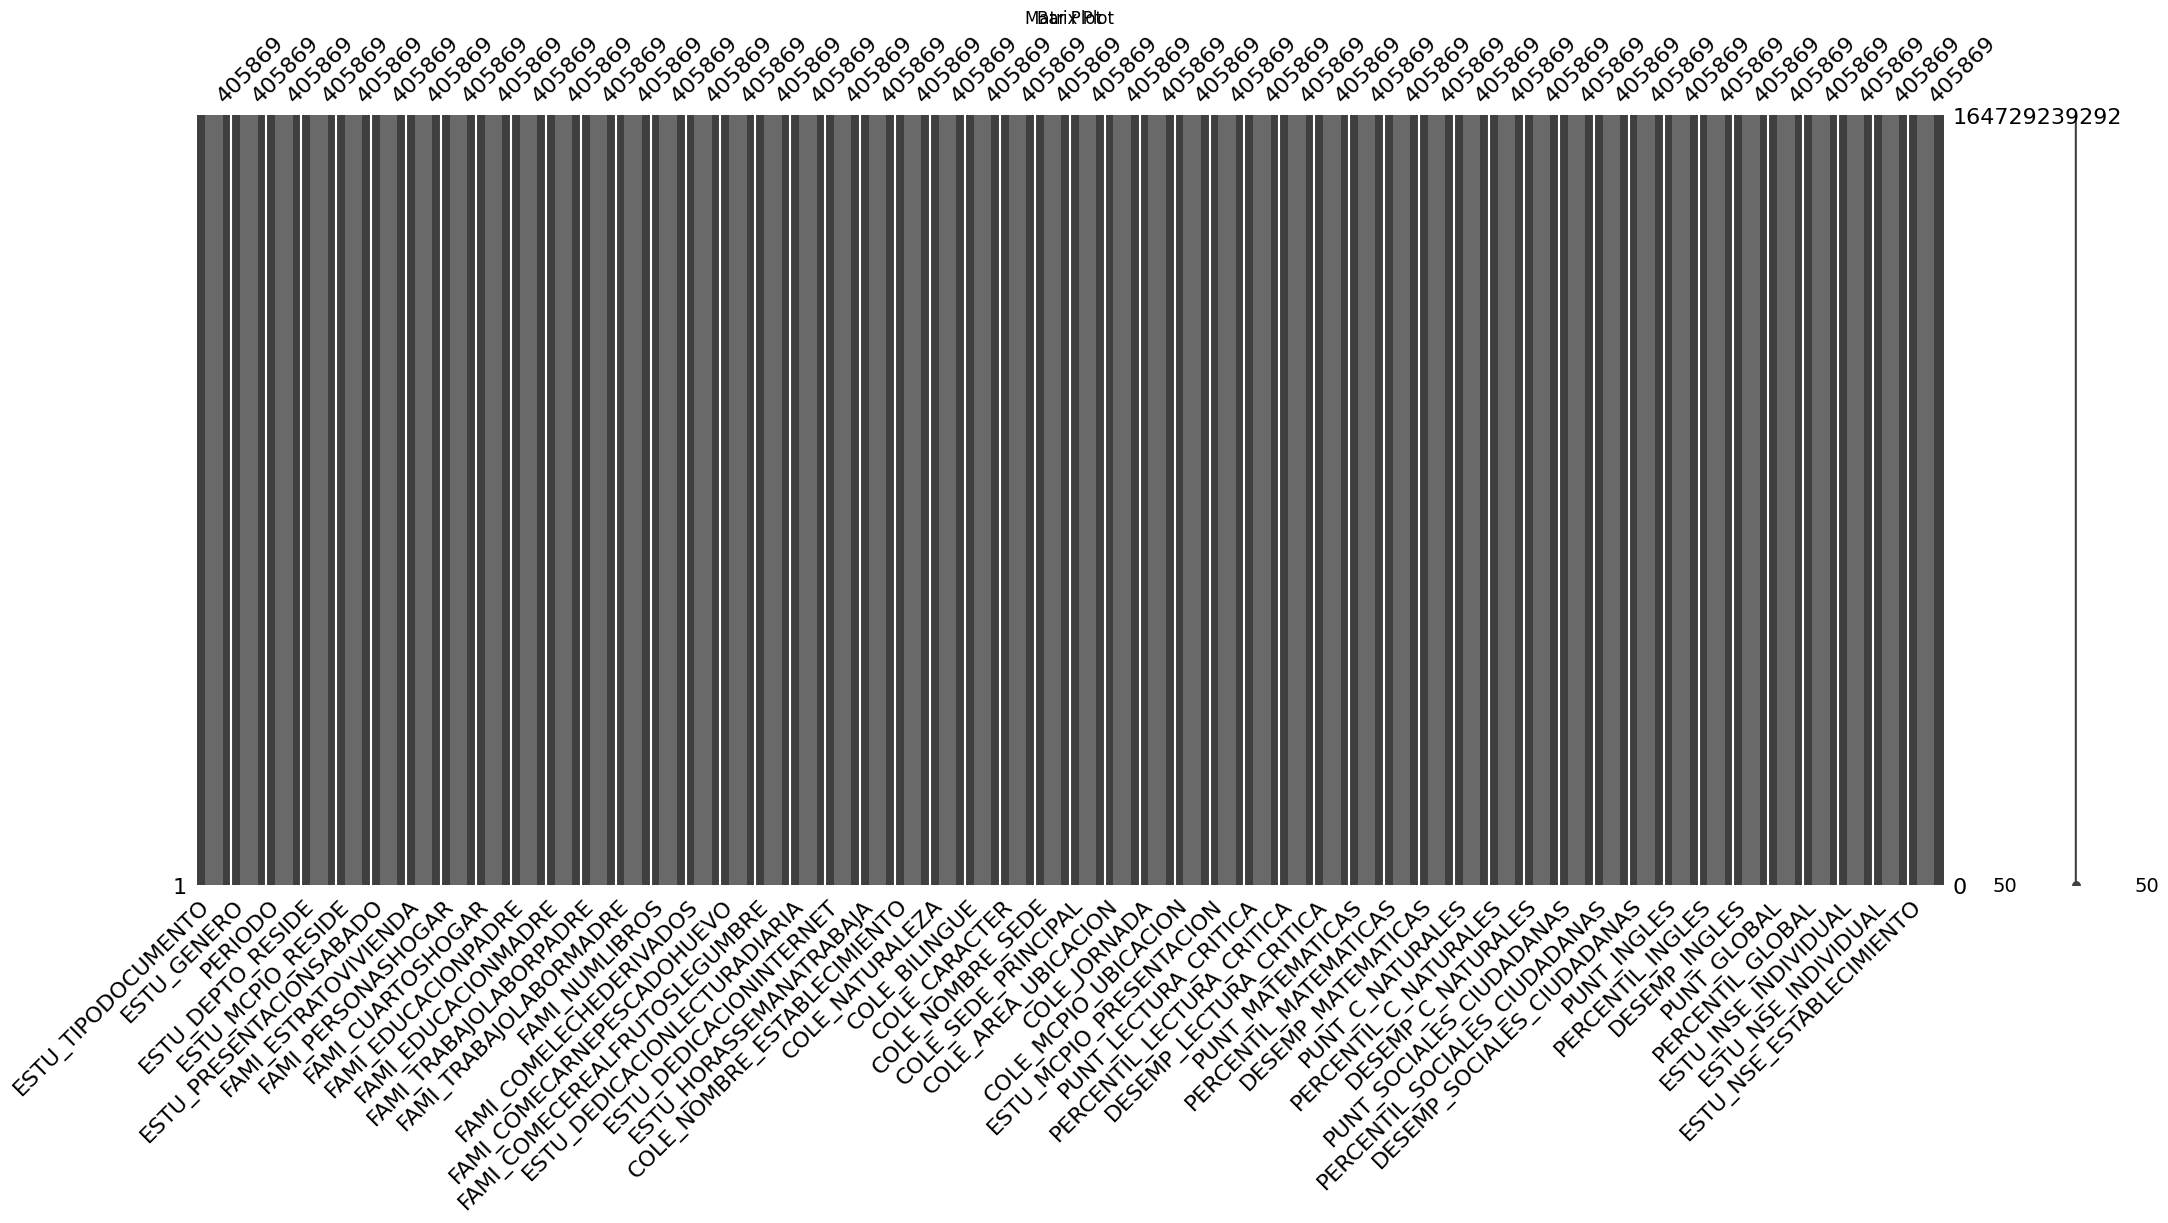

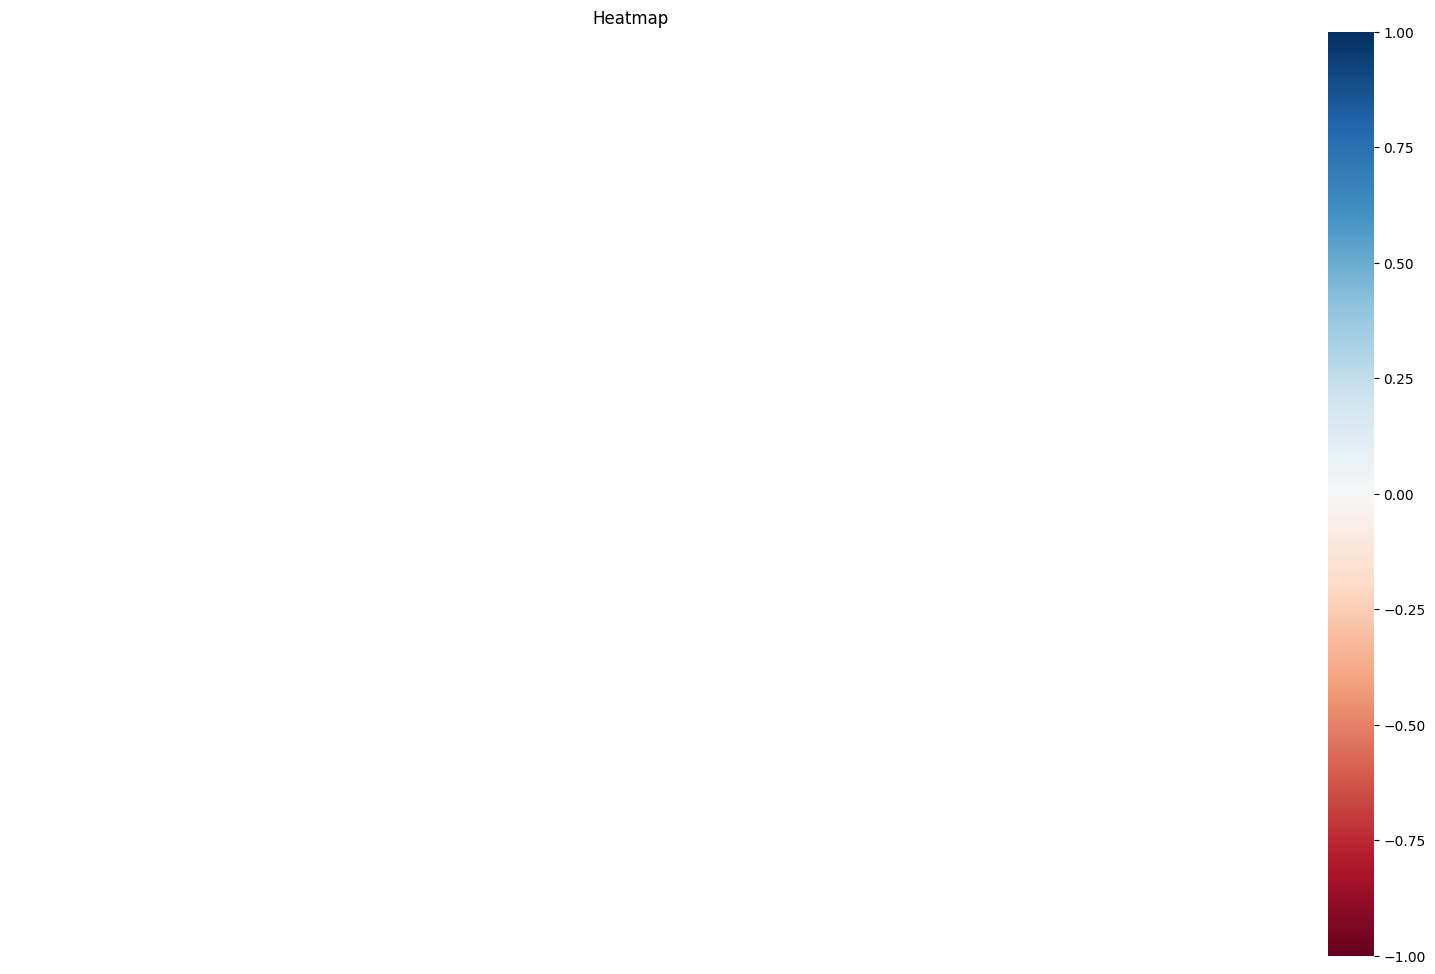

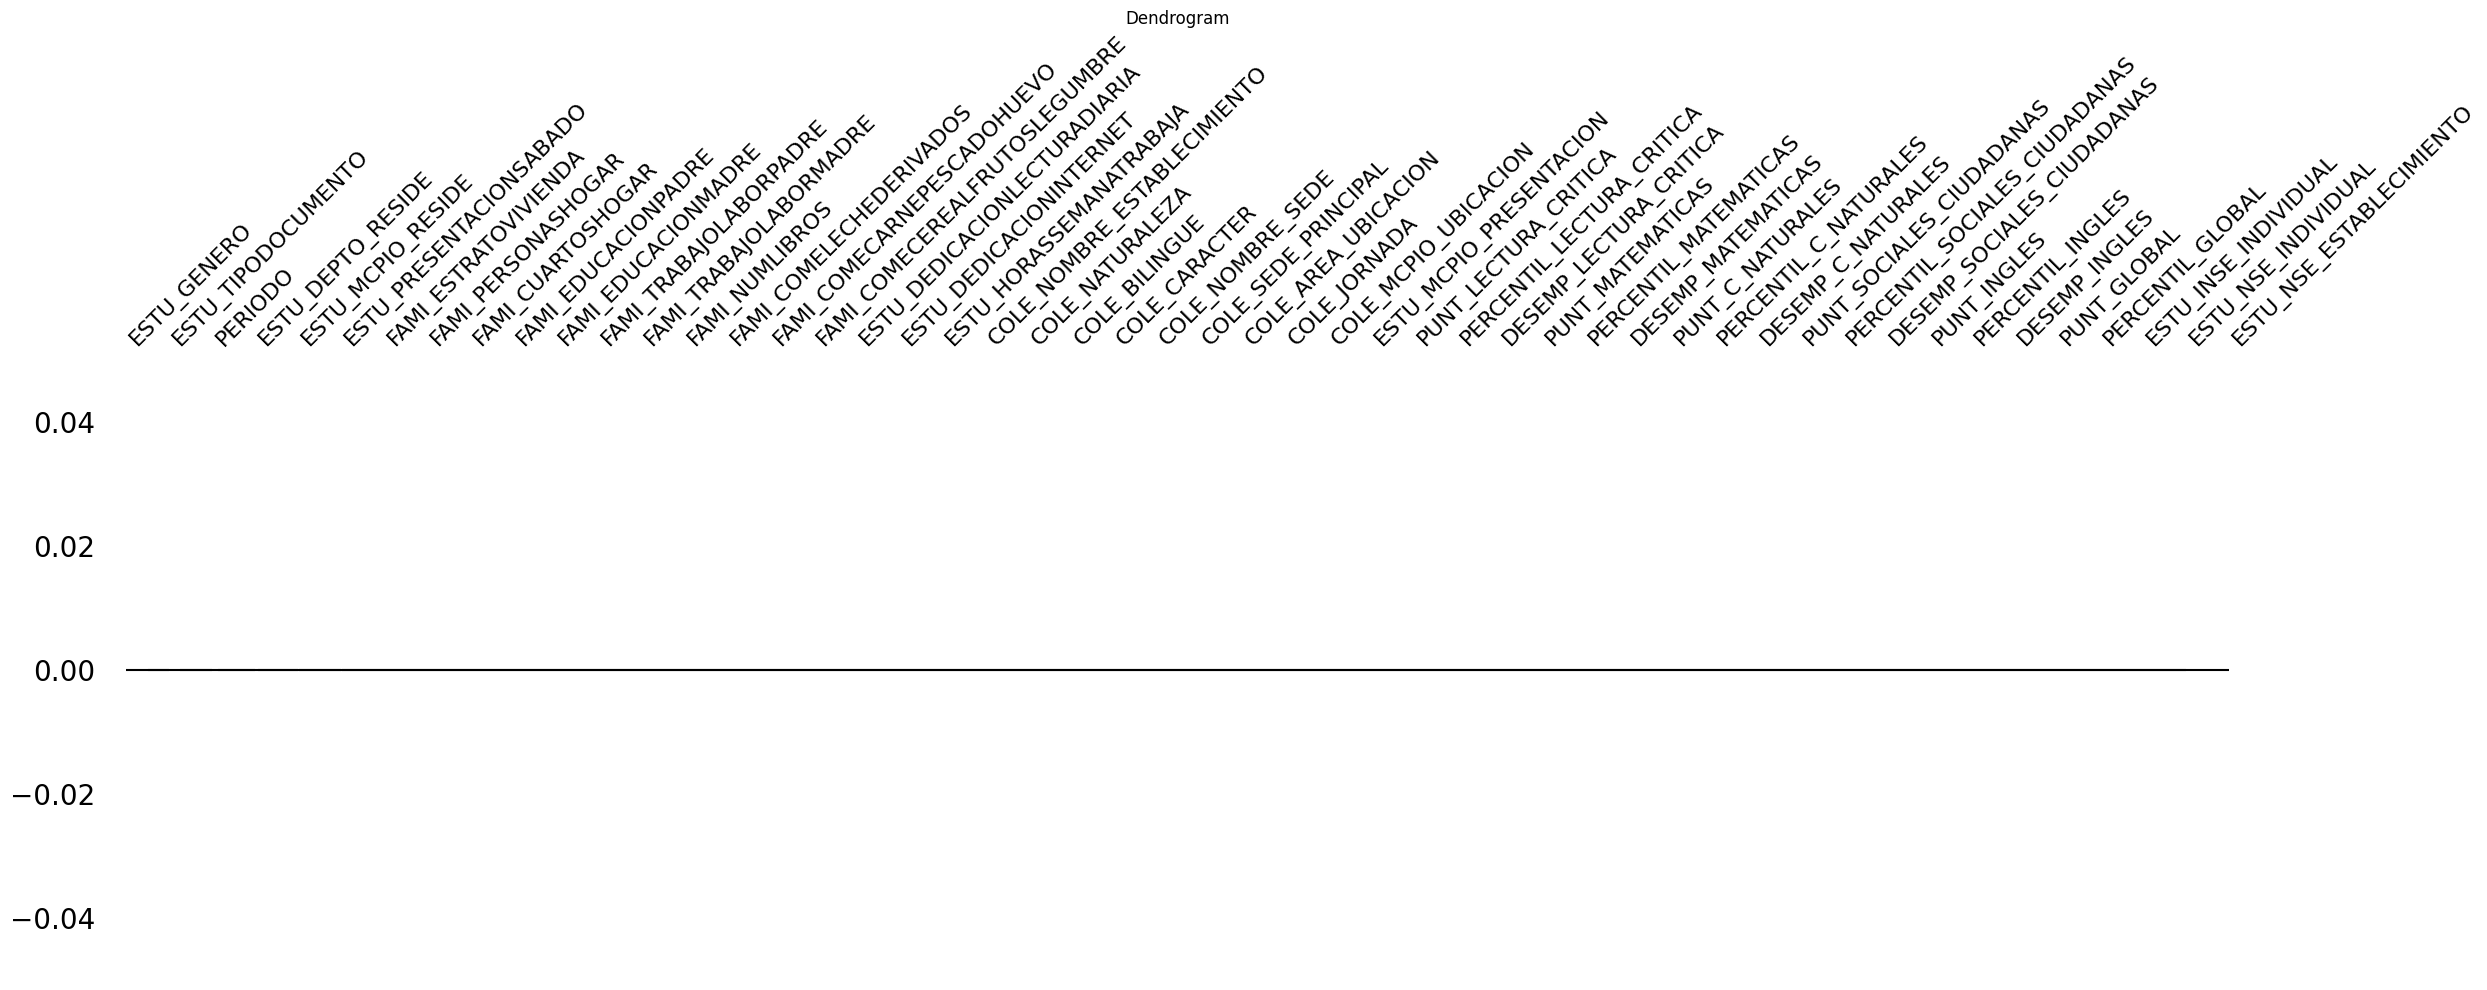

In [23]:
visualizar_nulos(df)

In [ ]:
# graficos_multiples(df)

StatementMeta(, fa1c7968-8280-429c-bd14-ecdf3634ba72, 25, Finished, Available)

StatementMeta(, fa1c7968-8280-429c-bd14-ecdf3634ba72, 26, Finished, Available)

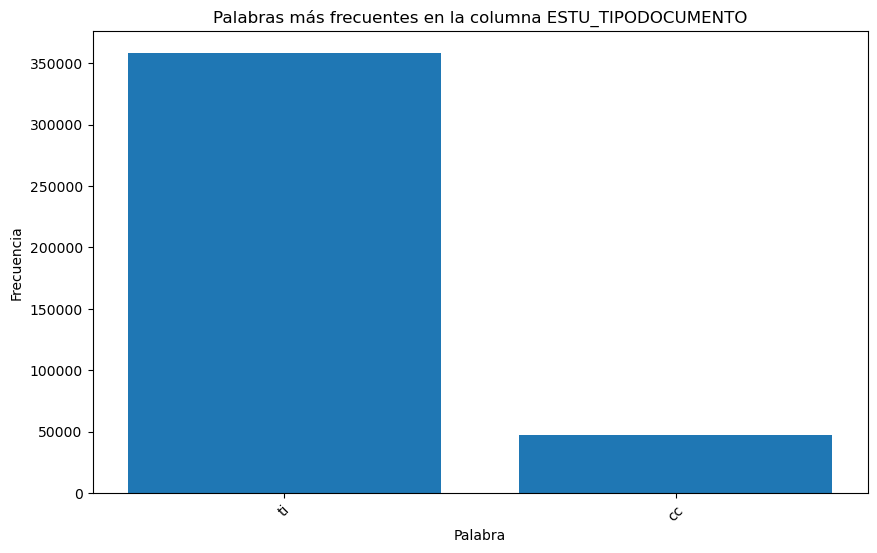

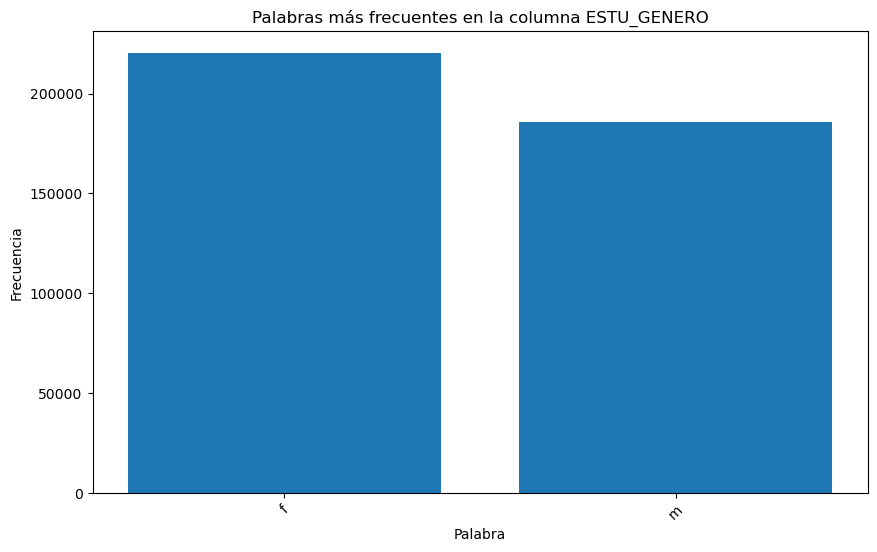

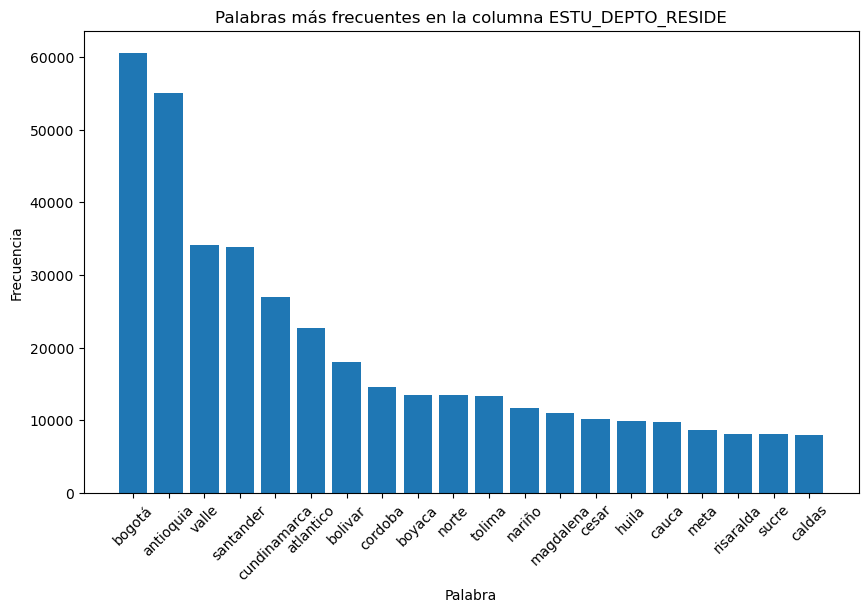

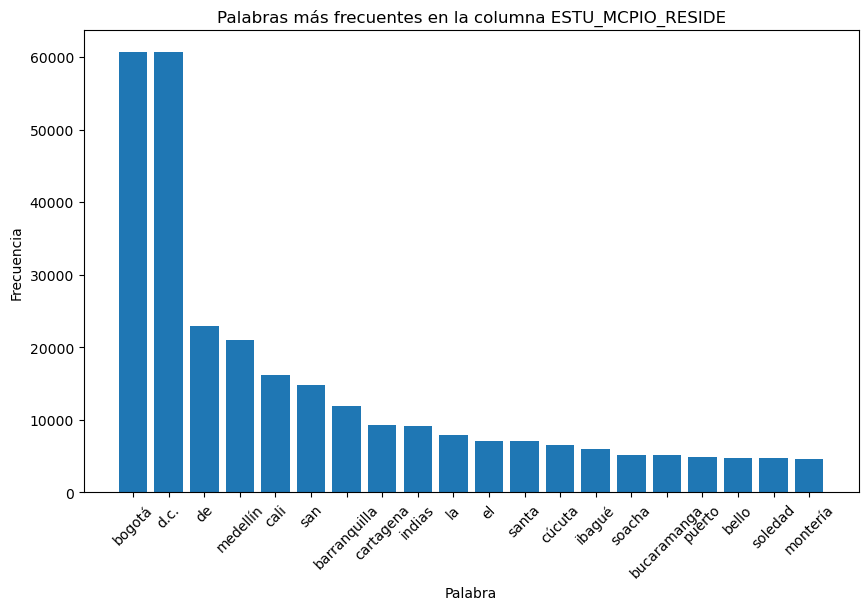

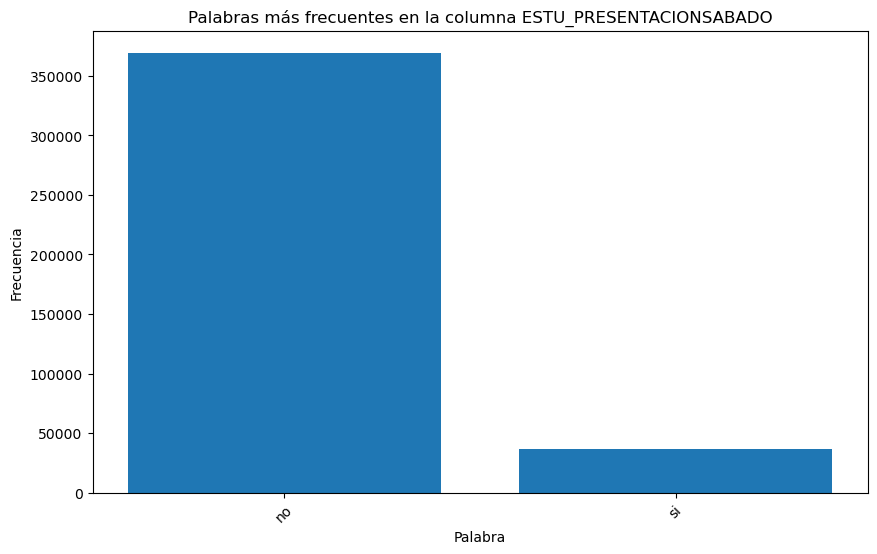

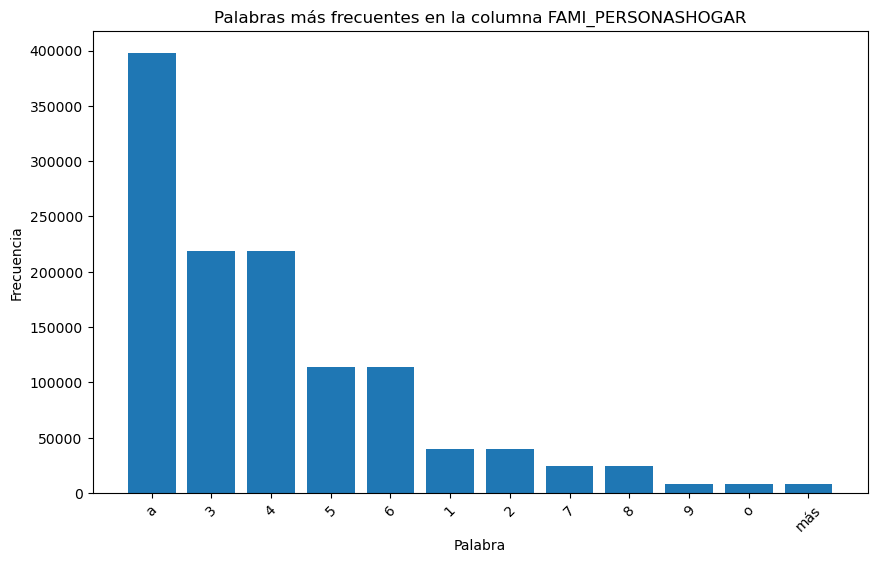

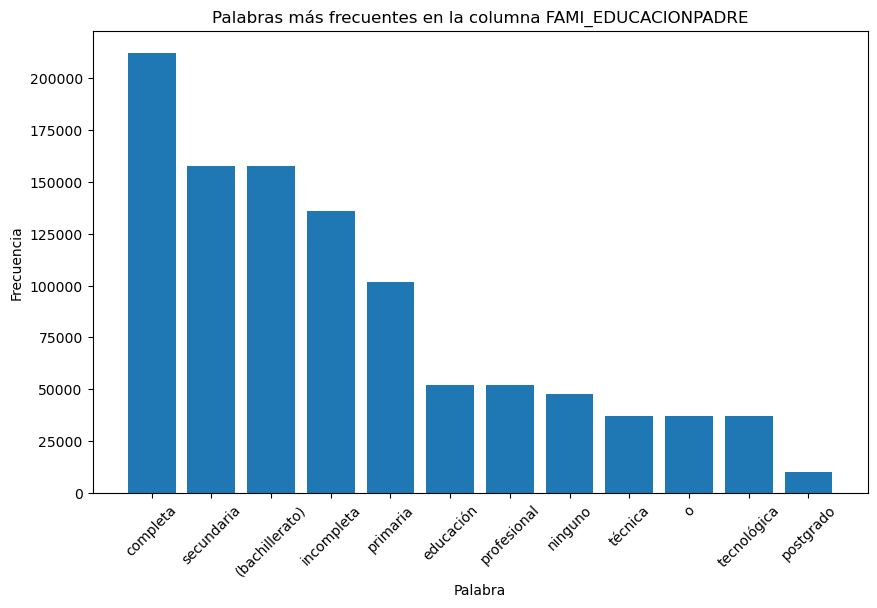

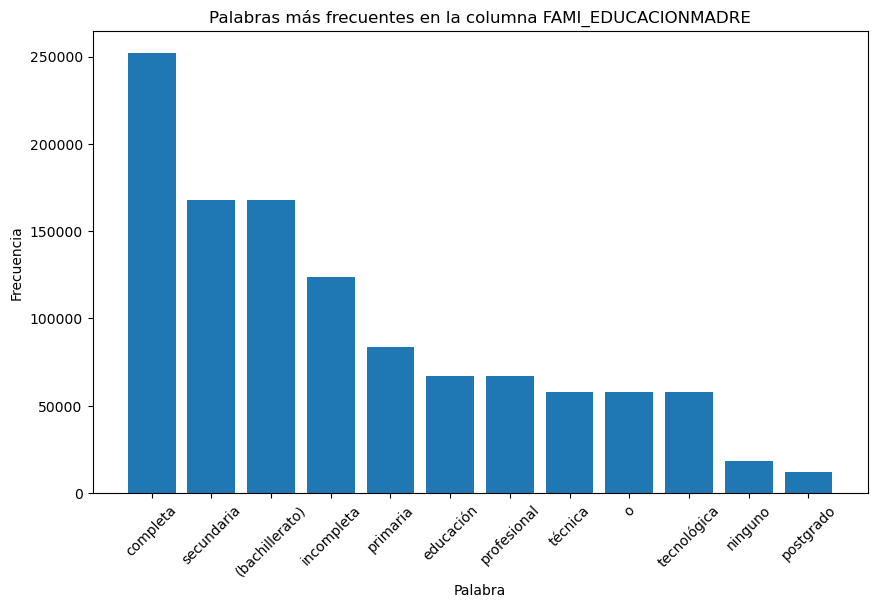

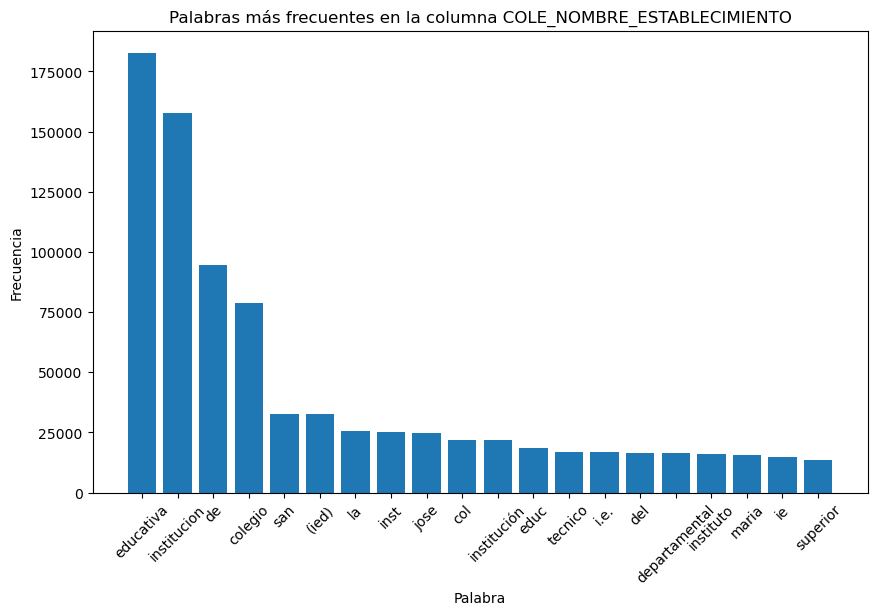

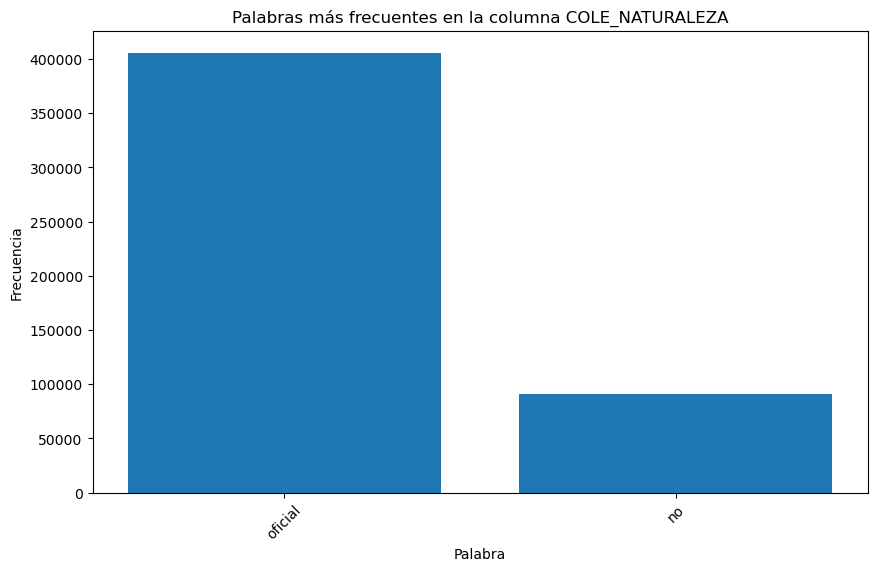

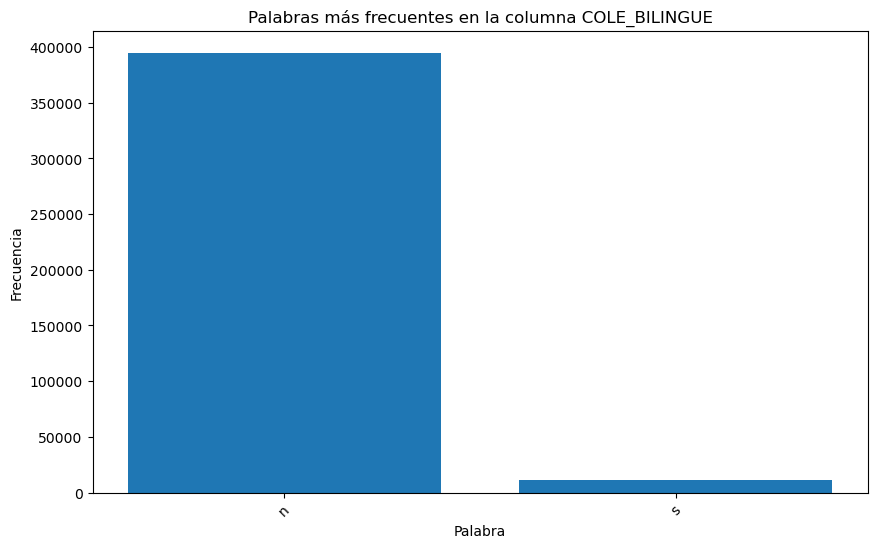

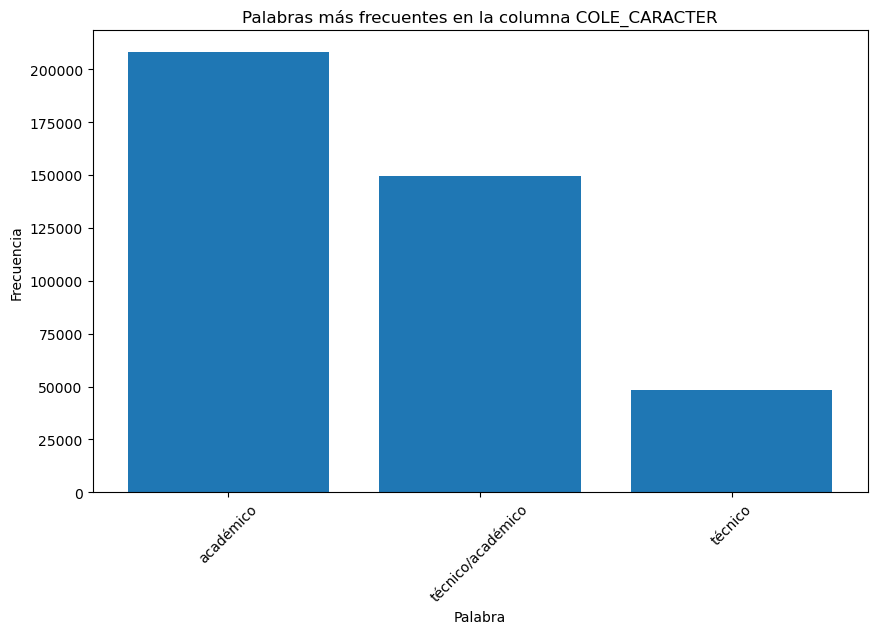

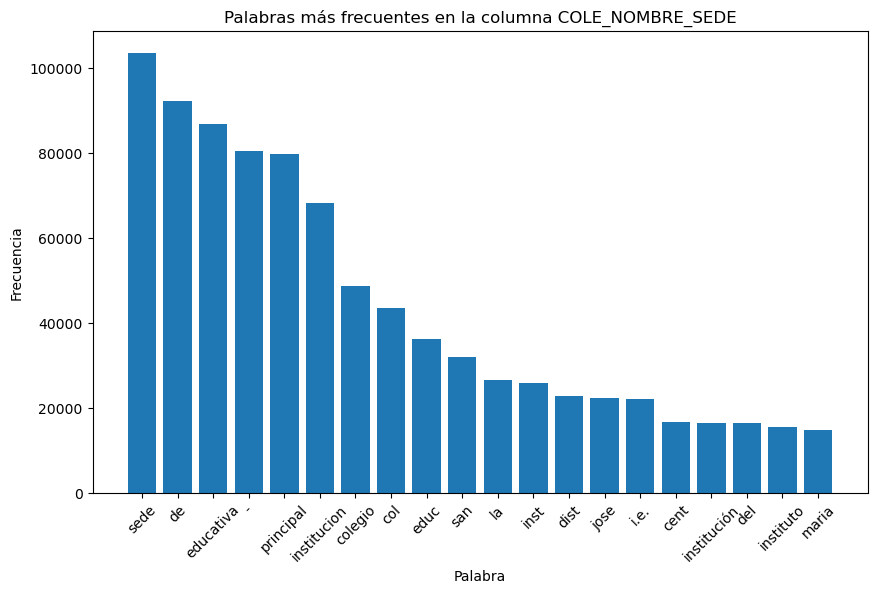

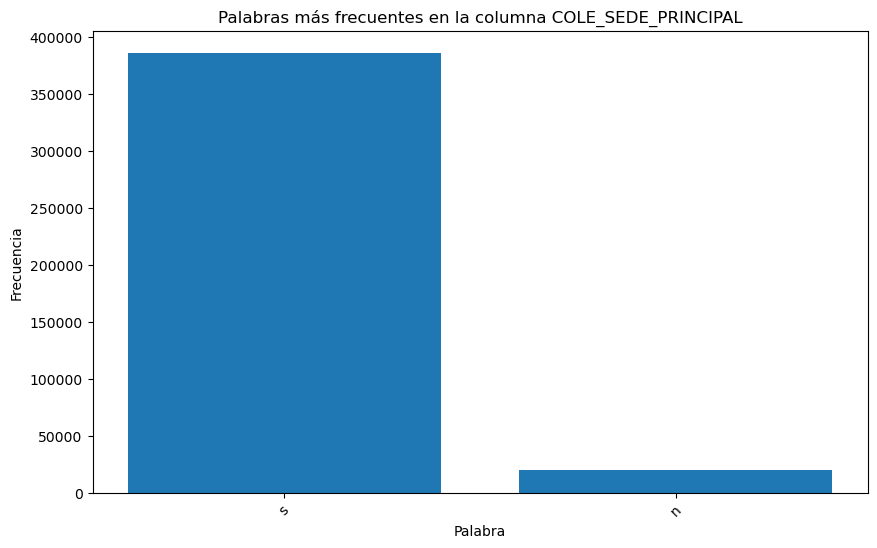

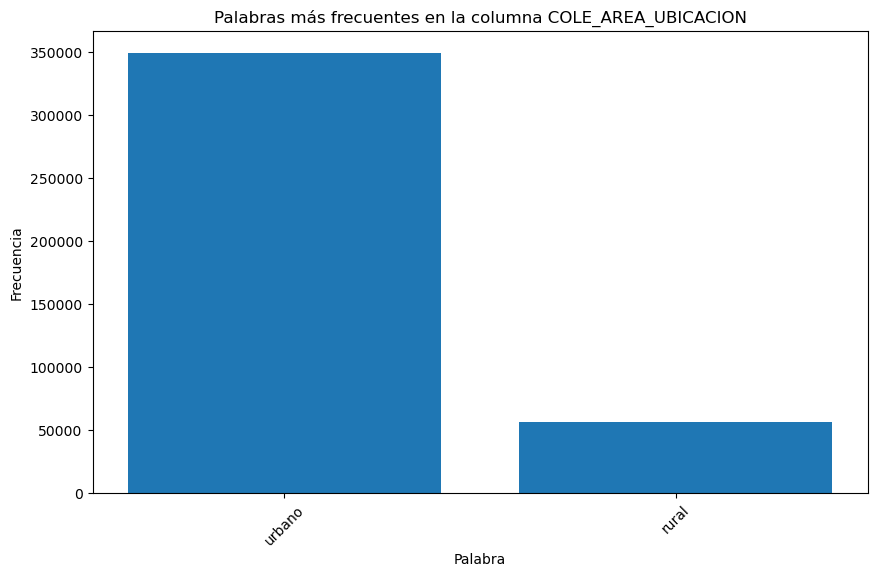

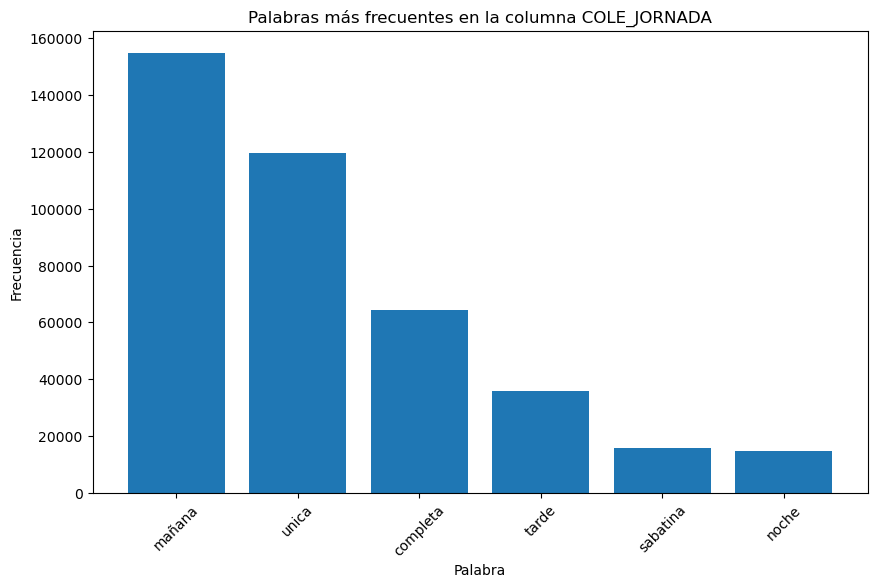

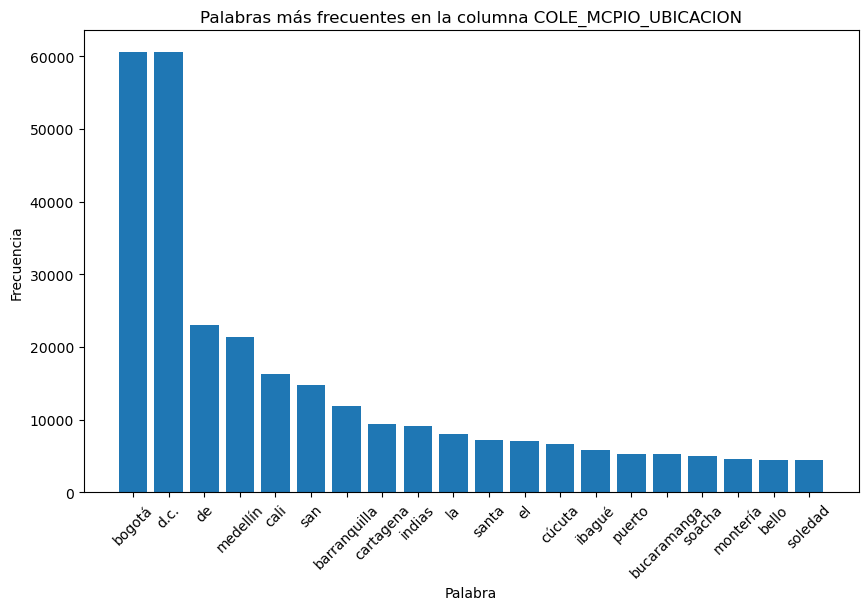

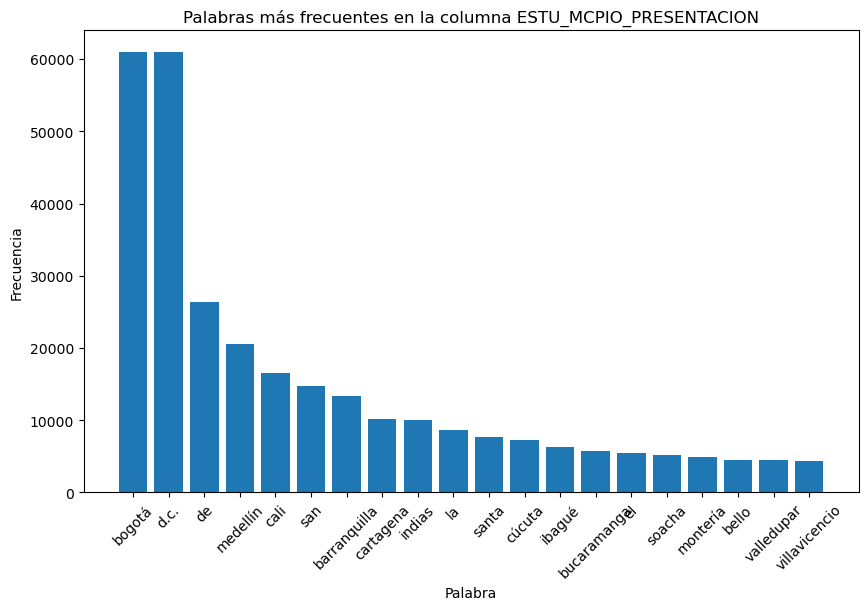

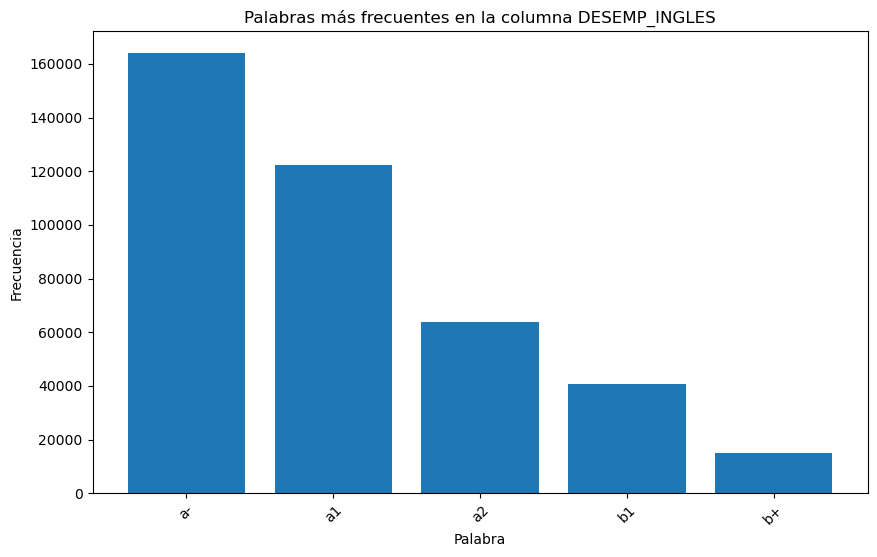

In [ ]:
analisis_frecuencia_palabras(df)

StatementMeta(, fa1c7968-8280-429c-bd14-ecdf3634ba72, 27, Finished, Available)

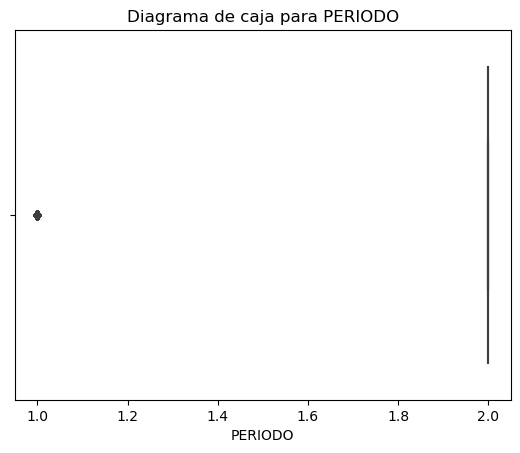

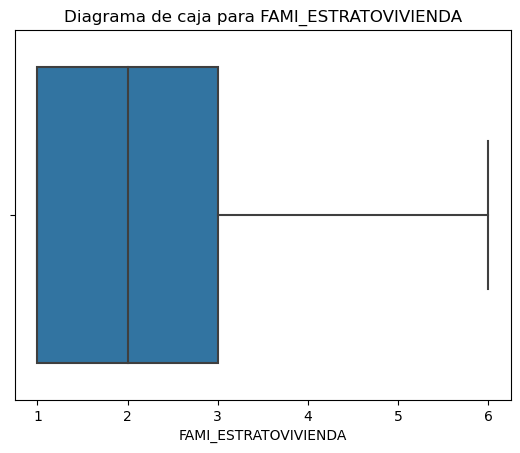

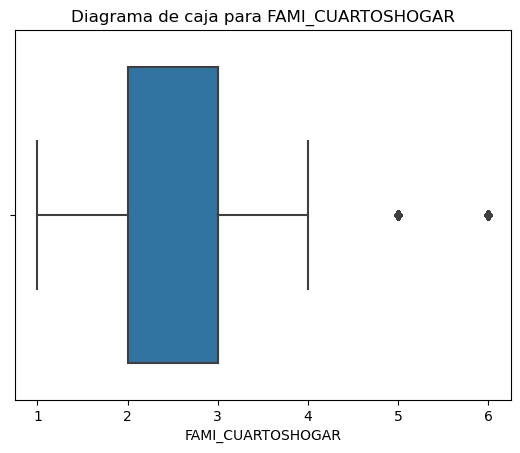

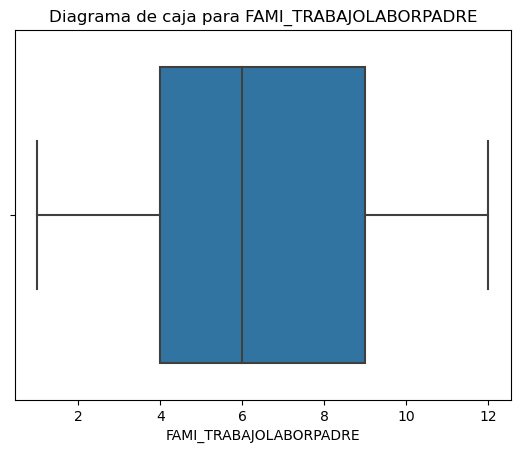

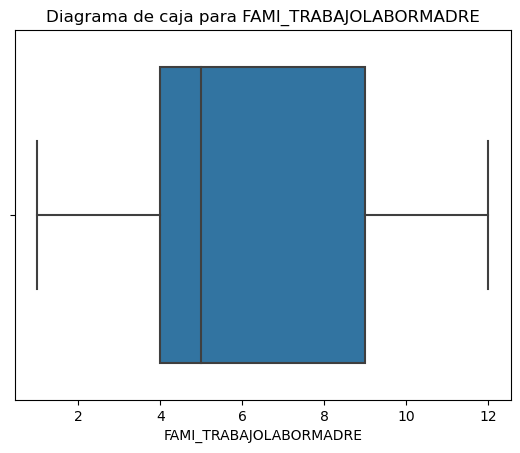

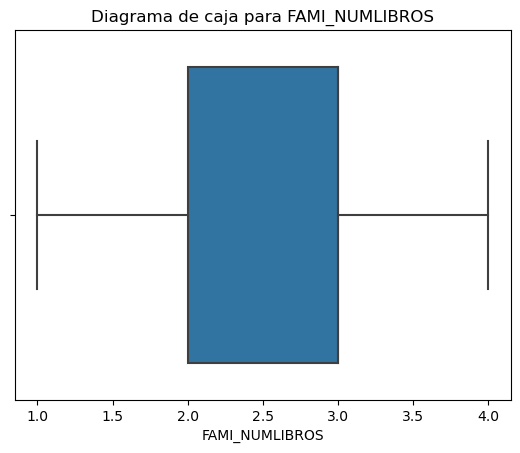

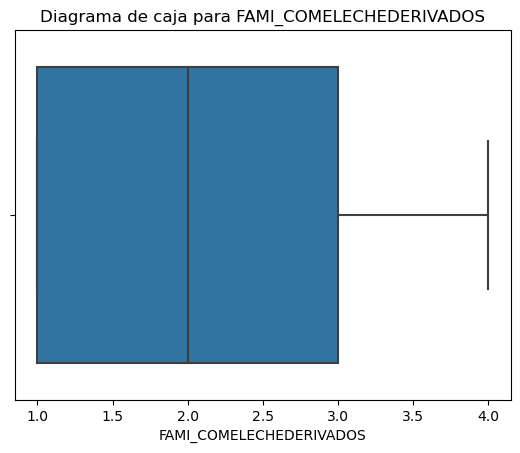

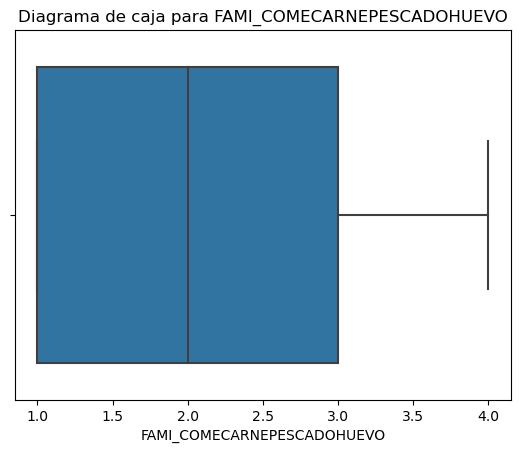

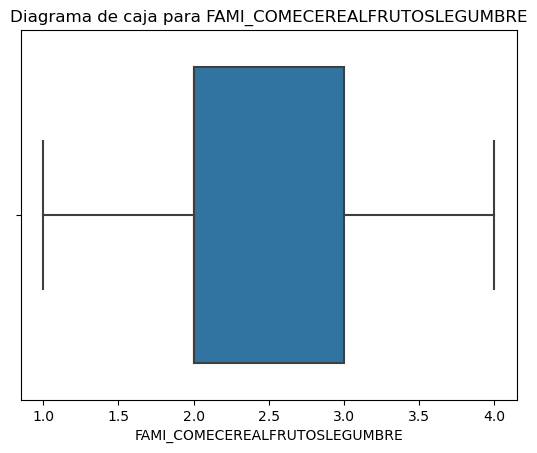

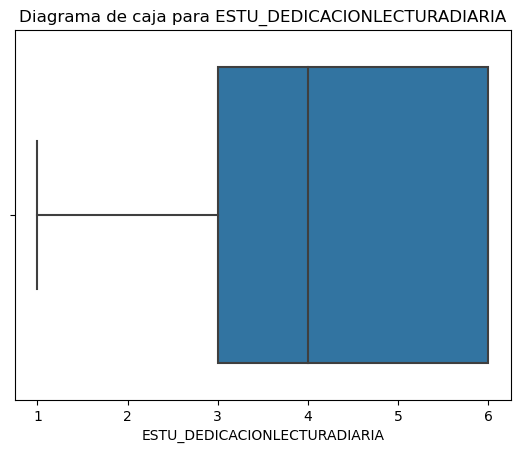

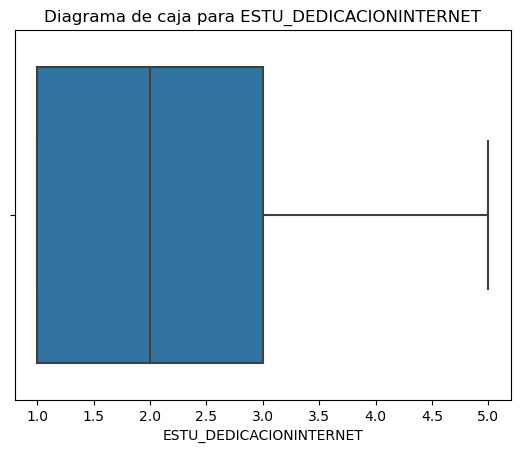

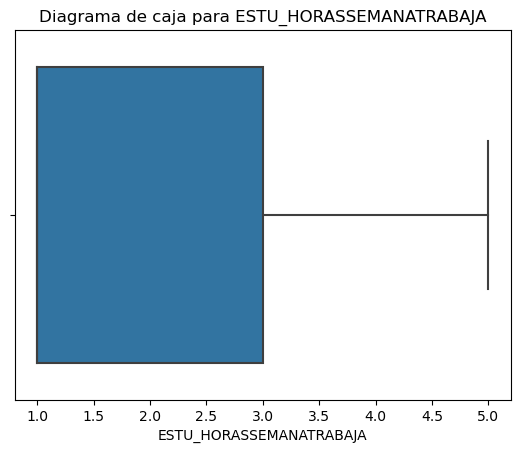

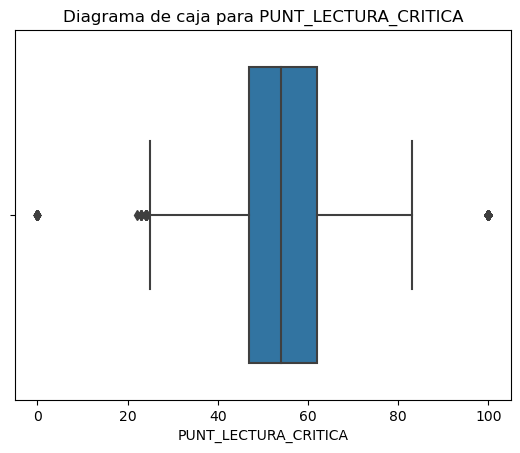

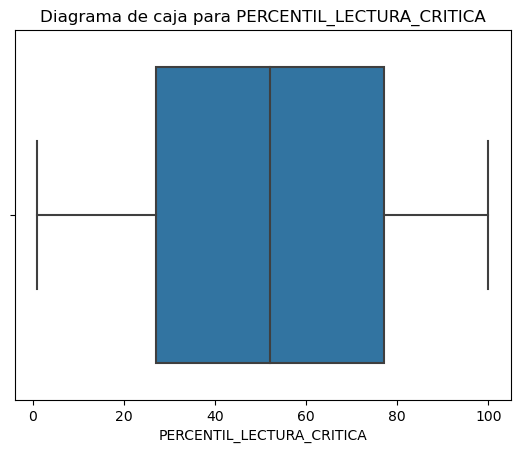

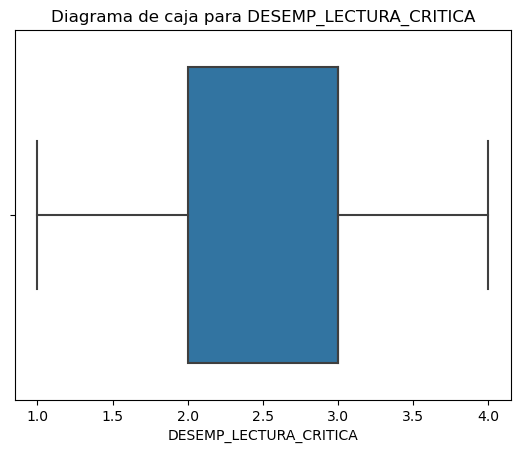

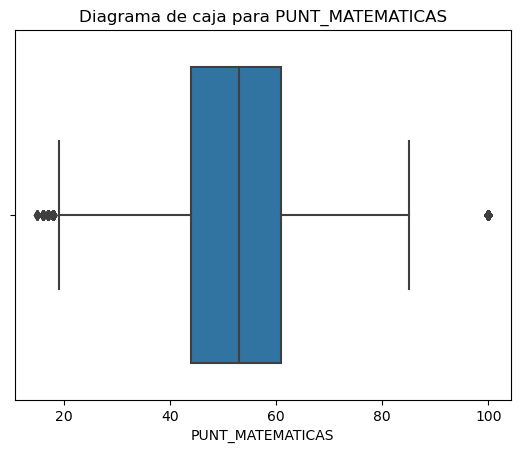

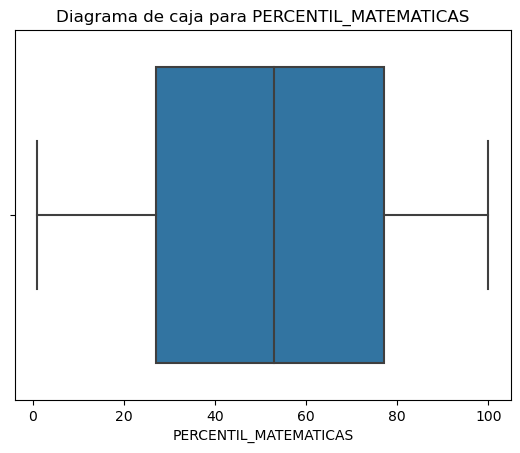

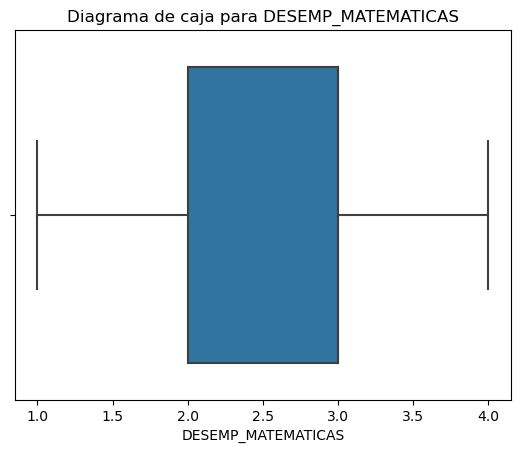

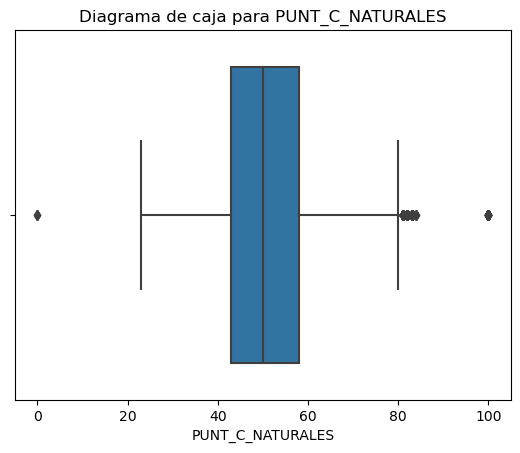

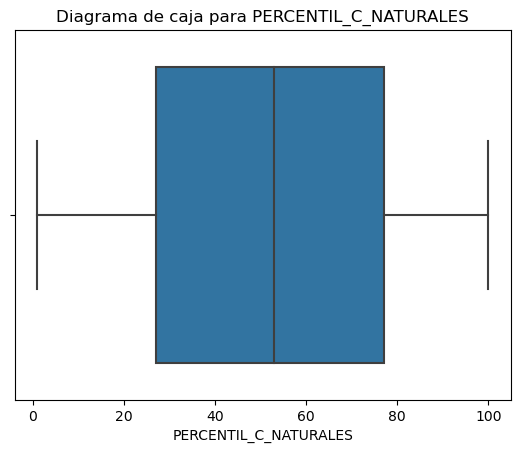

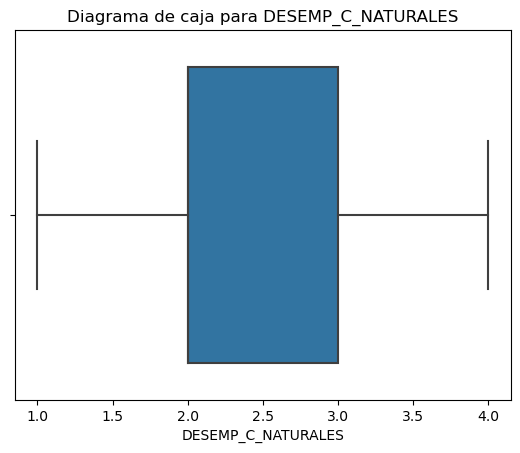

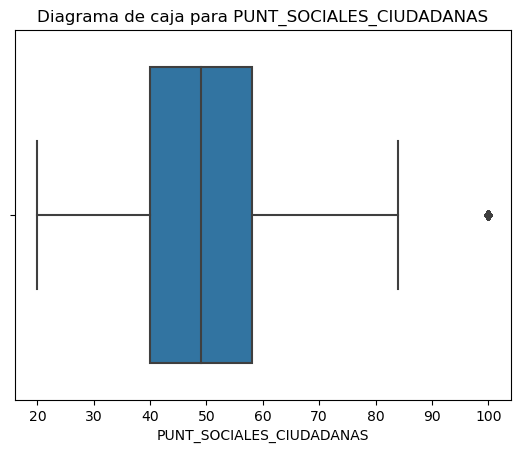

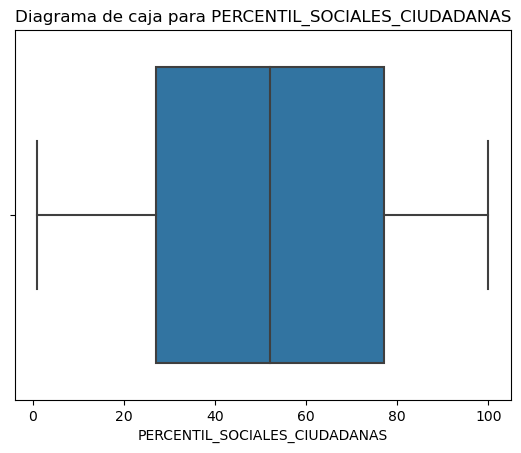

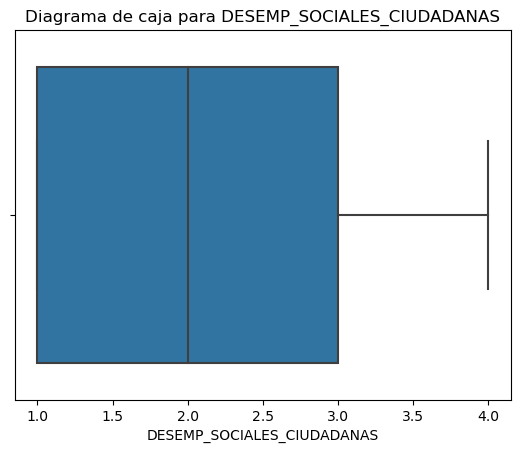

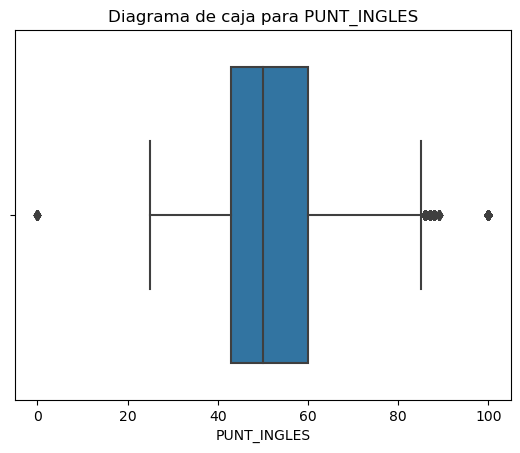

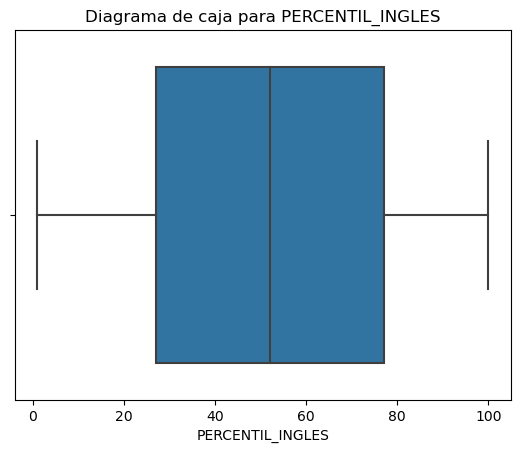

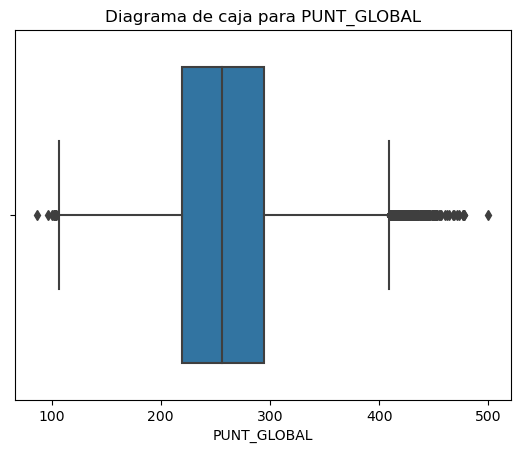

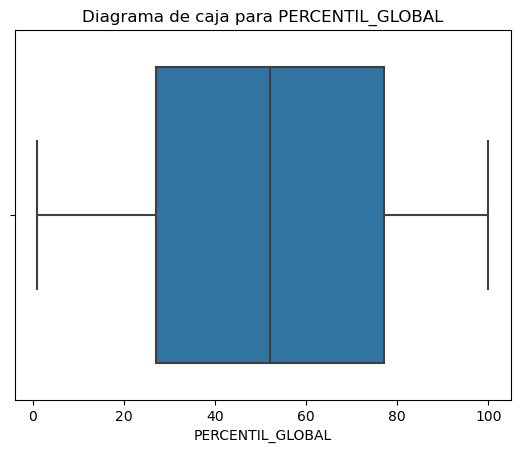

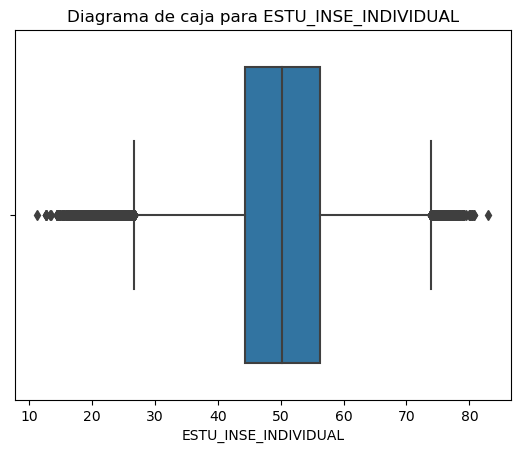

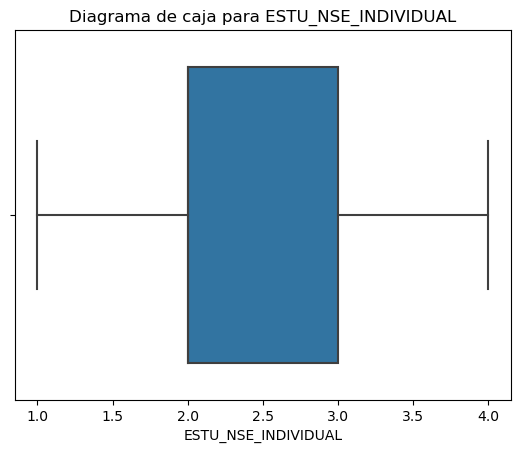

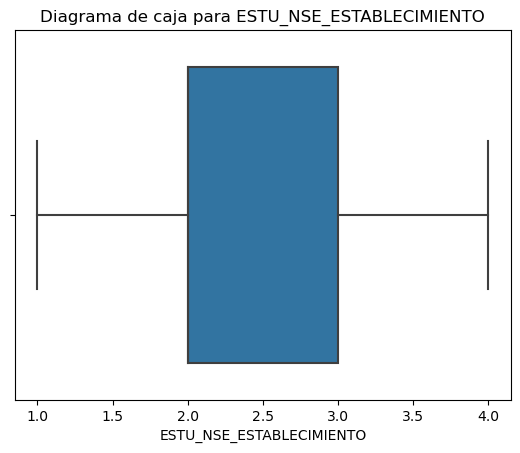

In [ ]:
boxplots_numericas(df)

StatementMeta(, fa1c7968-8280-429c-bd14-ecdf3634ba72, 28, Finished, Available)

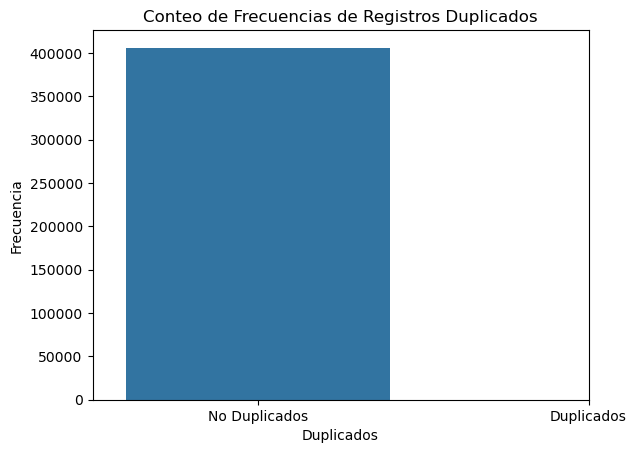

In [ ]:
hist_duplicados(df)

## <h2 align= 'center'><u>Análisis Descriptivo</u></h2>

StatementMeta(, fa1c7968-8280-429c-bd14-ecdf3634ba72, 29, Finished, Available)

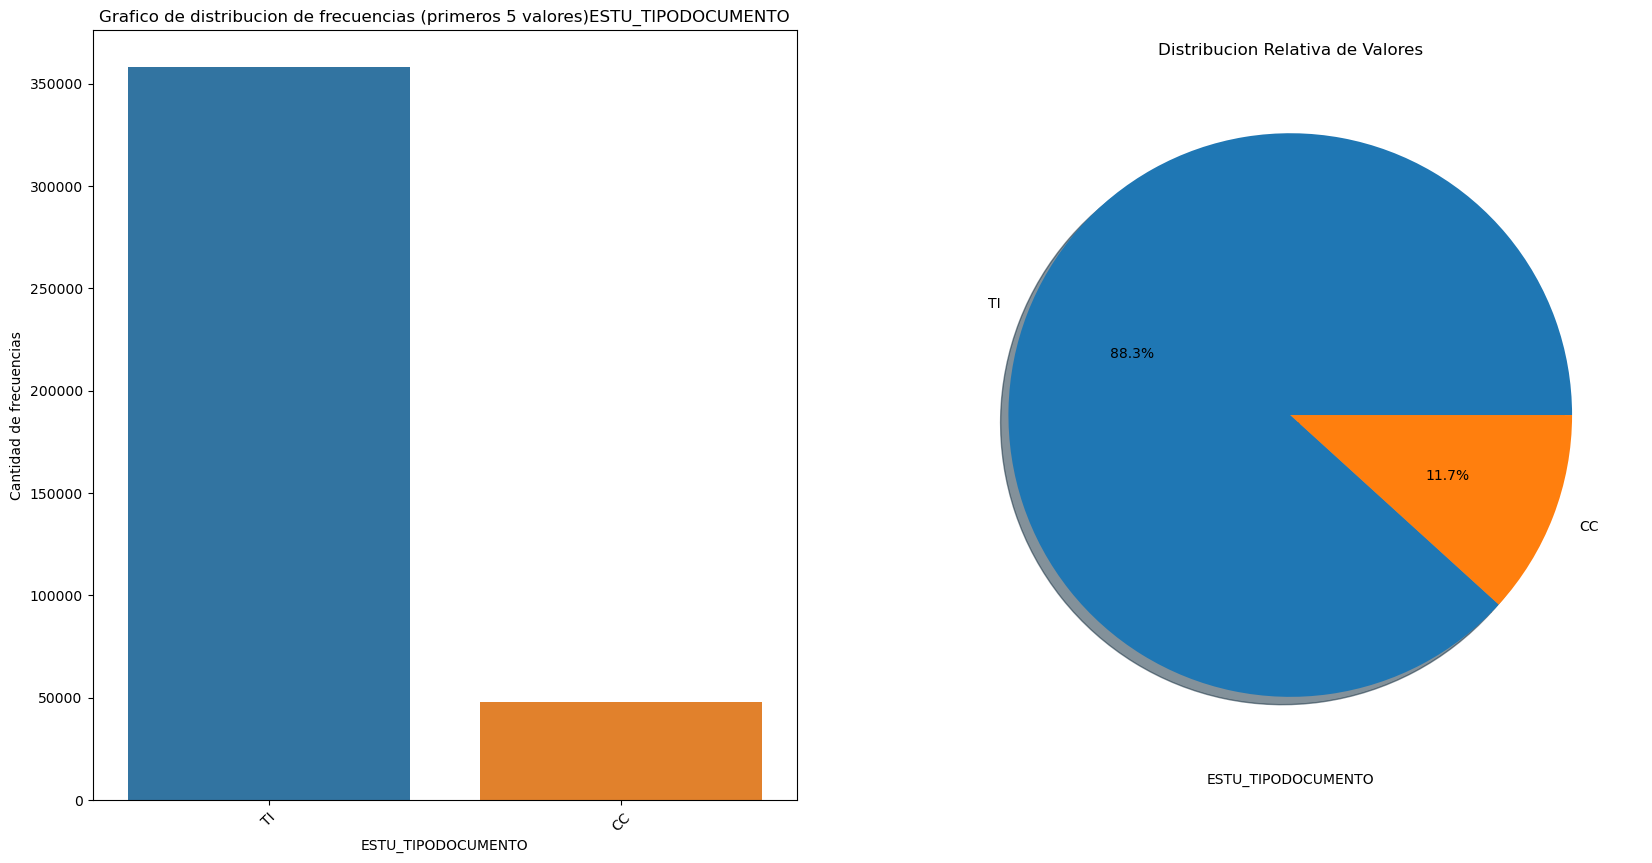



Estadisticas Basicas


count     405869
unique         2
top           TI
freq      358212
Name: ESTU_TIPODOCUMENTO, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




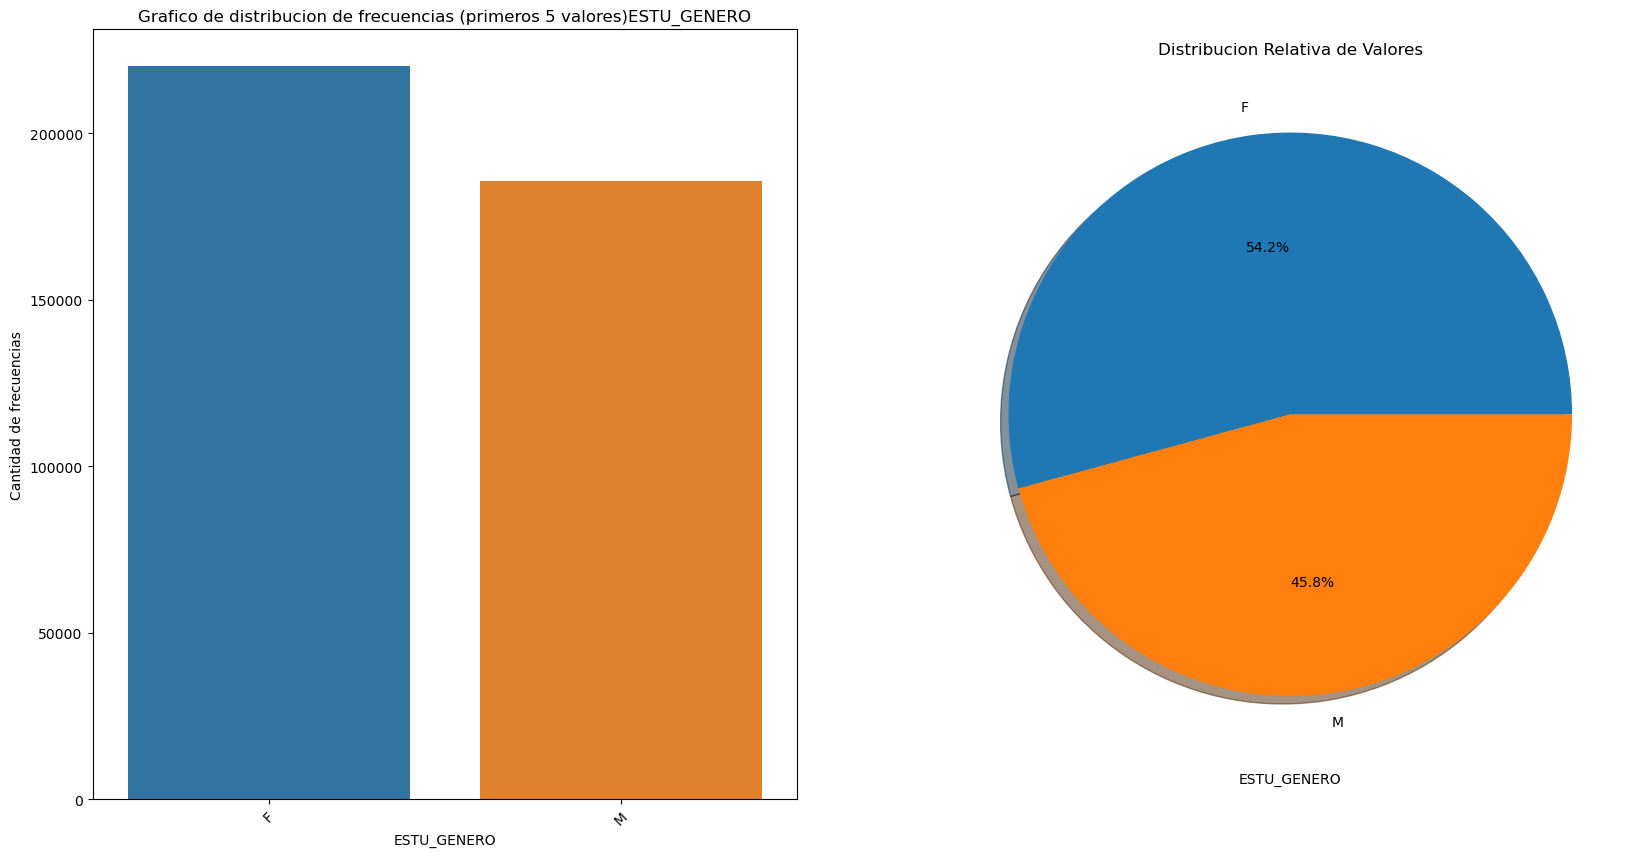



Estadisticas Basicas


count     405869
unique         2
top            F
freq      220145
Name: ESTU_GENERO, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




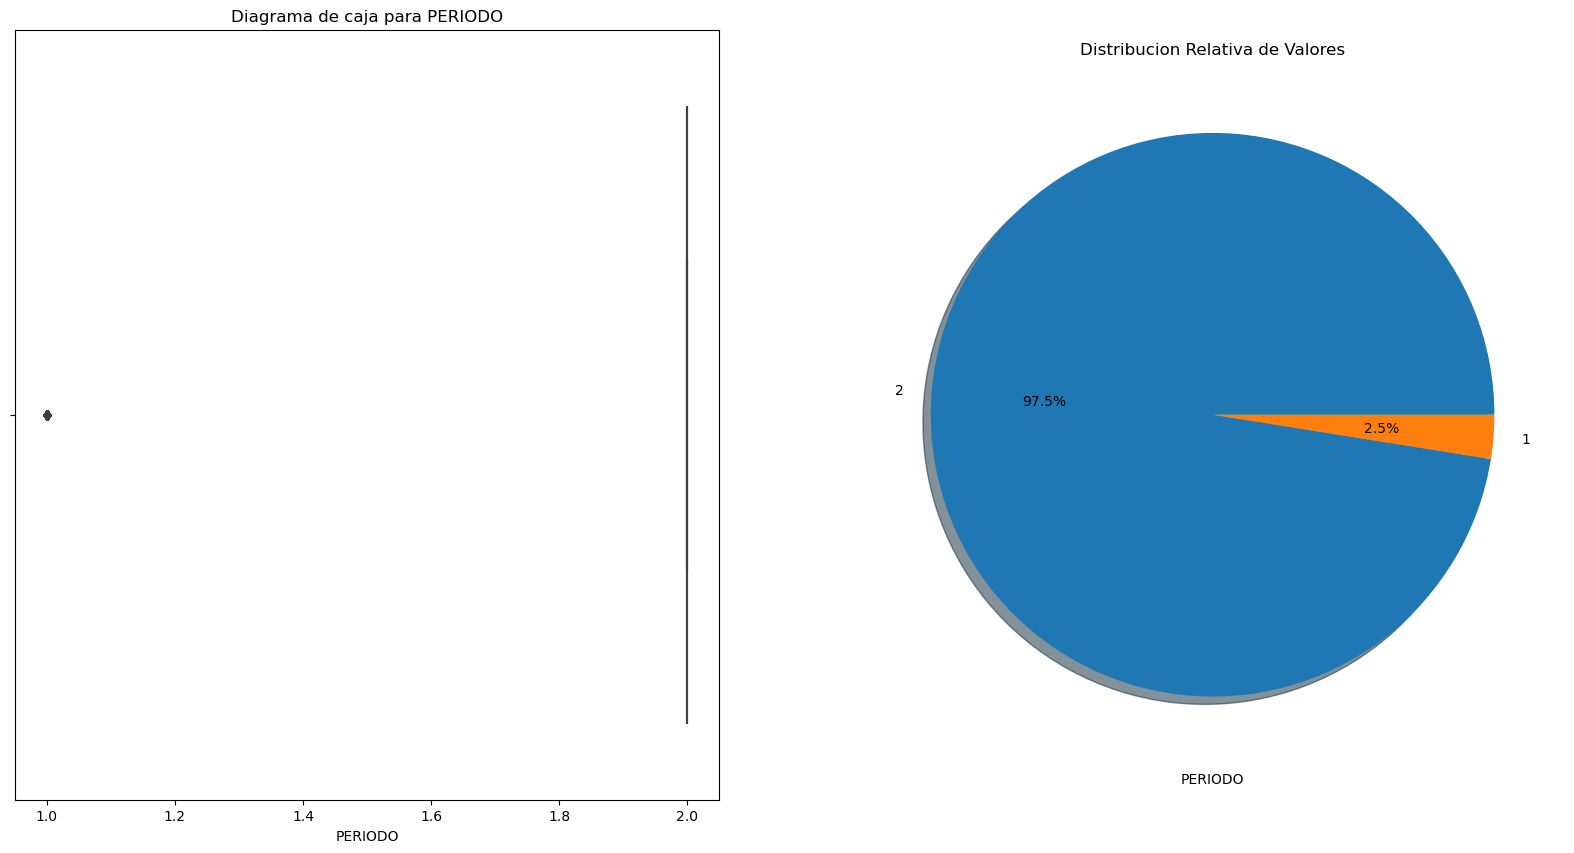



Estadisticas Basicas


count    405869.000000
mean          1.974864
std           0.156539
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: PERIODO, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




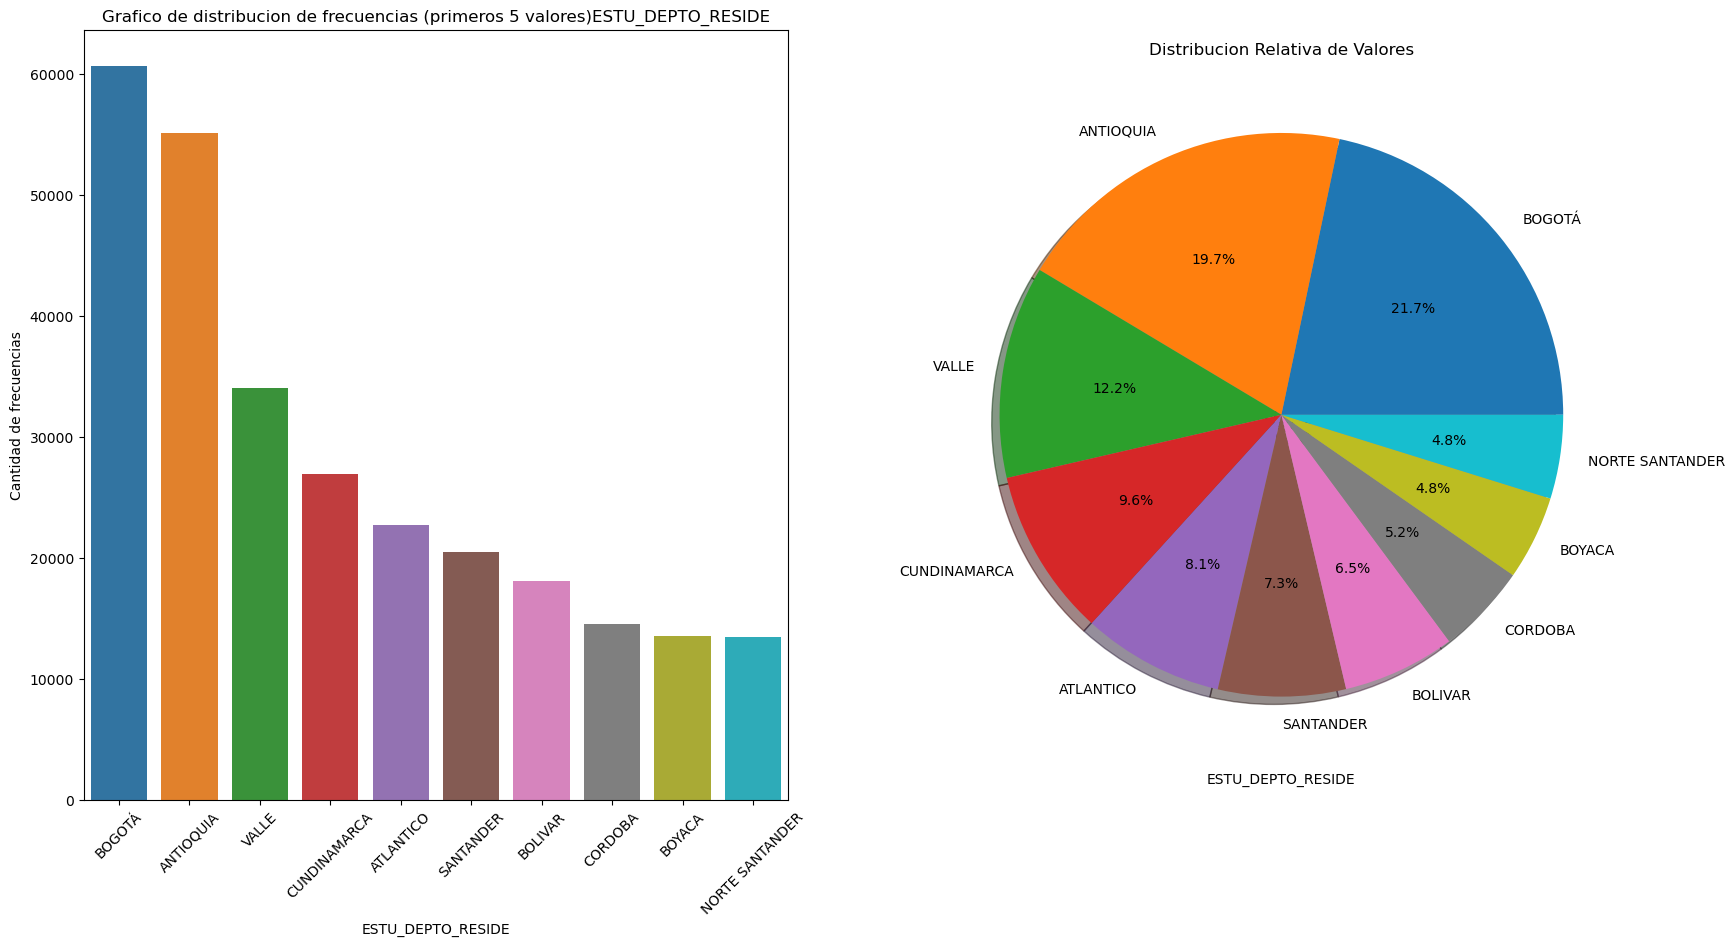



Estadisticas Basicas


count     405869
unique        34
top       BOGOTÁ
freq       60611
Name: ESTU_DEPTO_RESIDE, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




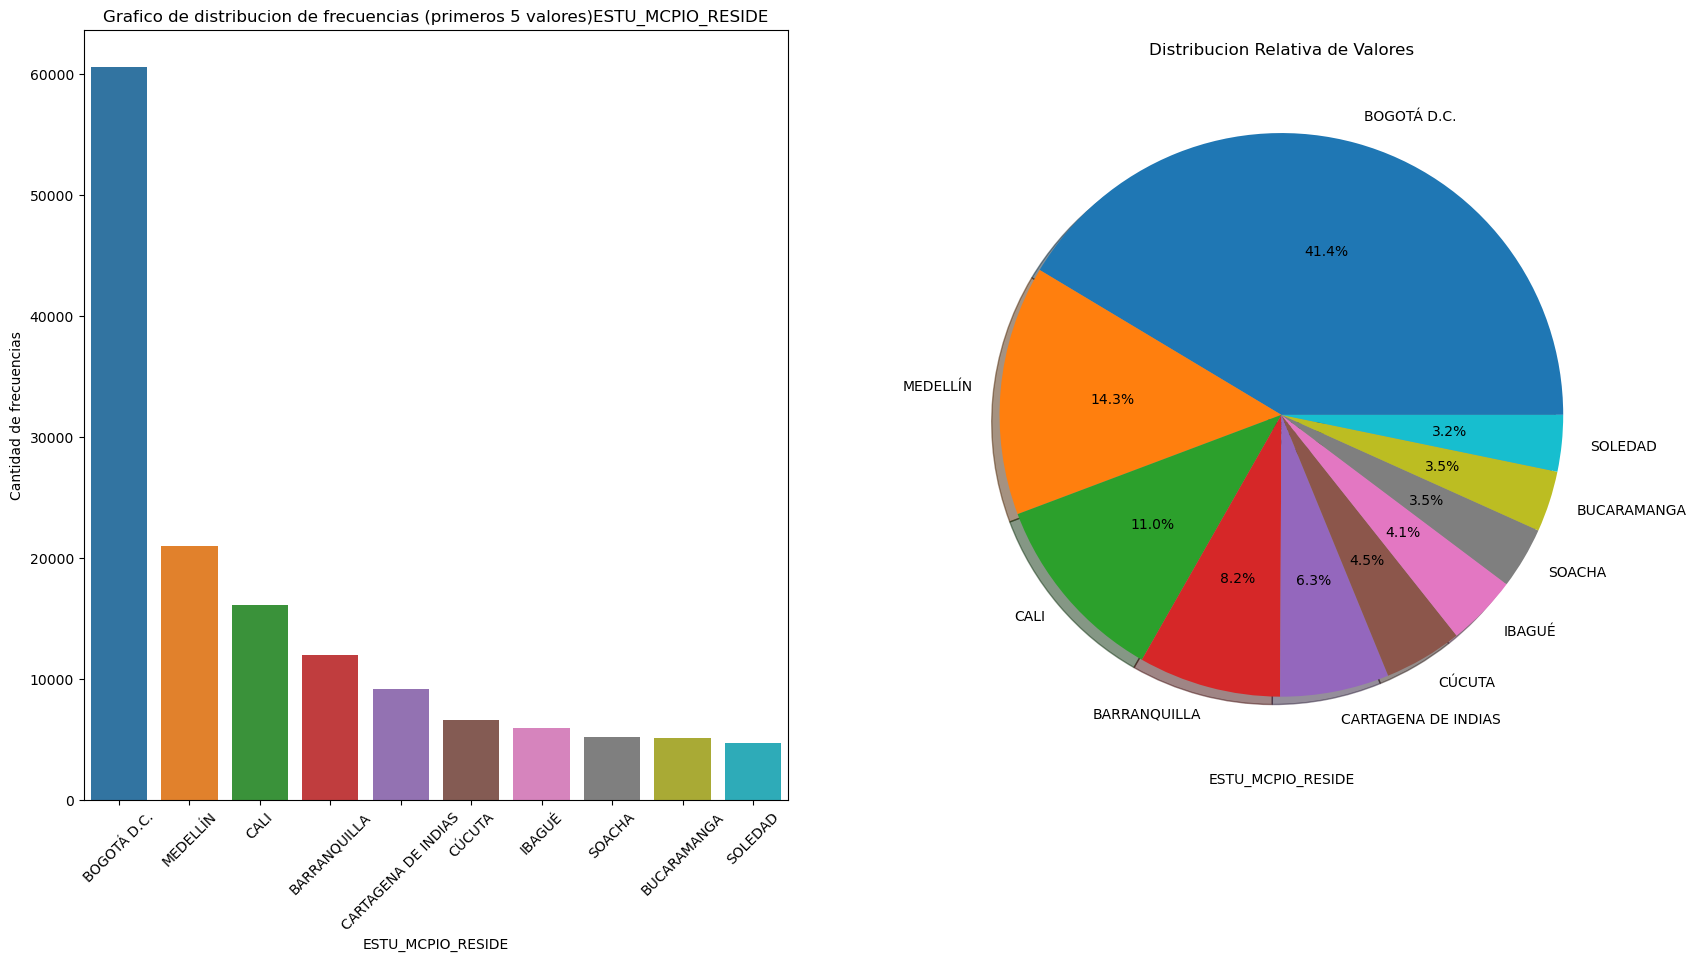



Estadisticas Basicas


count          405869
unique           1030
top       BOGOTÁ D.C.
freq            60611
Name: ESTU_MCPIO_RESIDE, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




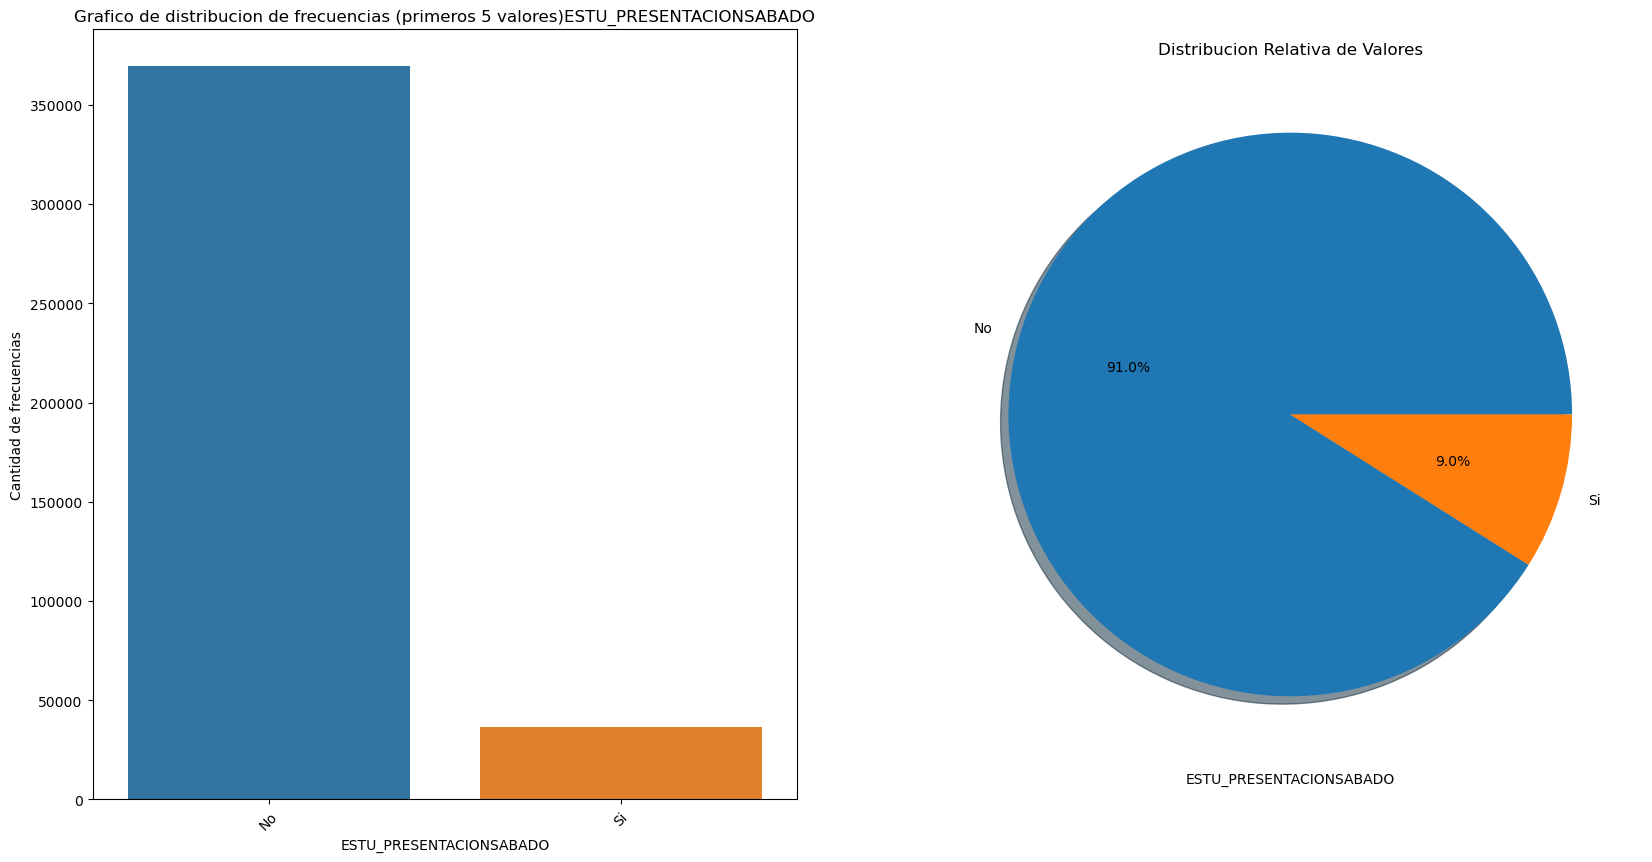



Estadisticas Basicas


count     405869
unique         2
top           No
freq      369501
Name: ESTU_PRESENTACIONSABADO, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




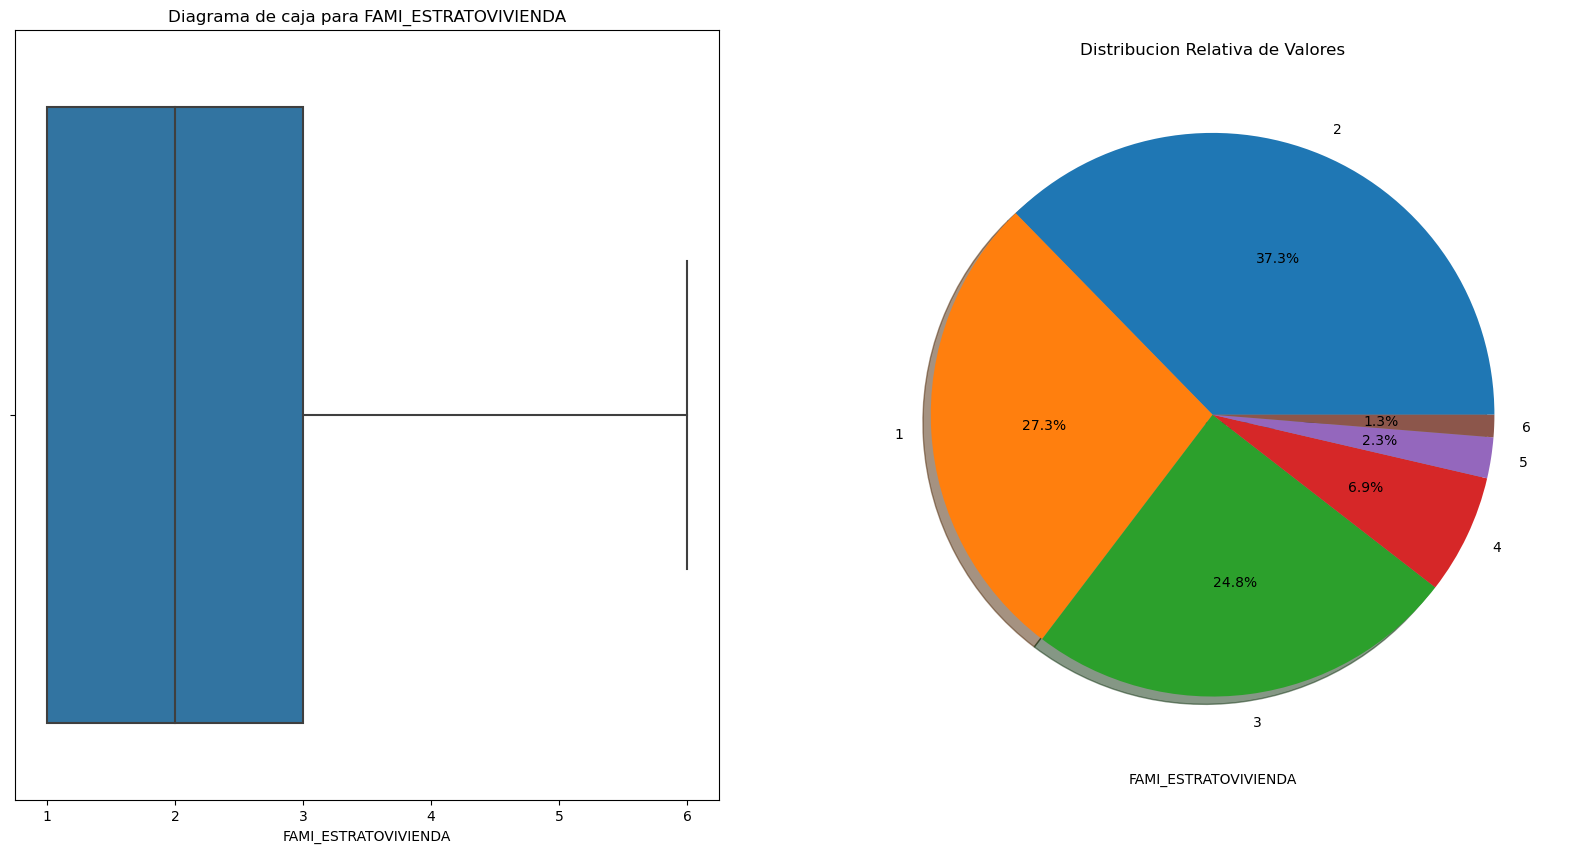



Estadisticas Basicas


count    405869.000000
mean          2.233970
std           1.076012
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           6.000000
Name: FAMI_ESTRATOVIVIENDA, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




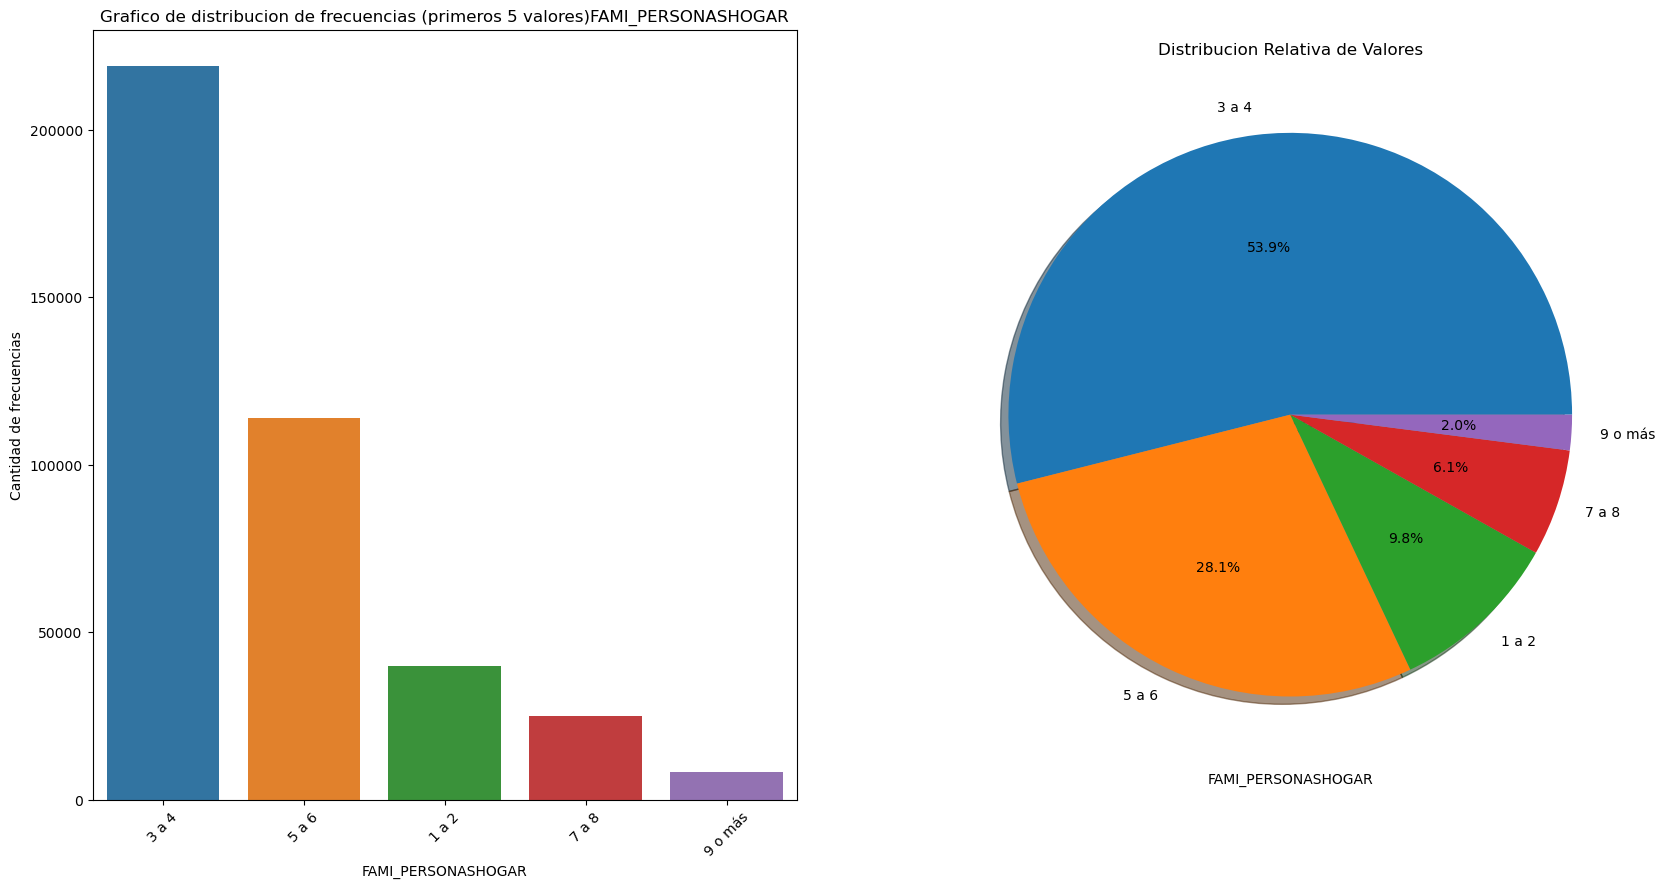



Estadisticas Basicas


count     405869
unique         5
top        3 a 4
freq      218908
Name: FAMI_PERSONASHOGAR, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




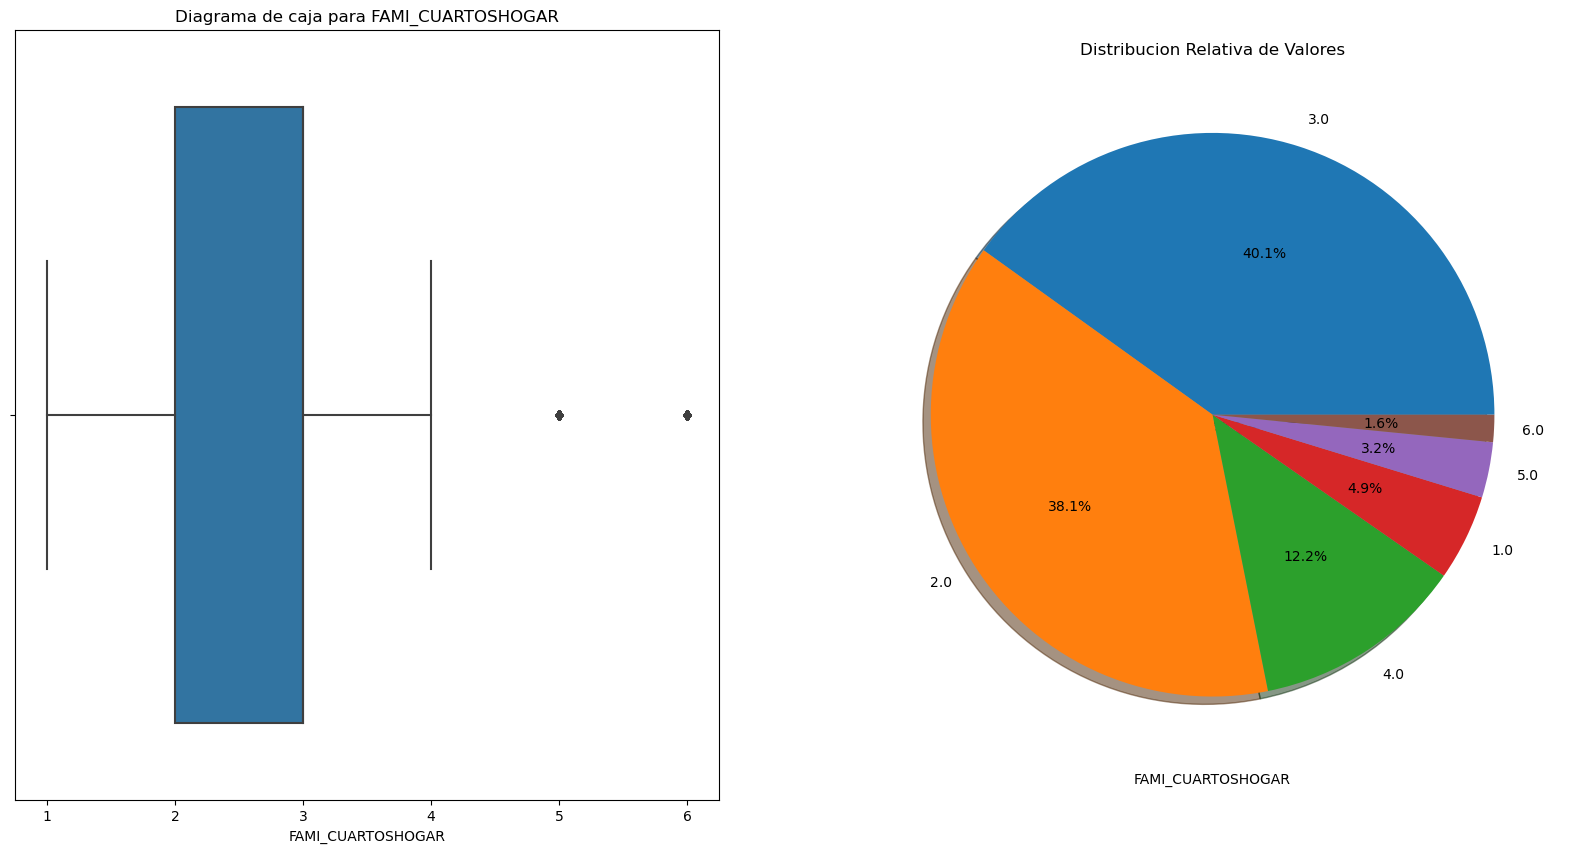



Estadisticas Basicas


count    405869.000000
mean          2.752634
std           0.951952
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: FAMI_CUARTOSHOGAR, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




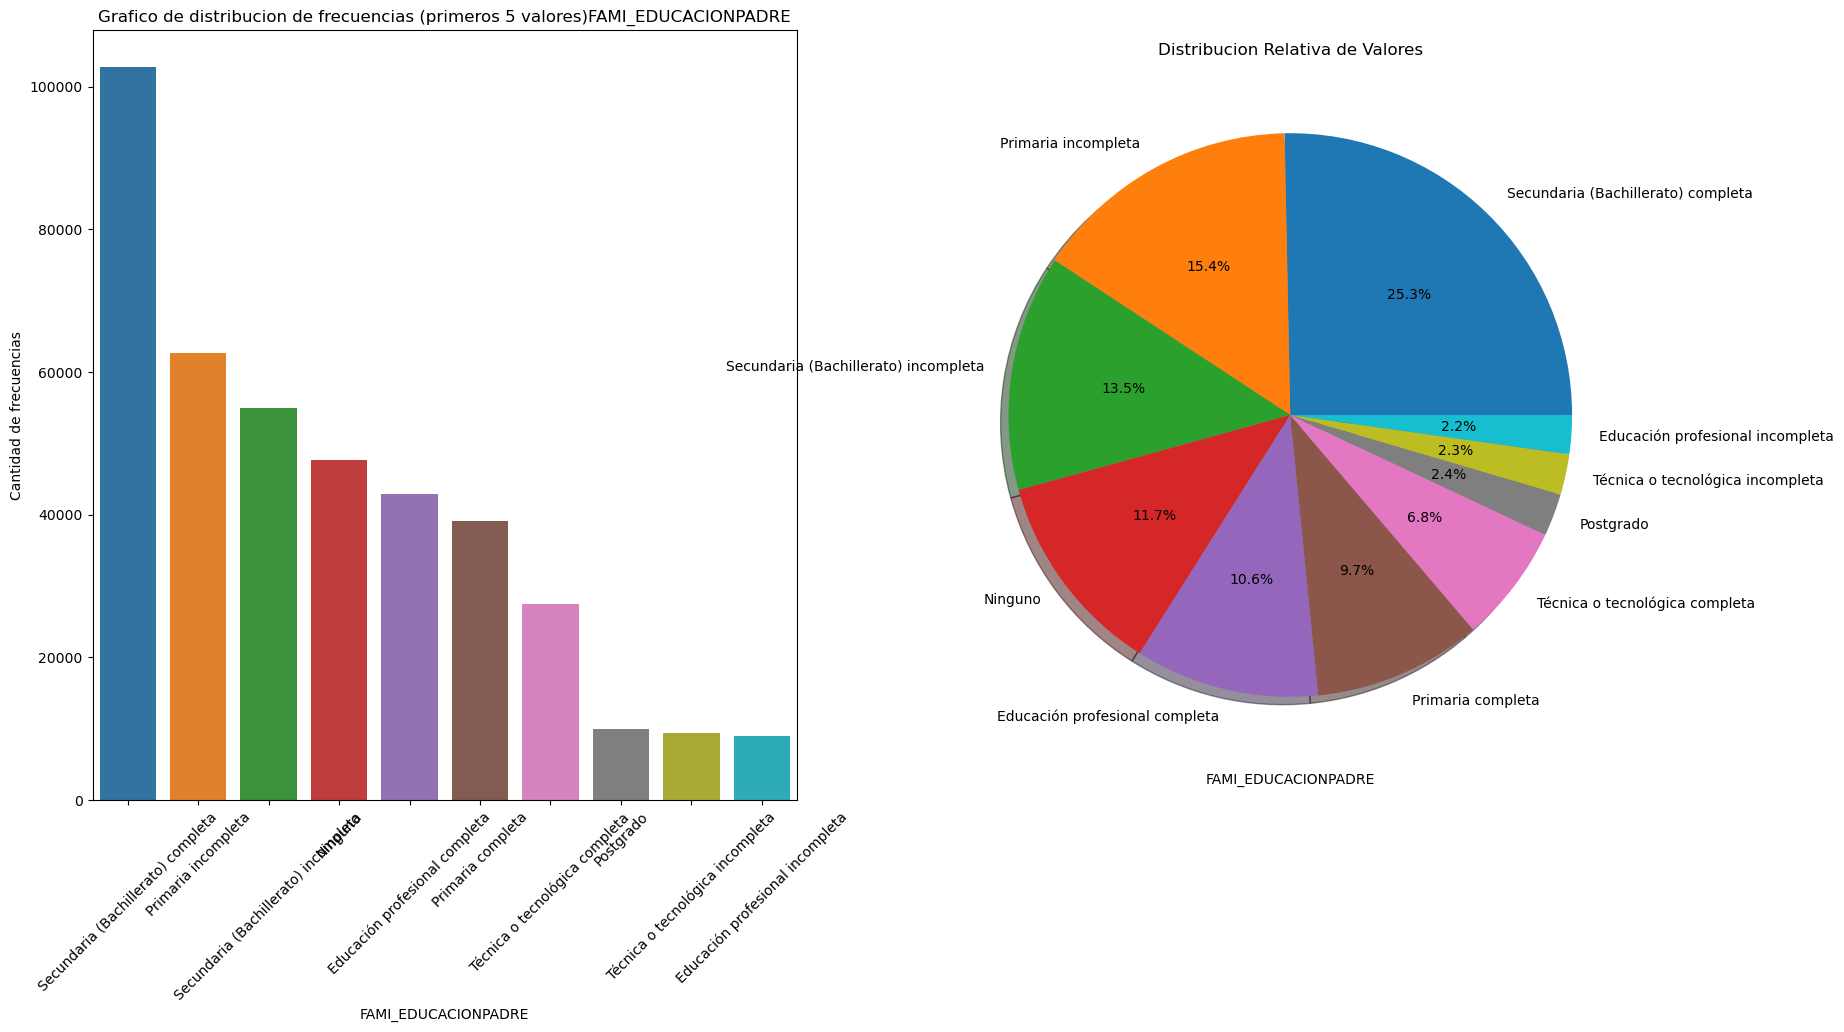



Estadisticas Basicas


count                                 405869
unique                                    10
top       Secundaria (Bachillerato) completa
freq                                  102776
Name: FAMI_EDUCACIONPADRE, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




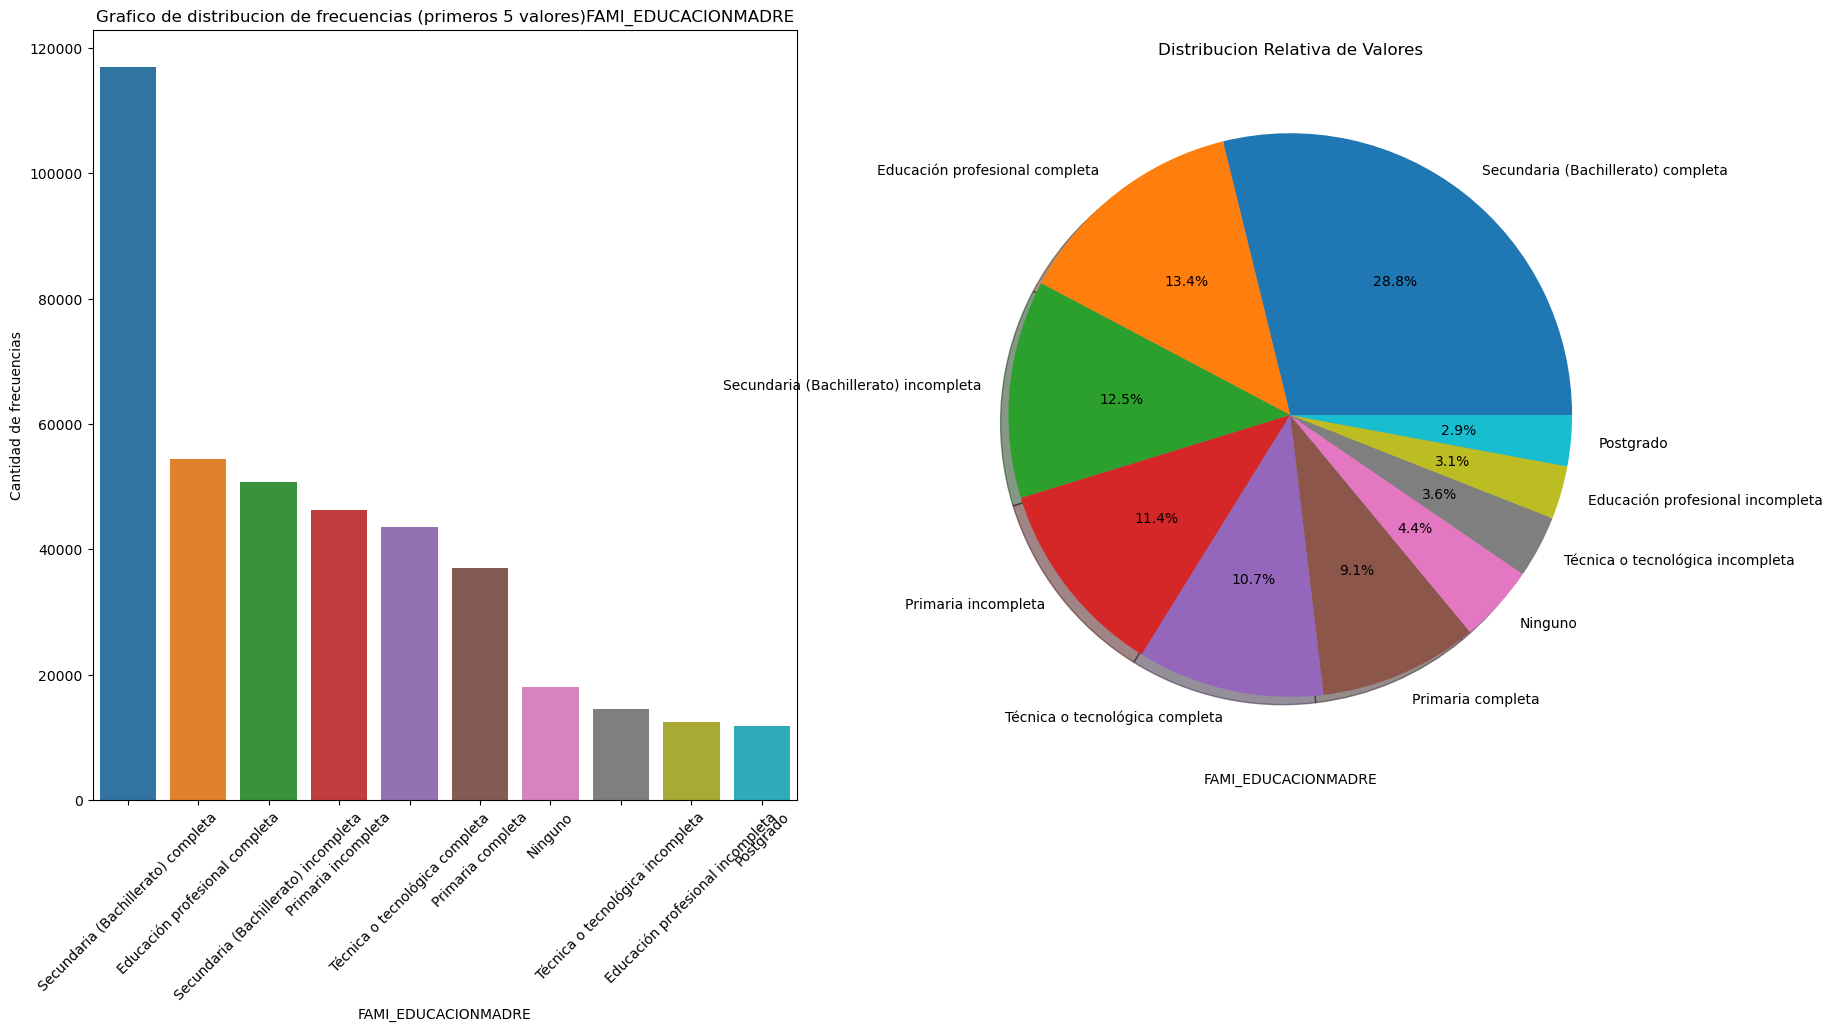



Estadisticas Basicas


count                                 405869
unique                                    10
top       Secundaria (Bachillerato) completa
freq                                  117029
Name: FAMI_EDUCACIONMADRE, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




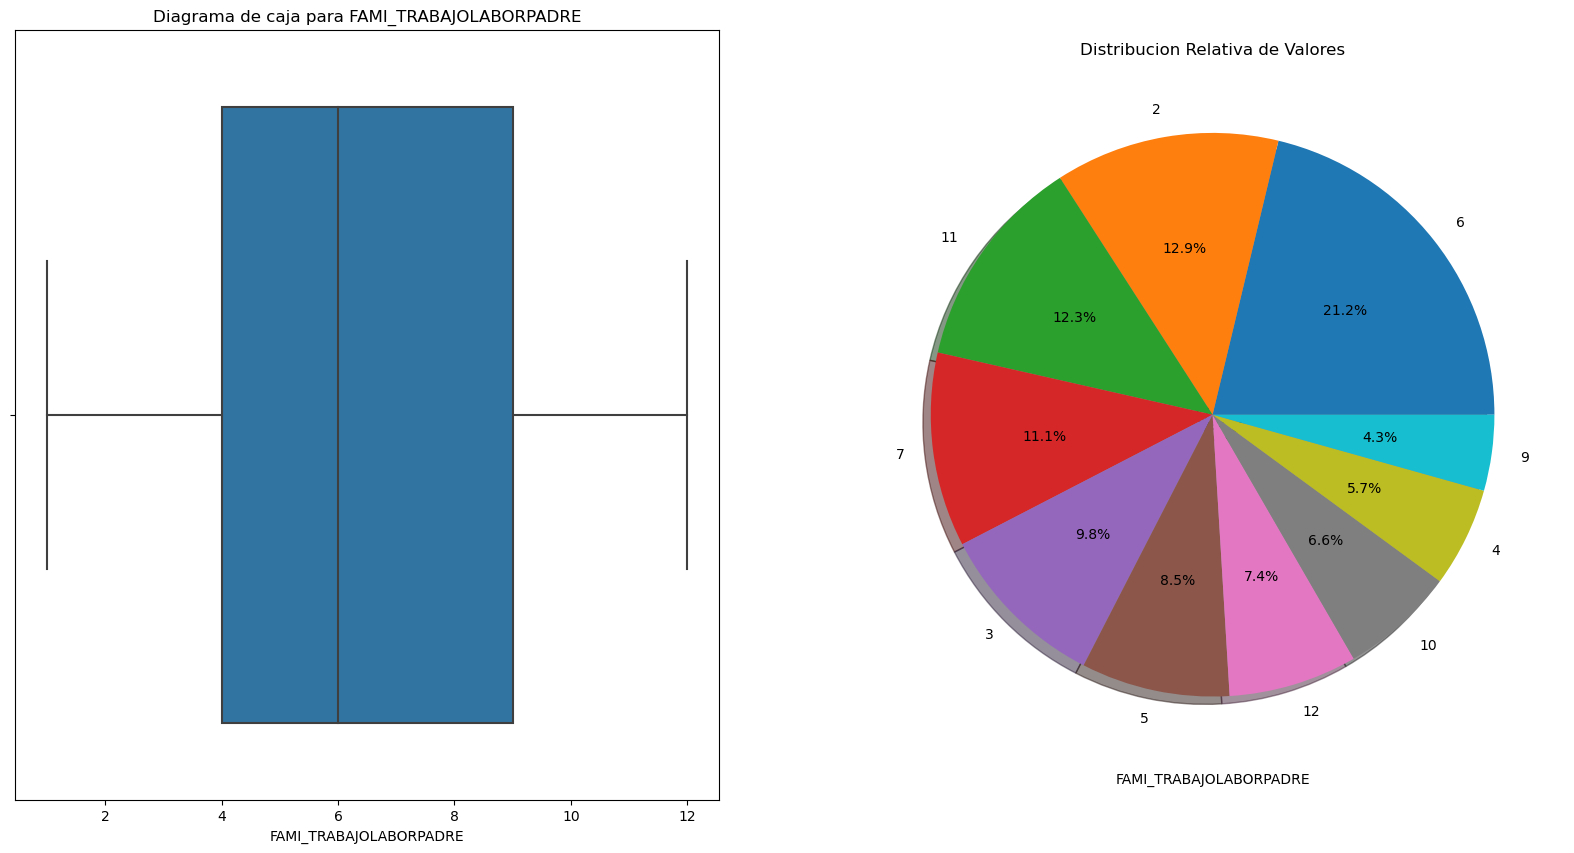



Estadisticas Basicas


count    405869.000000
mean          6.431220
std           3.259646
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: FAMI_TRABAJOLABORPADRE, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




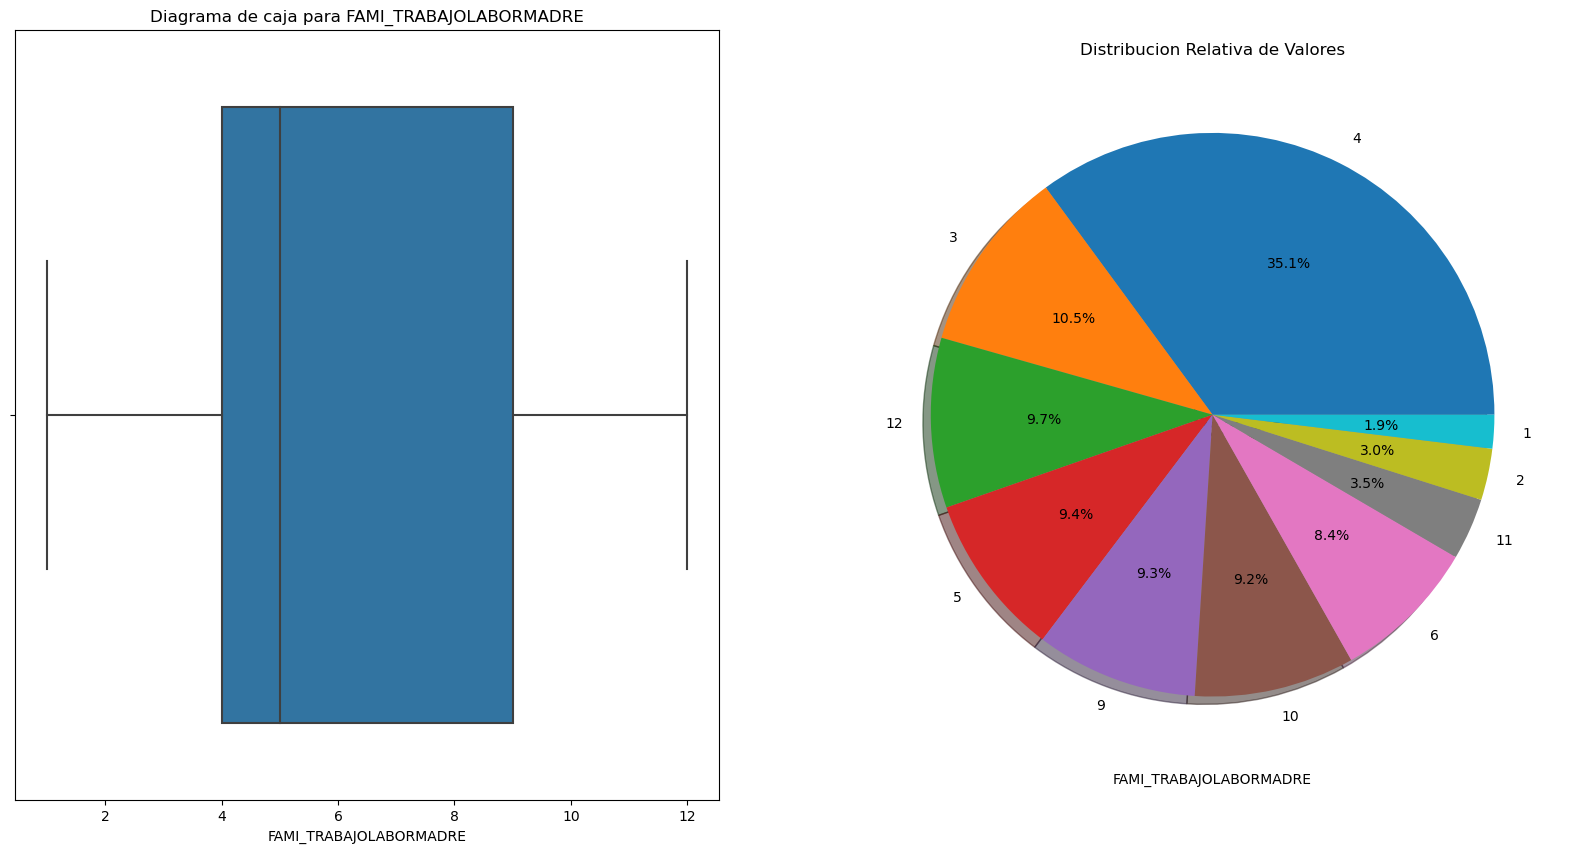



Estadisticas Basicas


count    405869.000000
mean          6.107542
std           3.150086
min           1.000000
25%           4.000000
50%           5.000000
75%           9.000000
max          12.000000
Name: FAMI_TRABAJOLABORMADRE, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




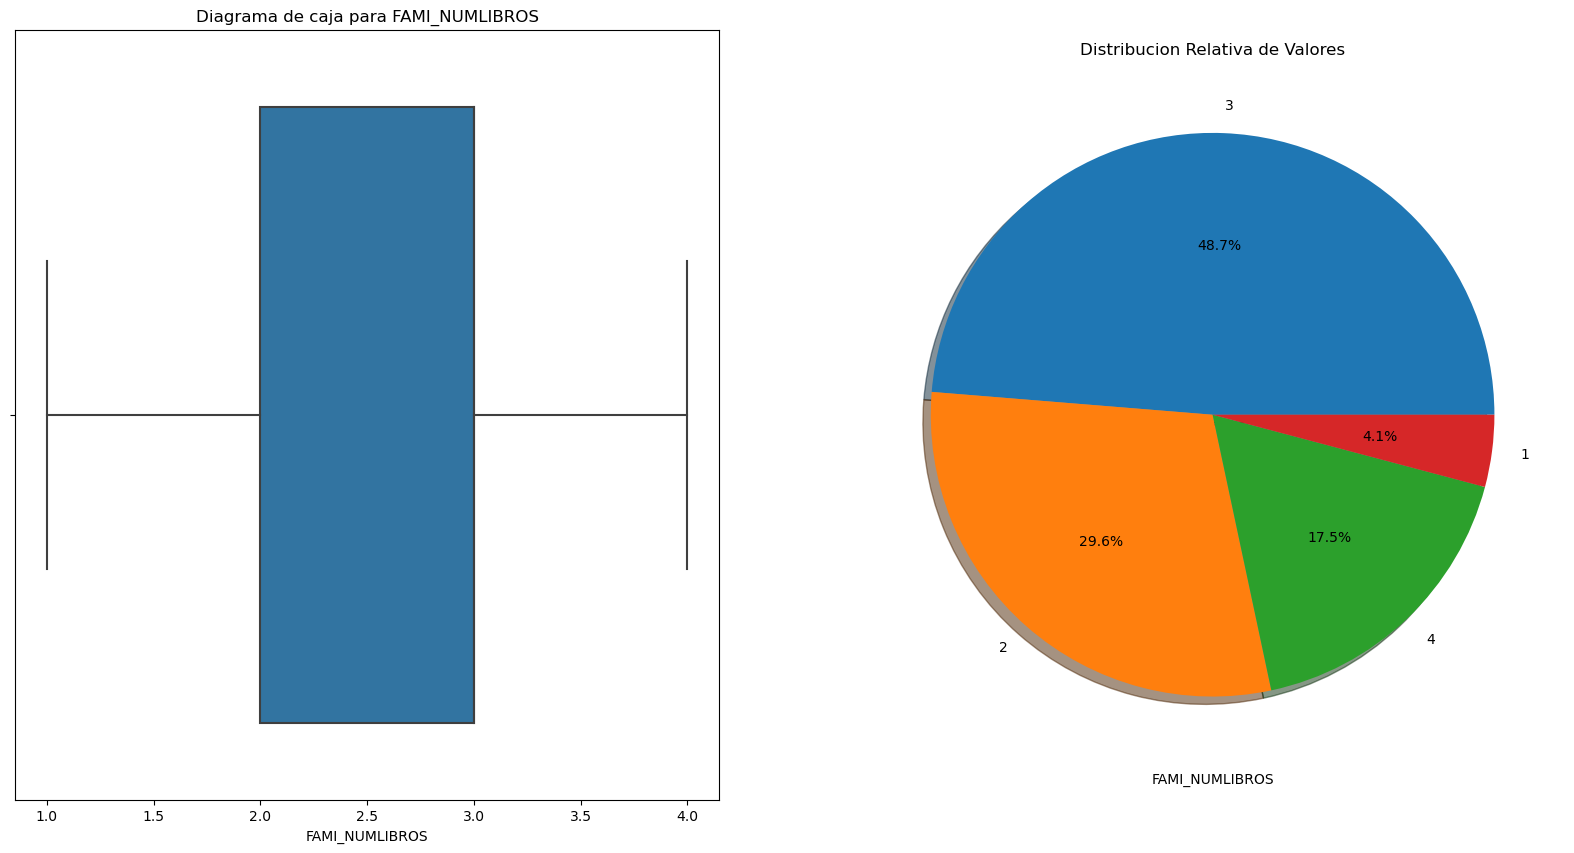



Estadisticas Basicas


count    405869.000000
mean          2.796420
std           0.771558
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: FAMI_NUMLIBROS, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




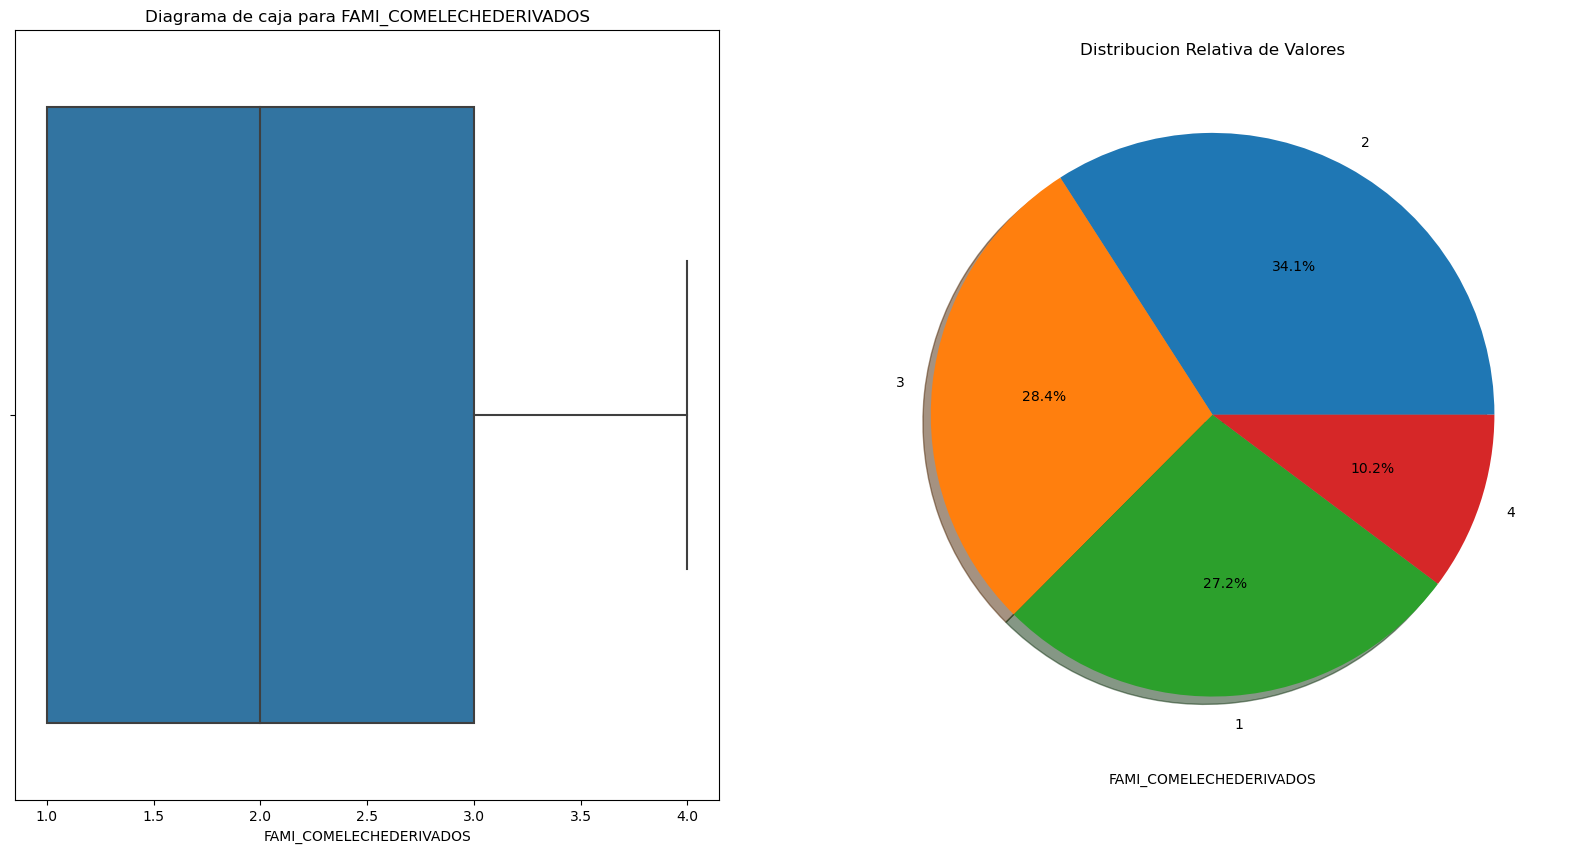



Estadisticas Basicas


count    405869.000000
mean          2.217176
std           0.958780
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: FAMI_COMELECHEDERIVADOS, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




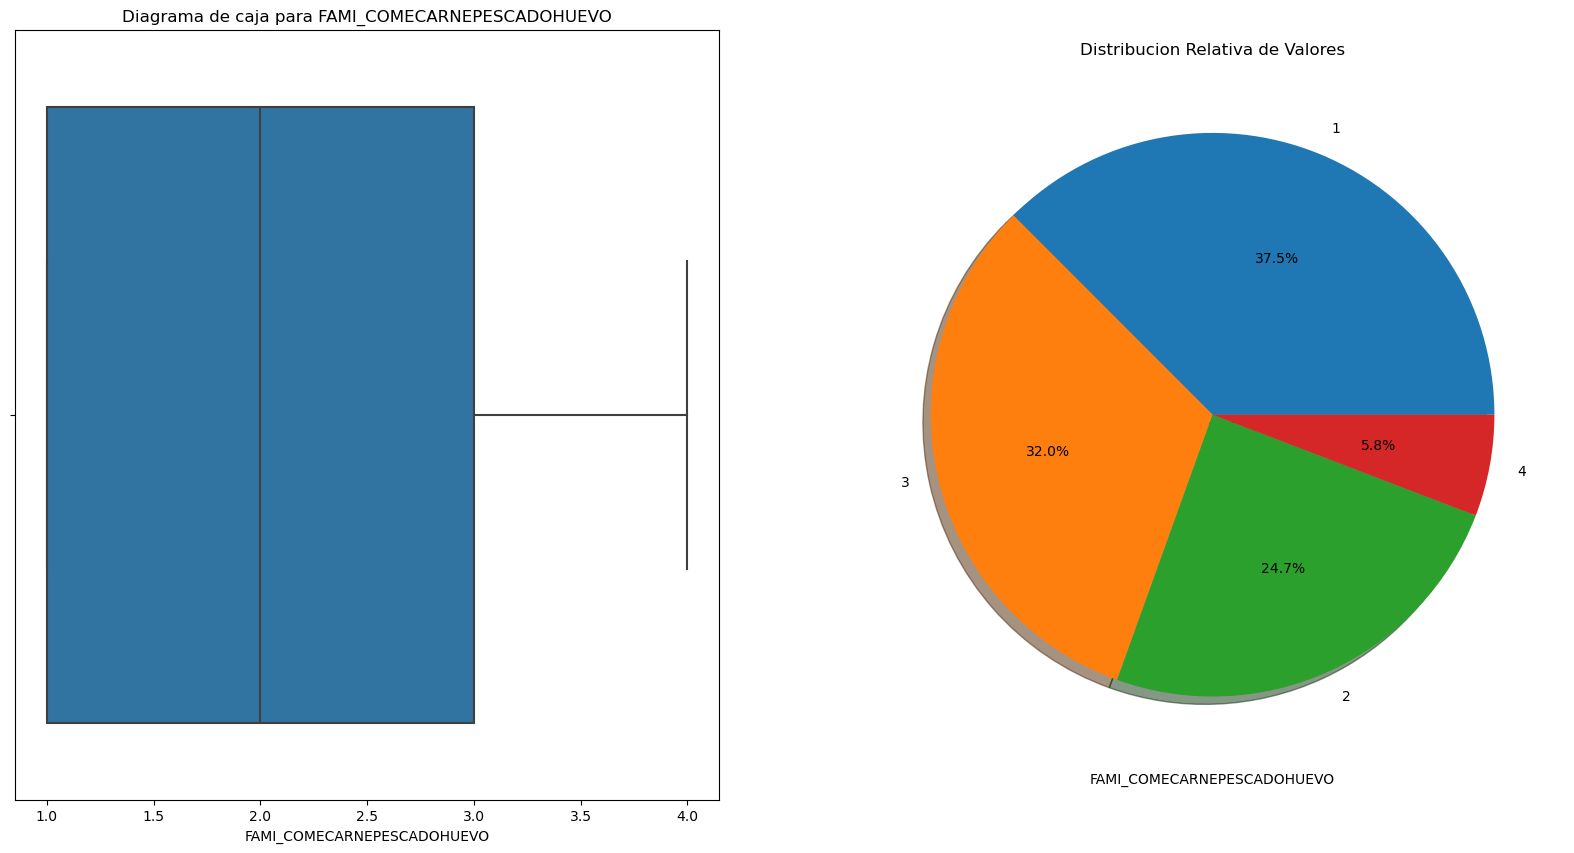



Estadisticas Basicas


count    405869.000000
mean          2.061480
std           0.961235
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: FAMI_COMECARNEPESCADOHUEVO, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




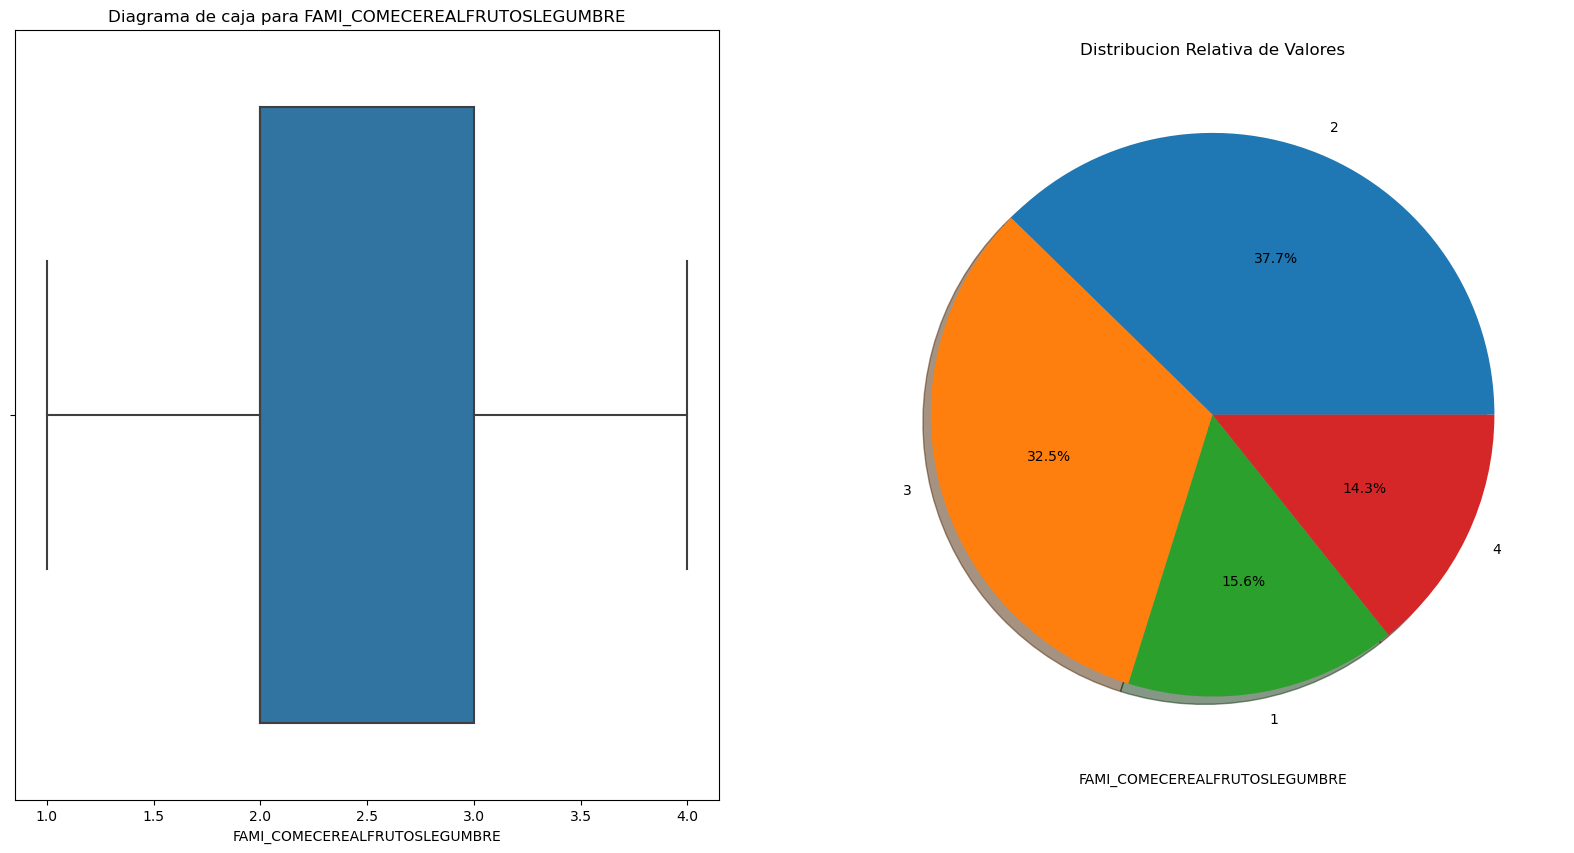



Estadisticas Basicas


count    405869.000000
mean          2.454775
std           0.918982
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: FAMI_COMECEREALFRUTOSLEGUMBRE, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




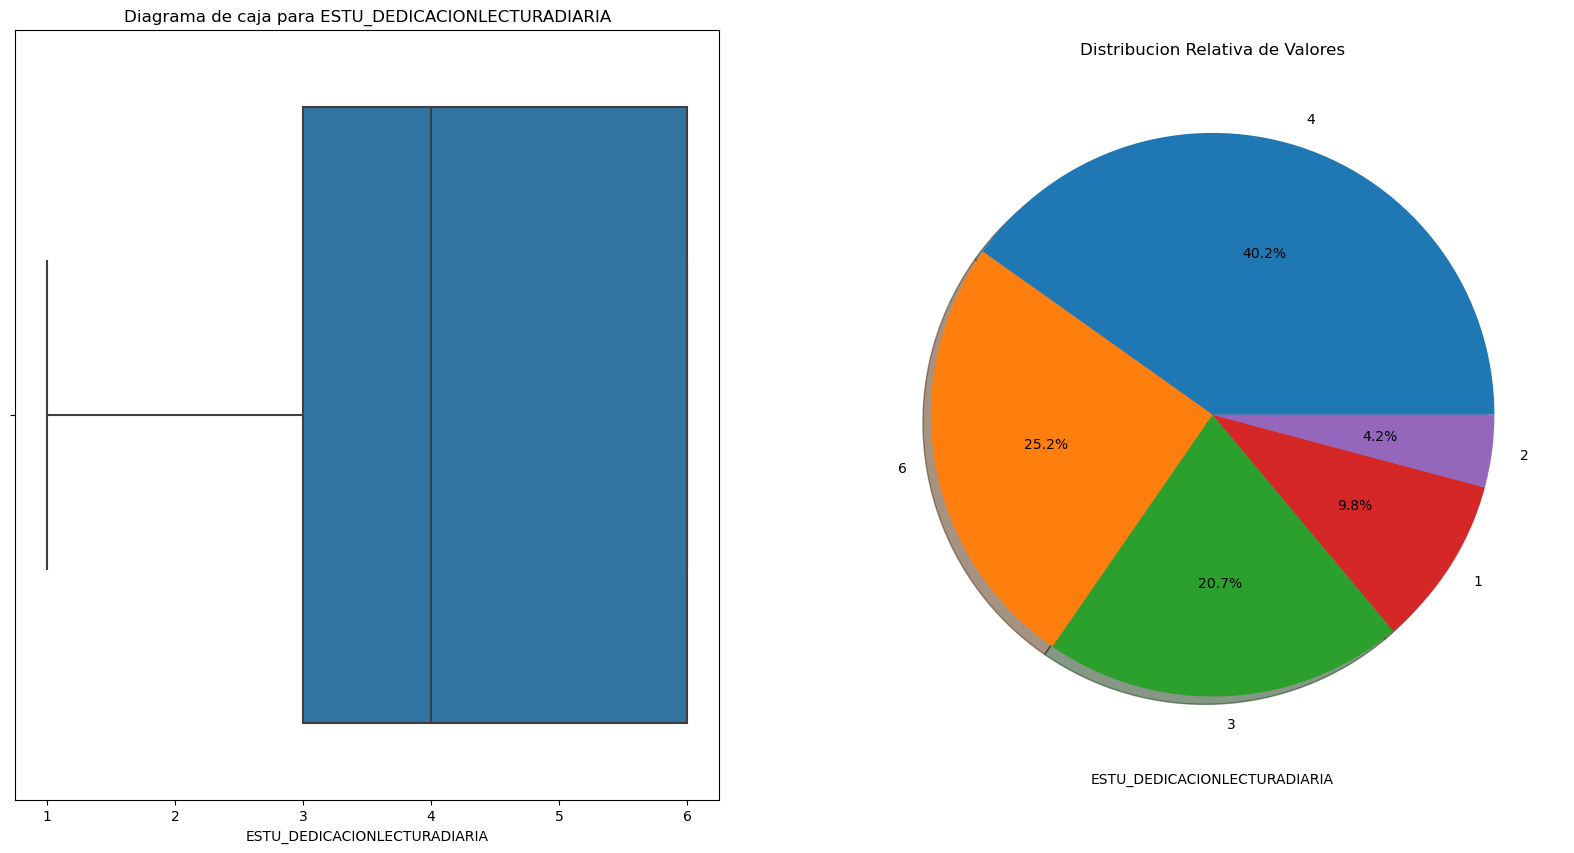



Estadisticas Basicas


count    405869.000000
mean          3.921120
std           1.501591
min           1.000000
25%           3.000000
50%           4.000000
75%           6.000000
max           6.000000
Name: ESTU_DEDICACIONLECTURADIARIA, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




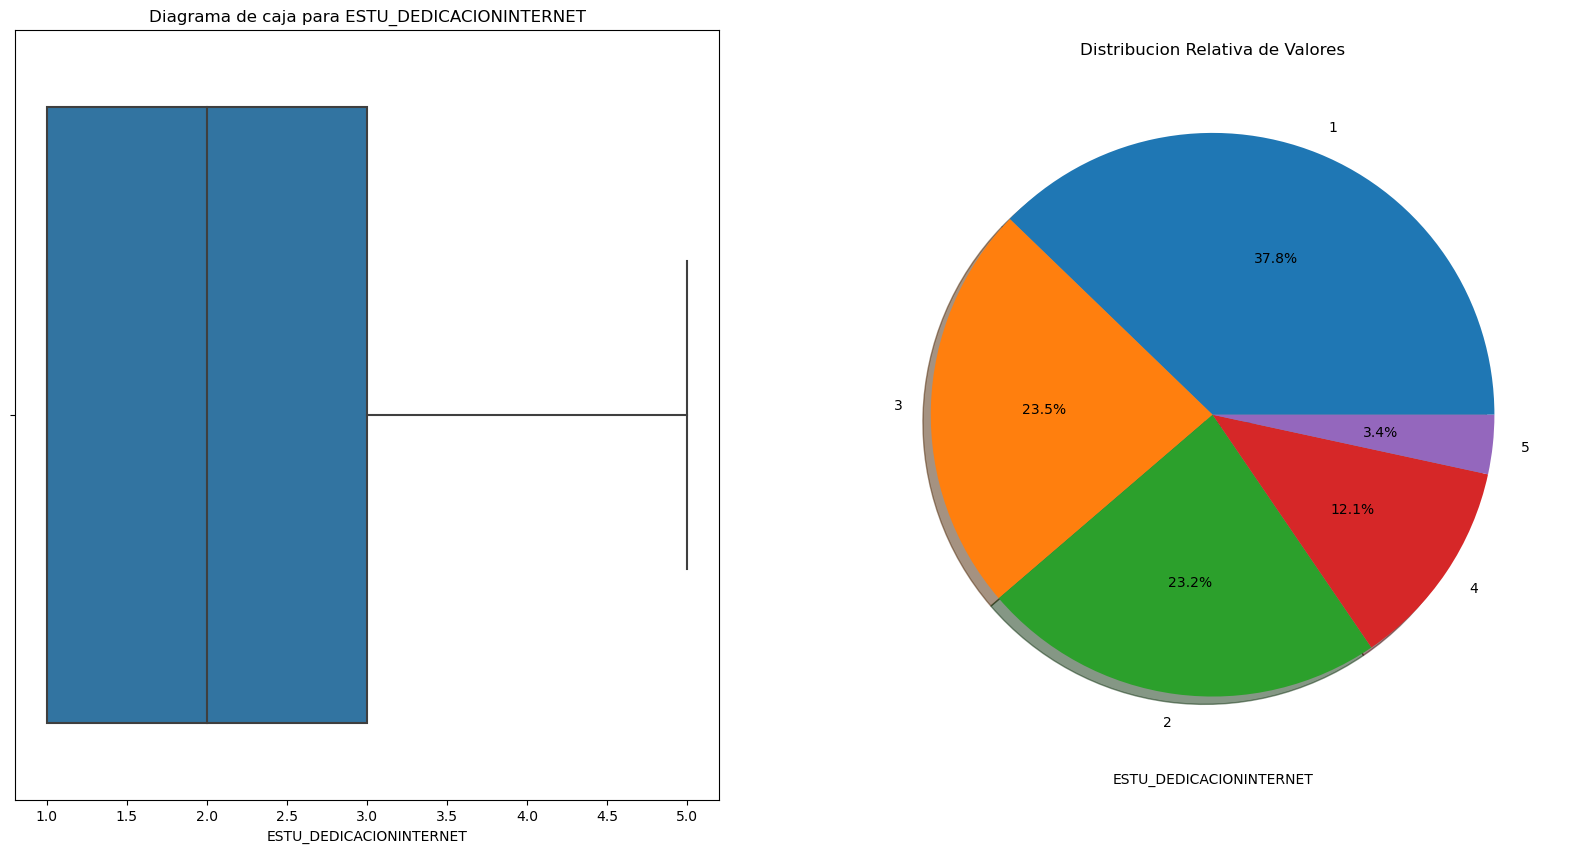



Estadisticas Basicas


count    405869.000000
mean          2.200683
std           1.166715
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: ESTU_DEDICACIONINTERNET, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




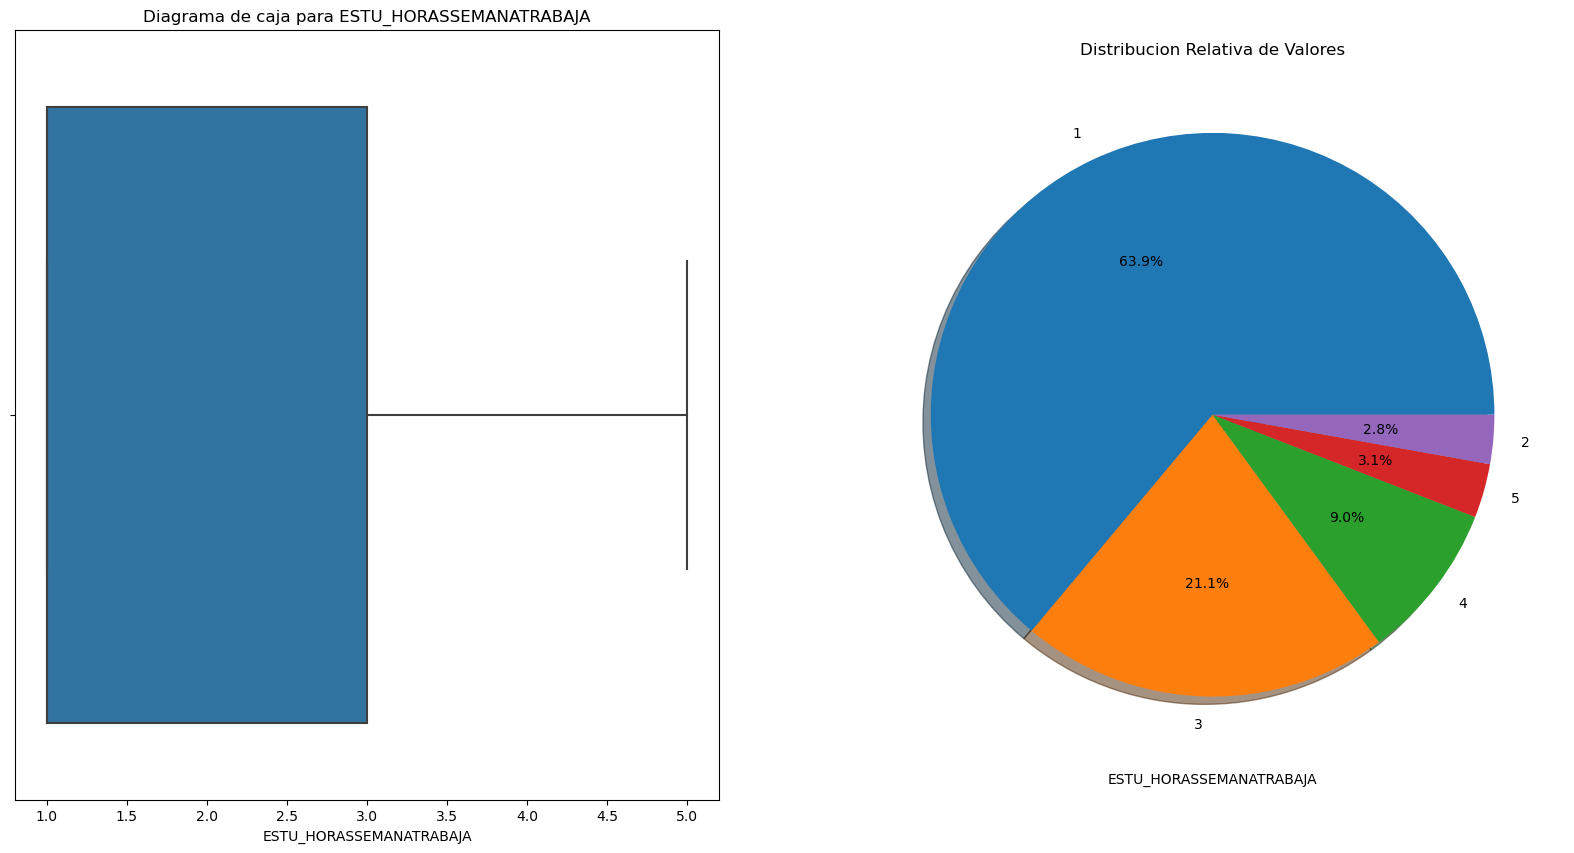



Estadisticas Basicas


count    405869.000000
mean          1.846009
std           1.211209
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max           5.000000
Name: ESTU_HORASSEMANATRABAJA, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




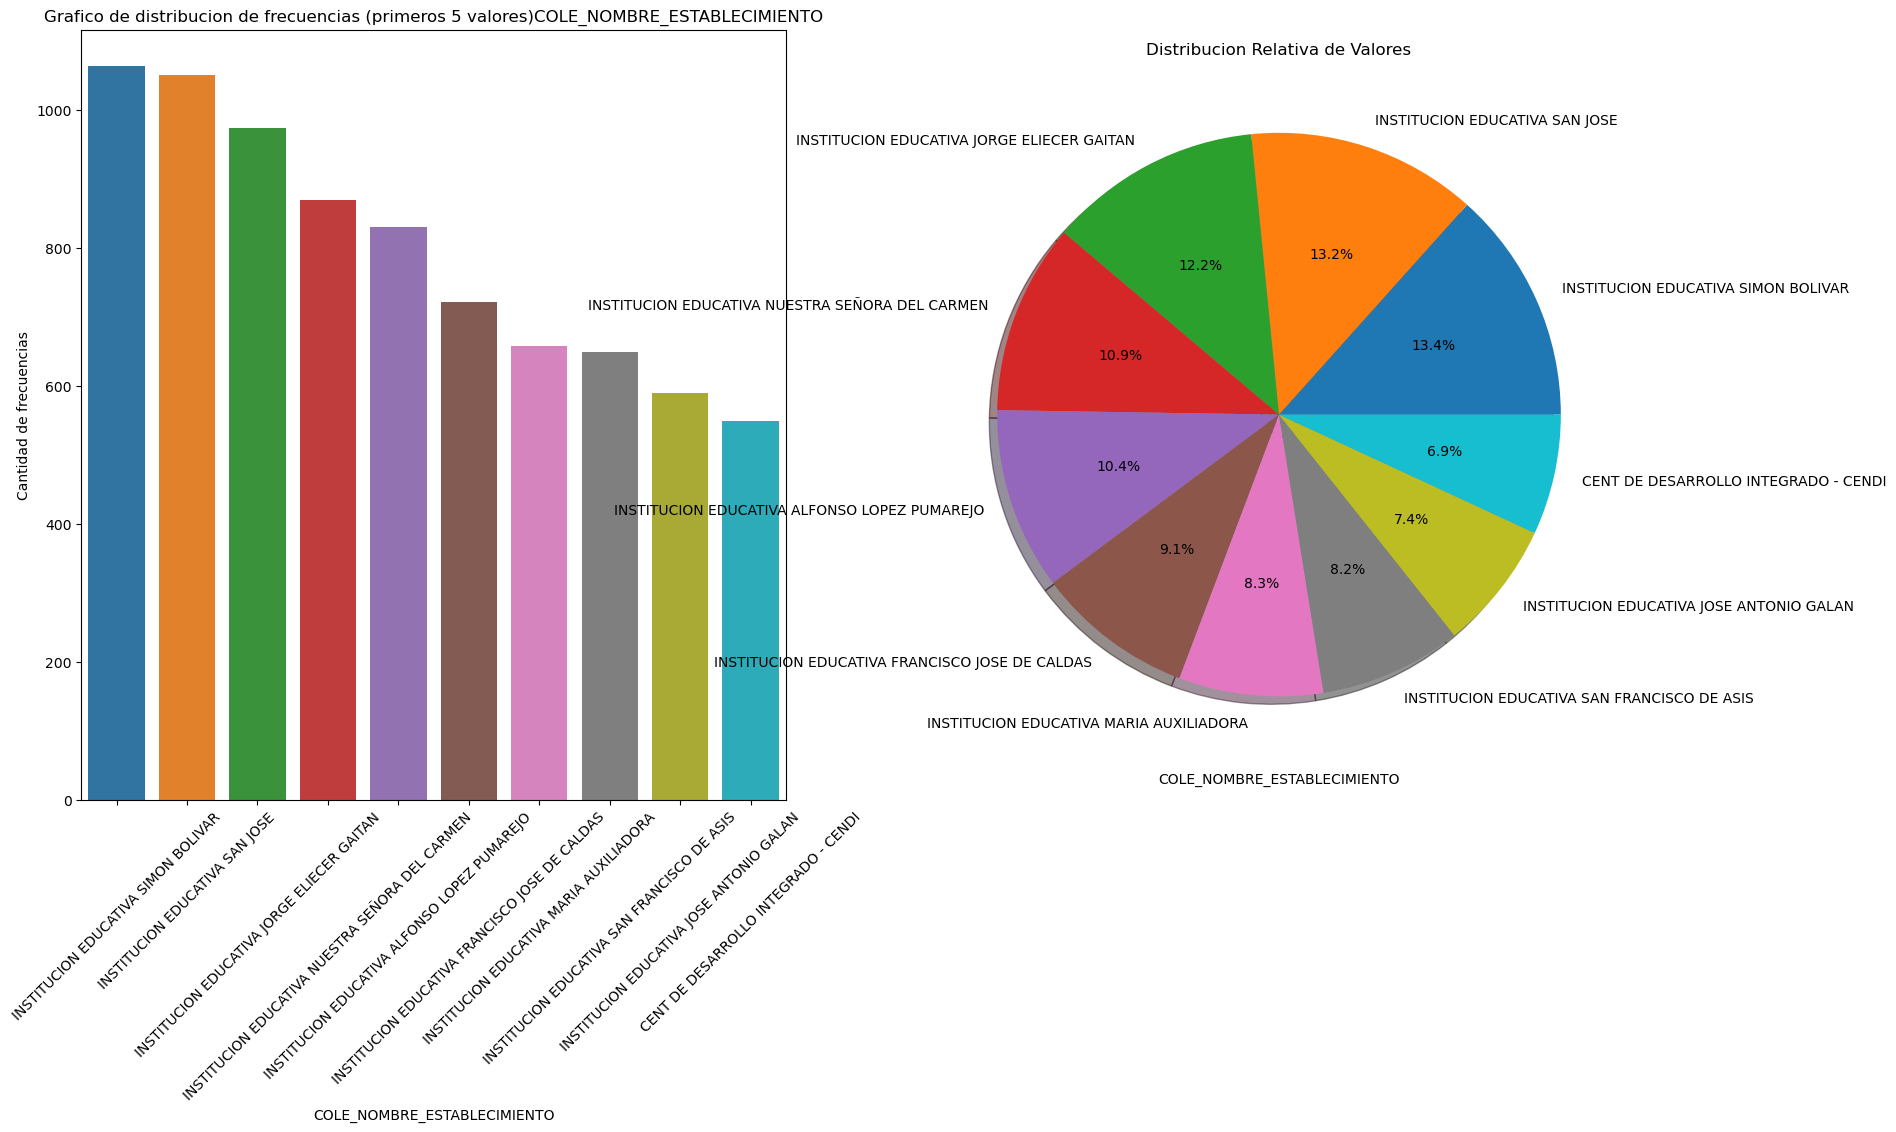



Estadisticas Basicas


count                                  405869
unique                                   7020
top       INSTITUCION EDUCATIVA SIMON BOLIVAR
freq                                     1063
Name: COLE_NOMBRE_ESTABLECIMIENTO, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




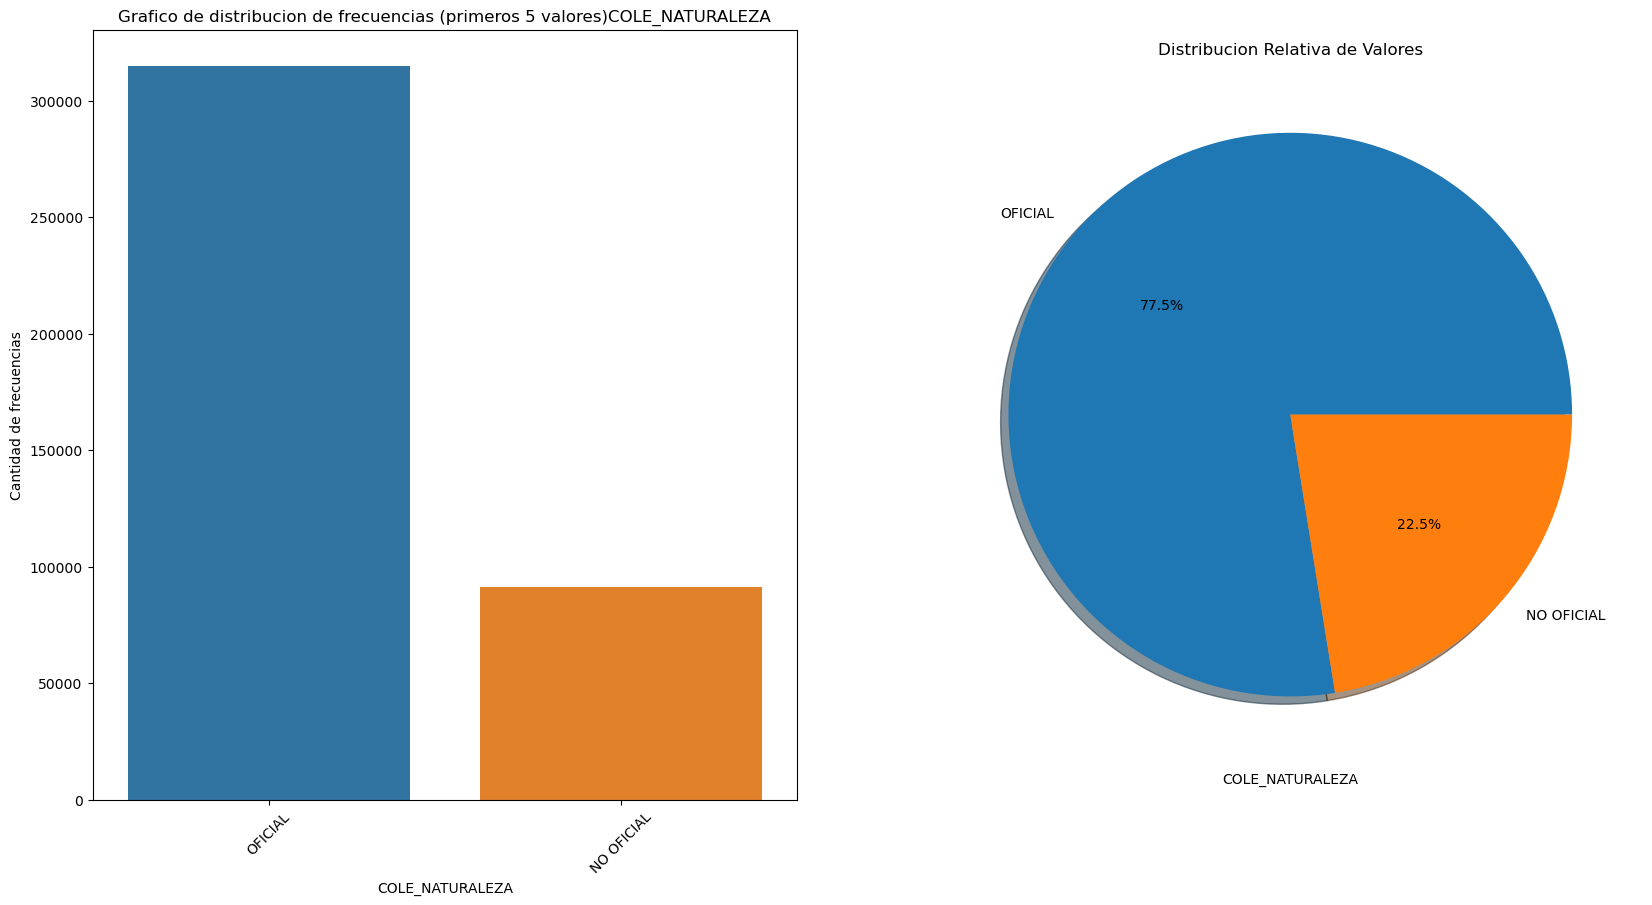



Estadisticas Basicas


count      405869
unique          2
top       OFICIAL
freq       314717
Name: COLE_NATURALEZA, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




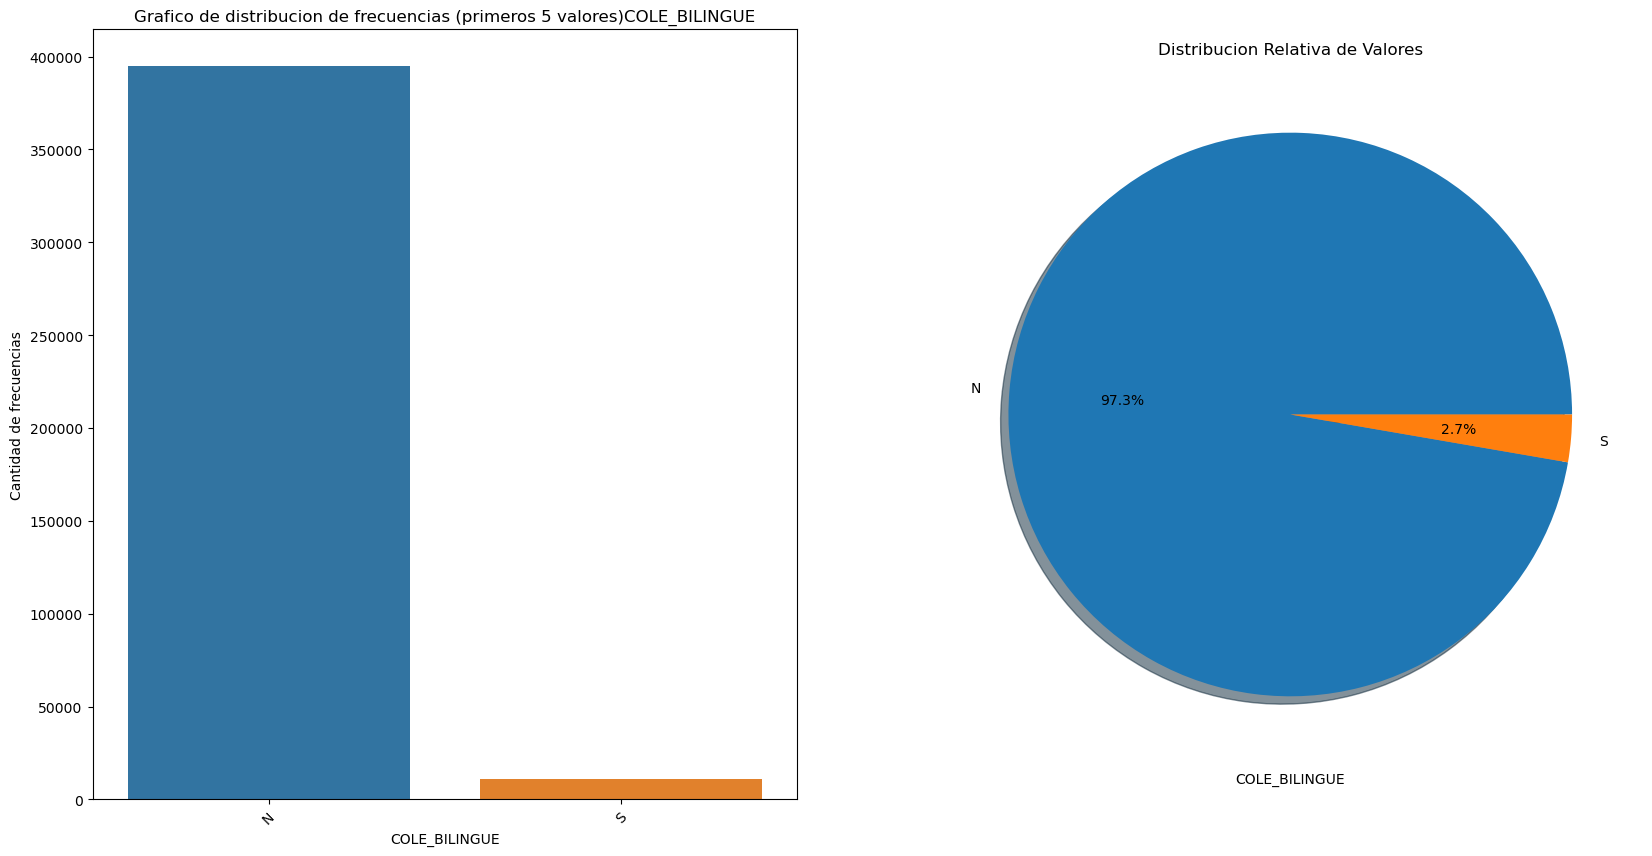



Estadisticas Basicas


count     405869
unique         2
top            N
freq      394840
Name: COLE_BILINGUE, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




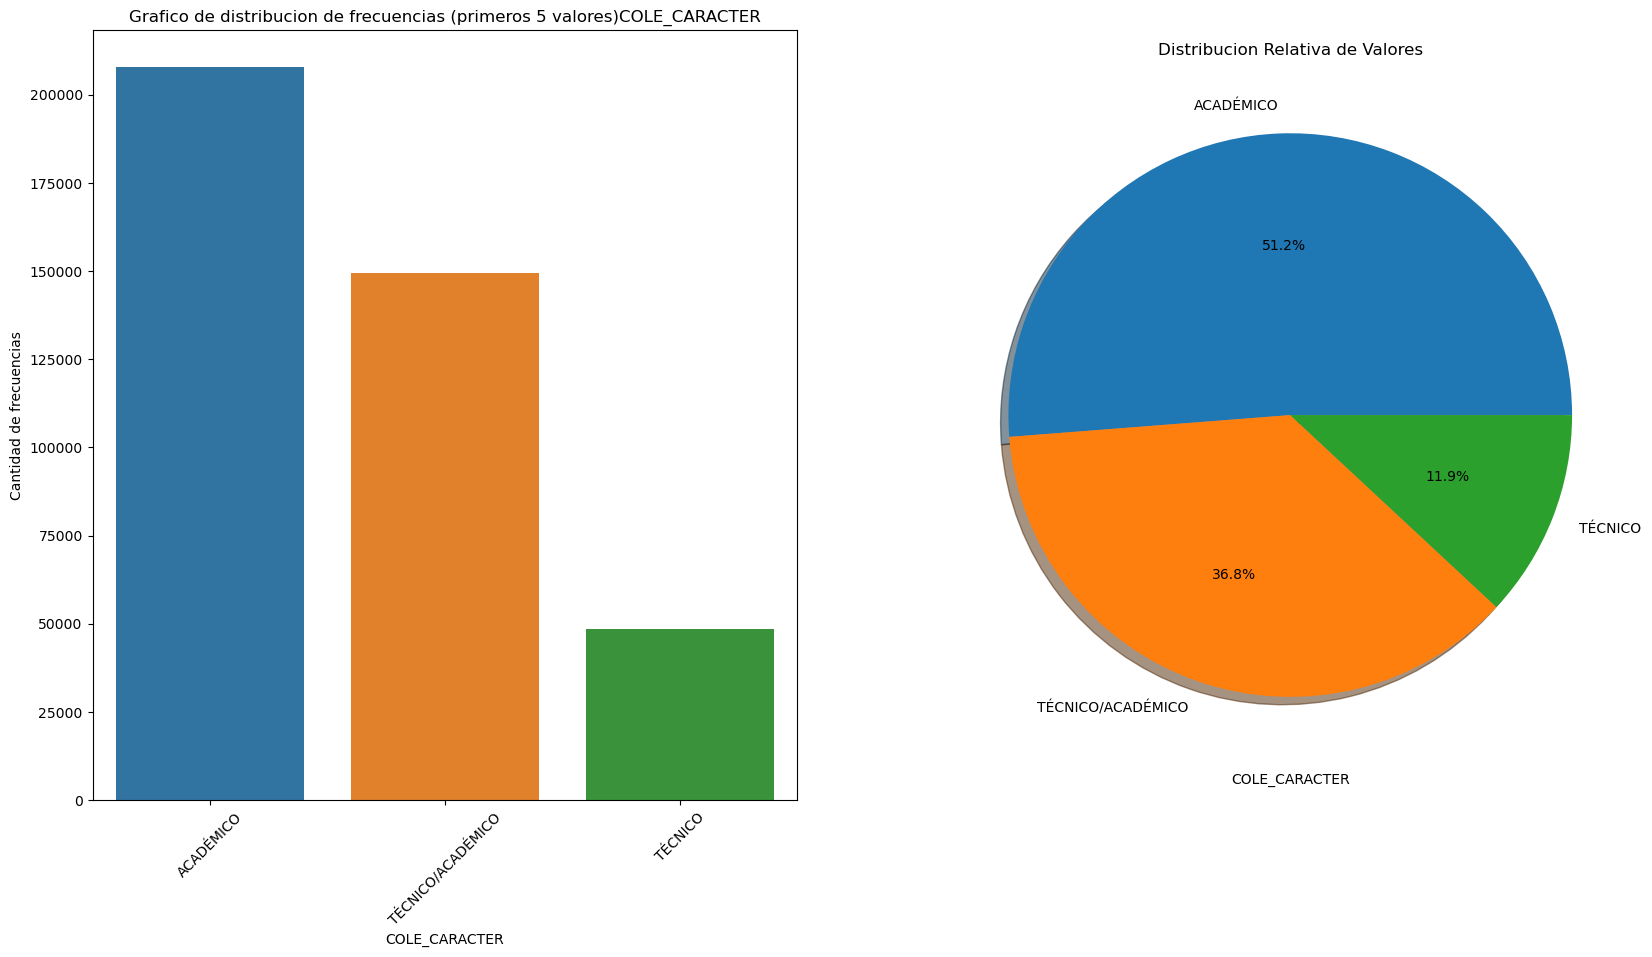



Estadisticas Basicas


count        405869
unique            3
top       ACADÉMICO
freq         207936
Name: COLE_CARACTER, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




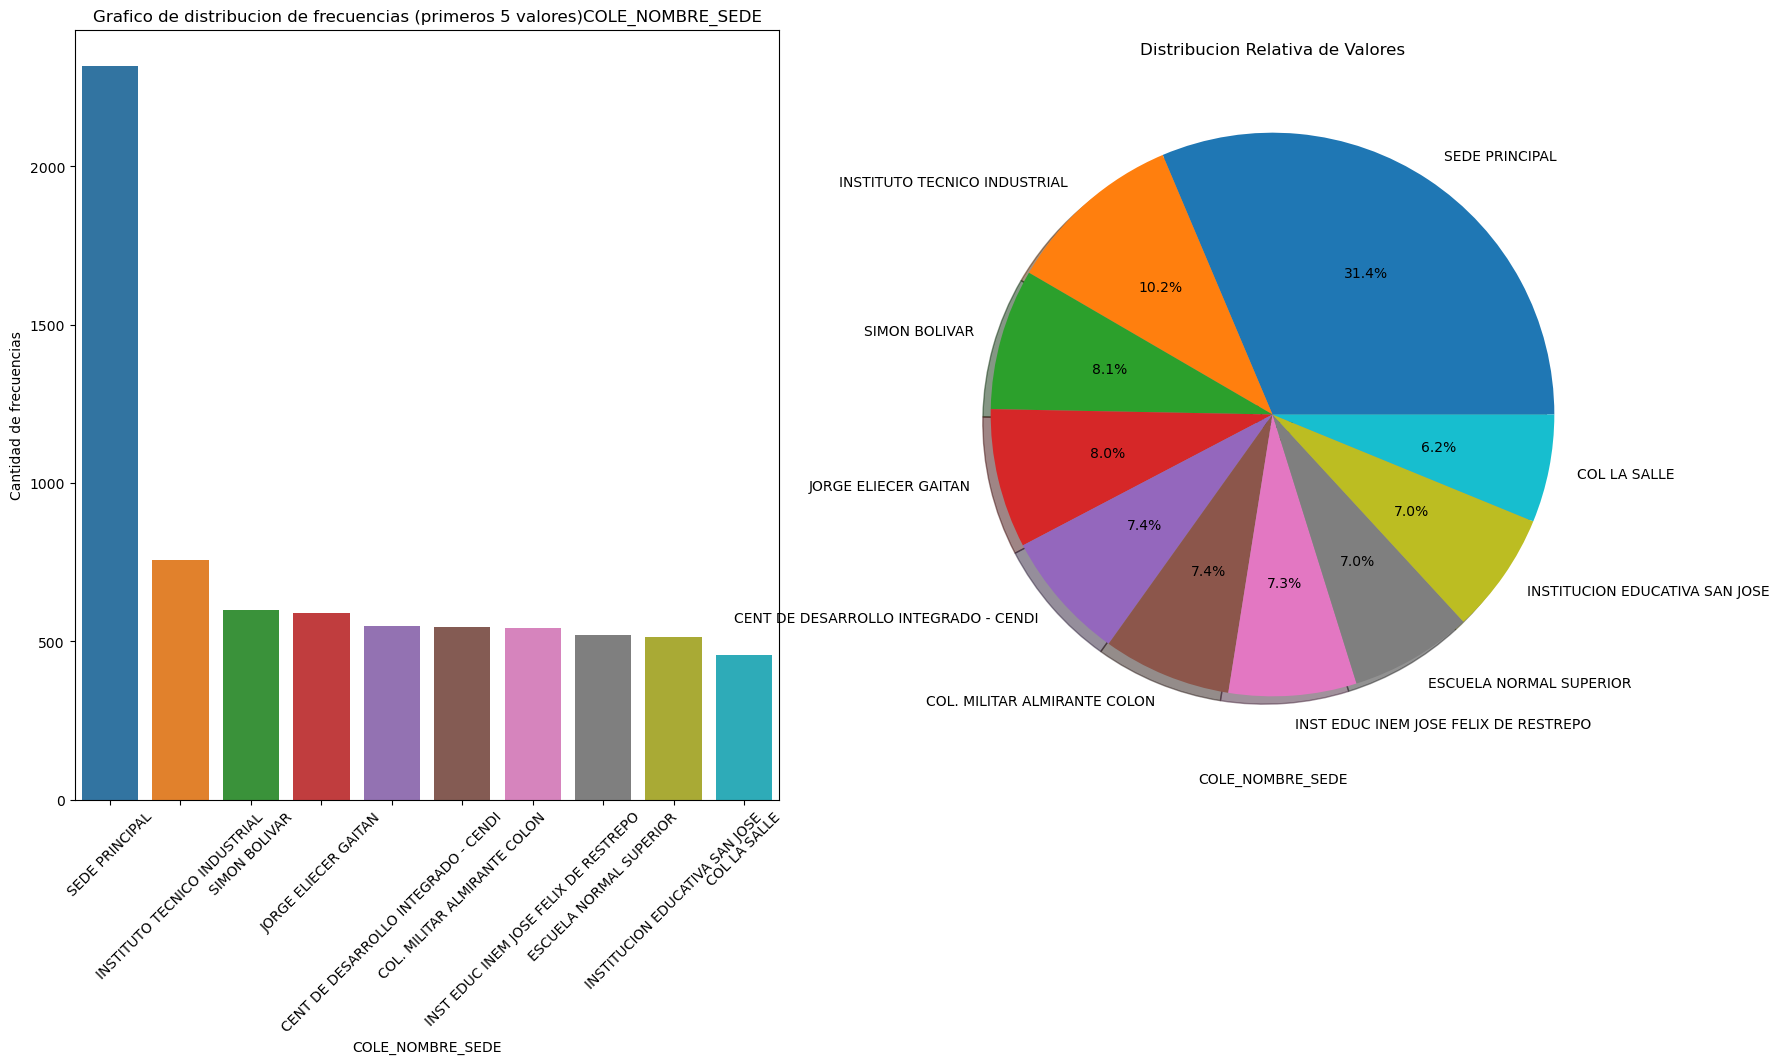



Estadisticas Basicas


count             405869
unique              7913
top       SEDE PRINCIPAL
freq                2316
Name: COLE_NOMBRE_SEDE, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




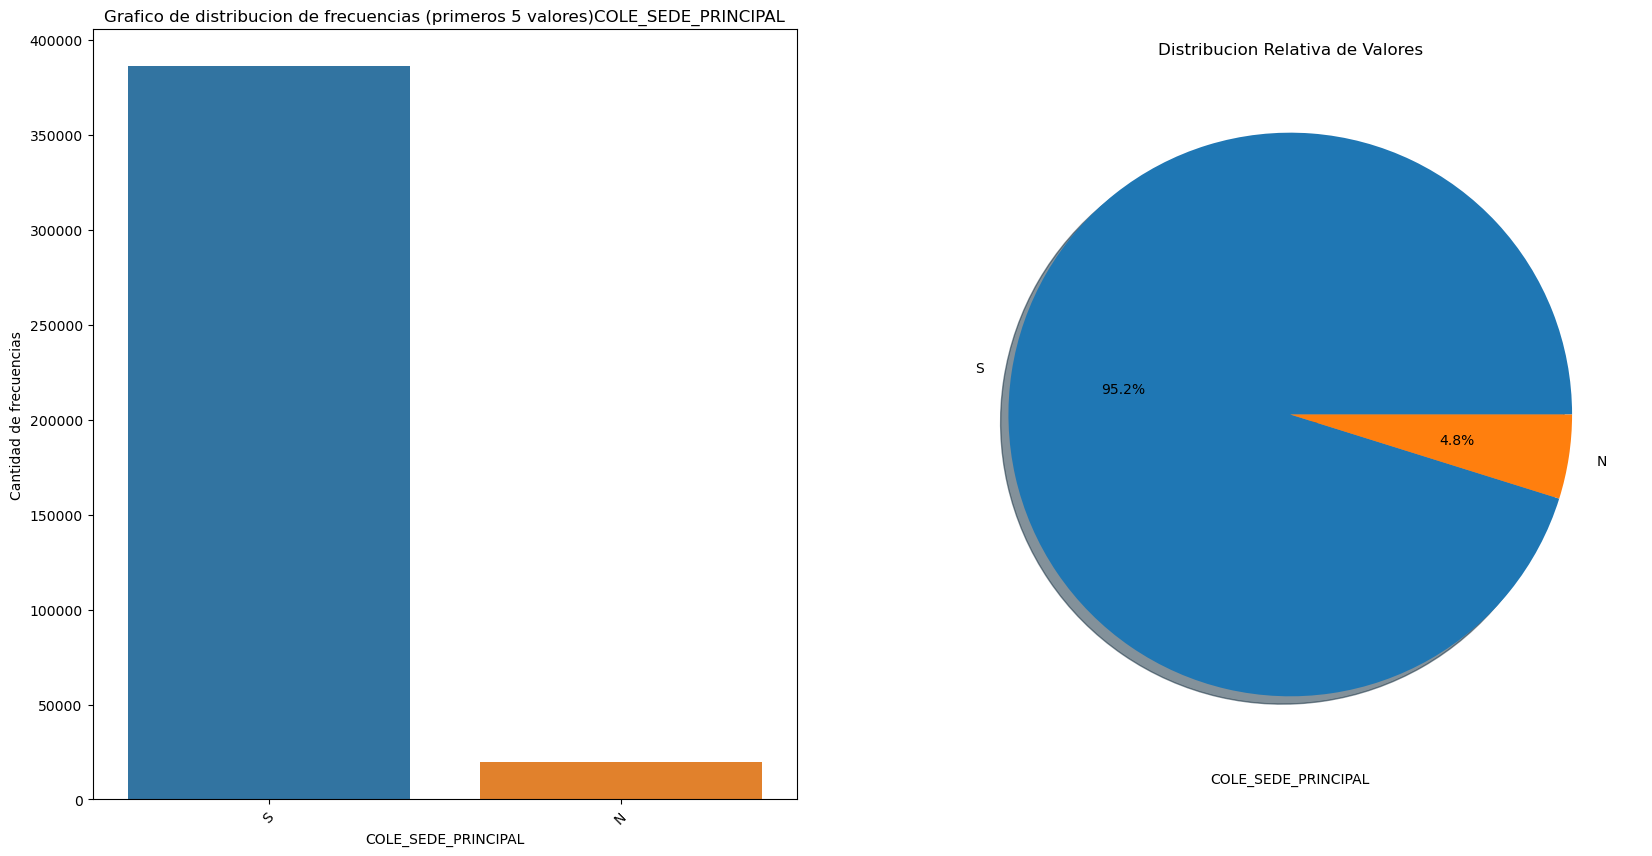



Estadisticas Basicas


count     405869
unique         2
top            S
freq      386285
Name: COLE_SEDE_PRINCIPAL, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




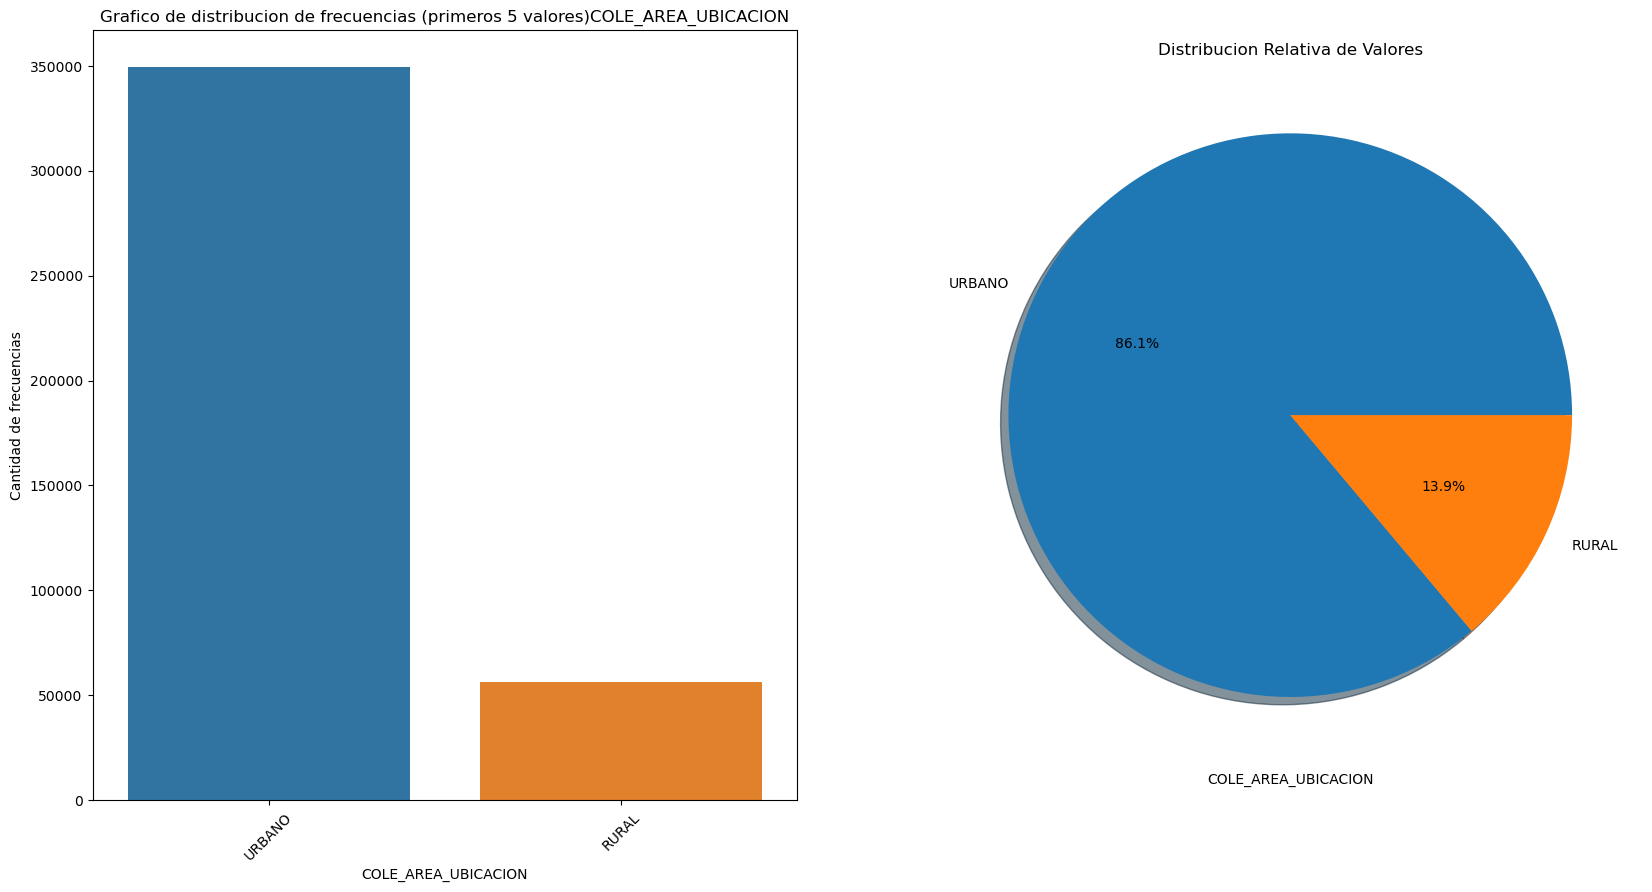



Estadisticas Basicas


count     405869
unique         2
top       URBANO
freq      349547
Name: COLE_AREA_UBICACION, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




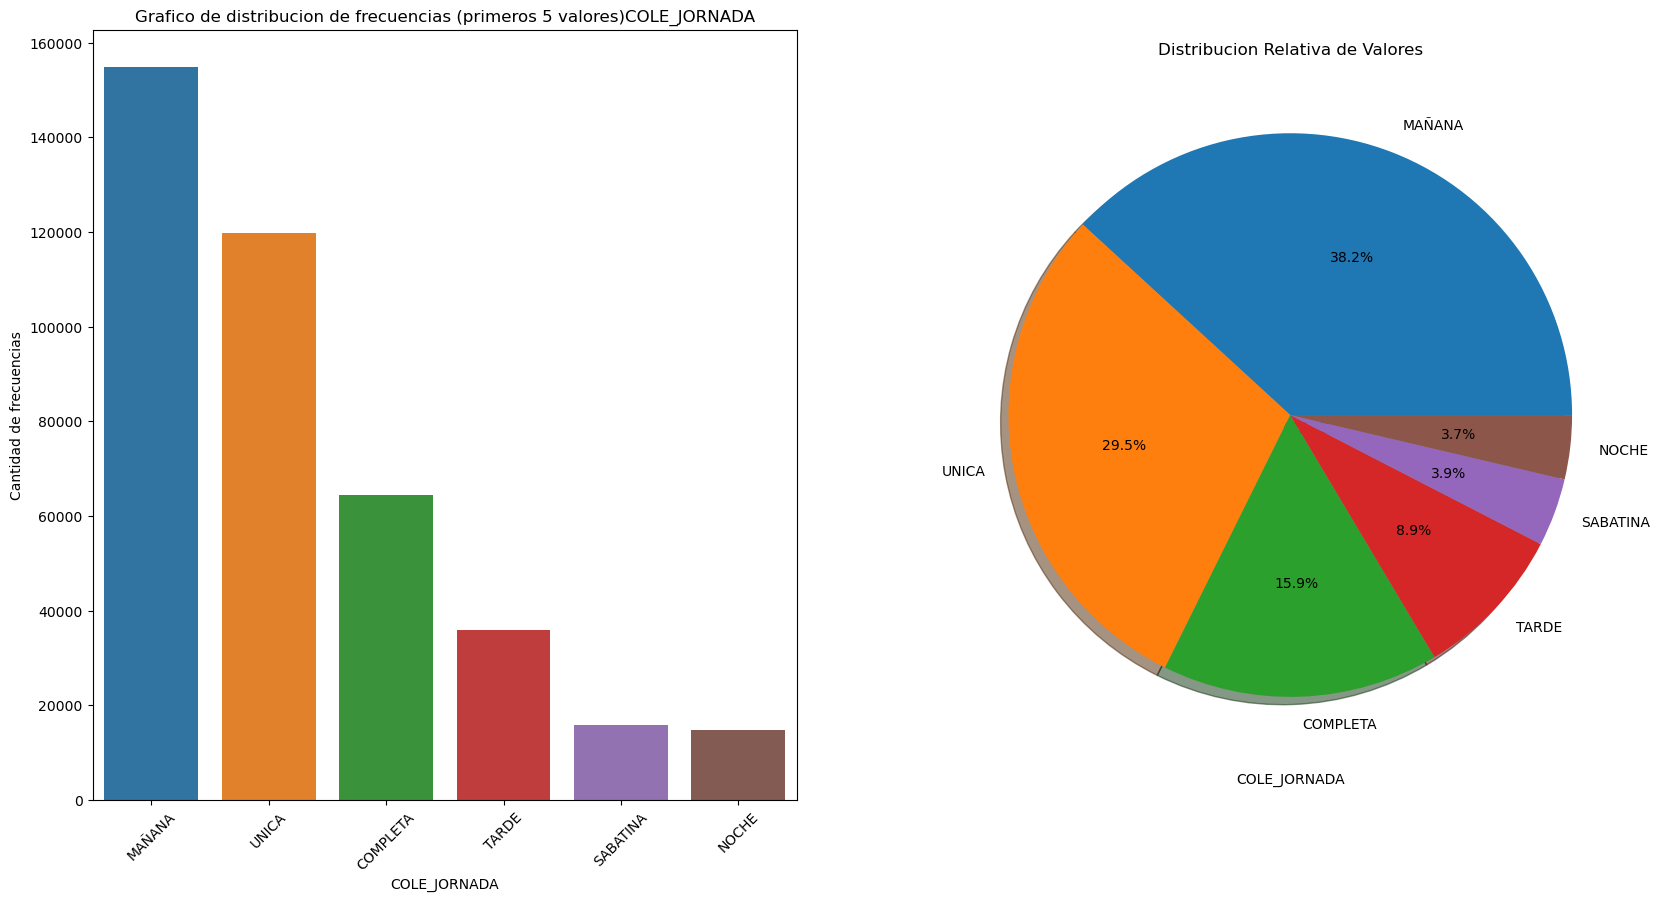



Estadisticas Basicas


count     405869
unique         6
top       MAÑANA
freq      154940
Name: COLE_JORNADA, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




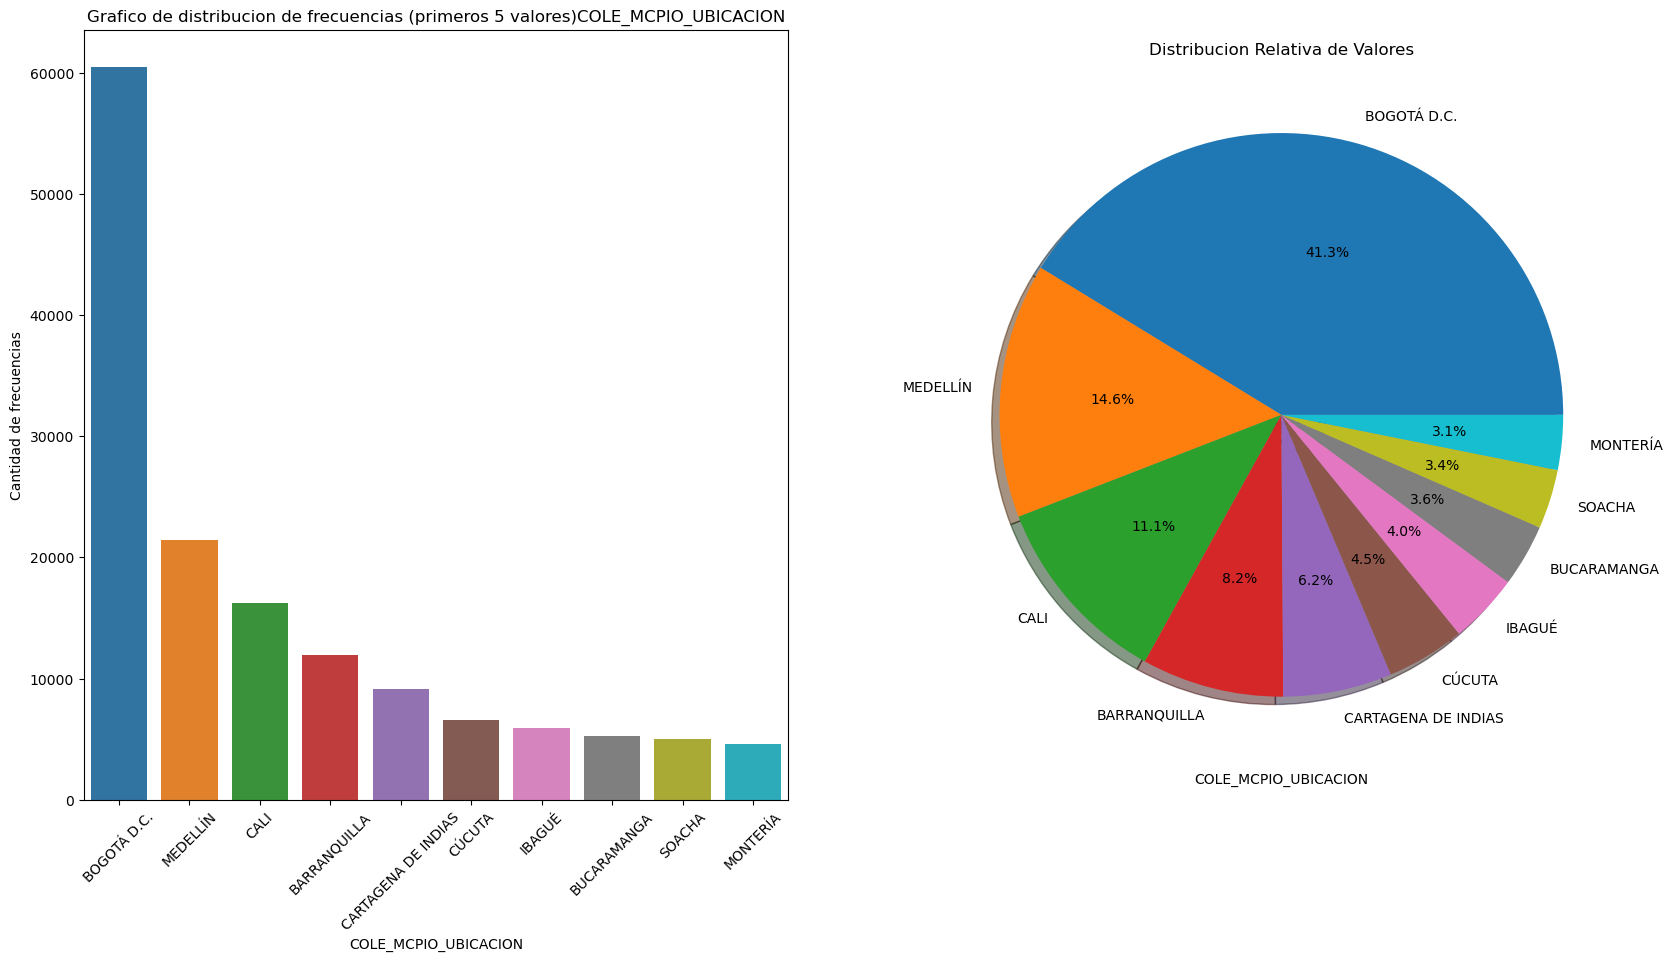



Estadisticas Basicas


count          405869
unique           1021
top       BOGOTÁ D.C.
freq            60505
Name: COLE_MCPIO_UBICACION, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




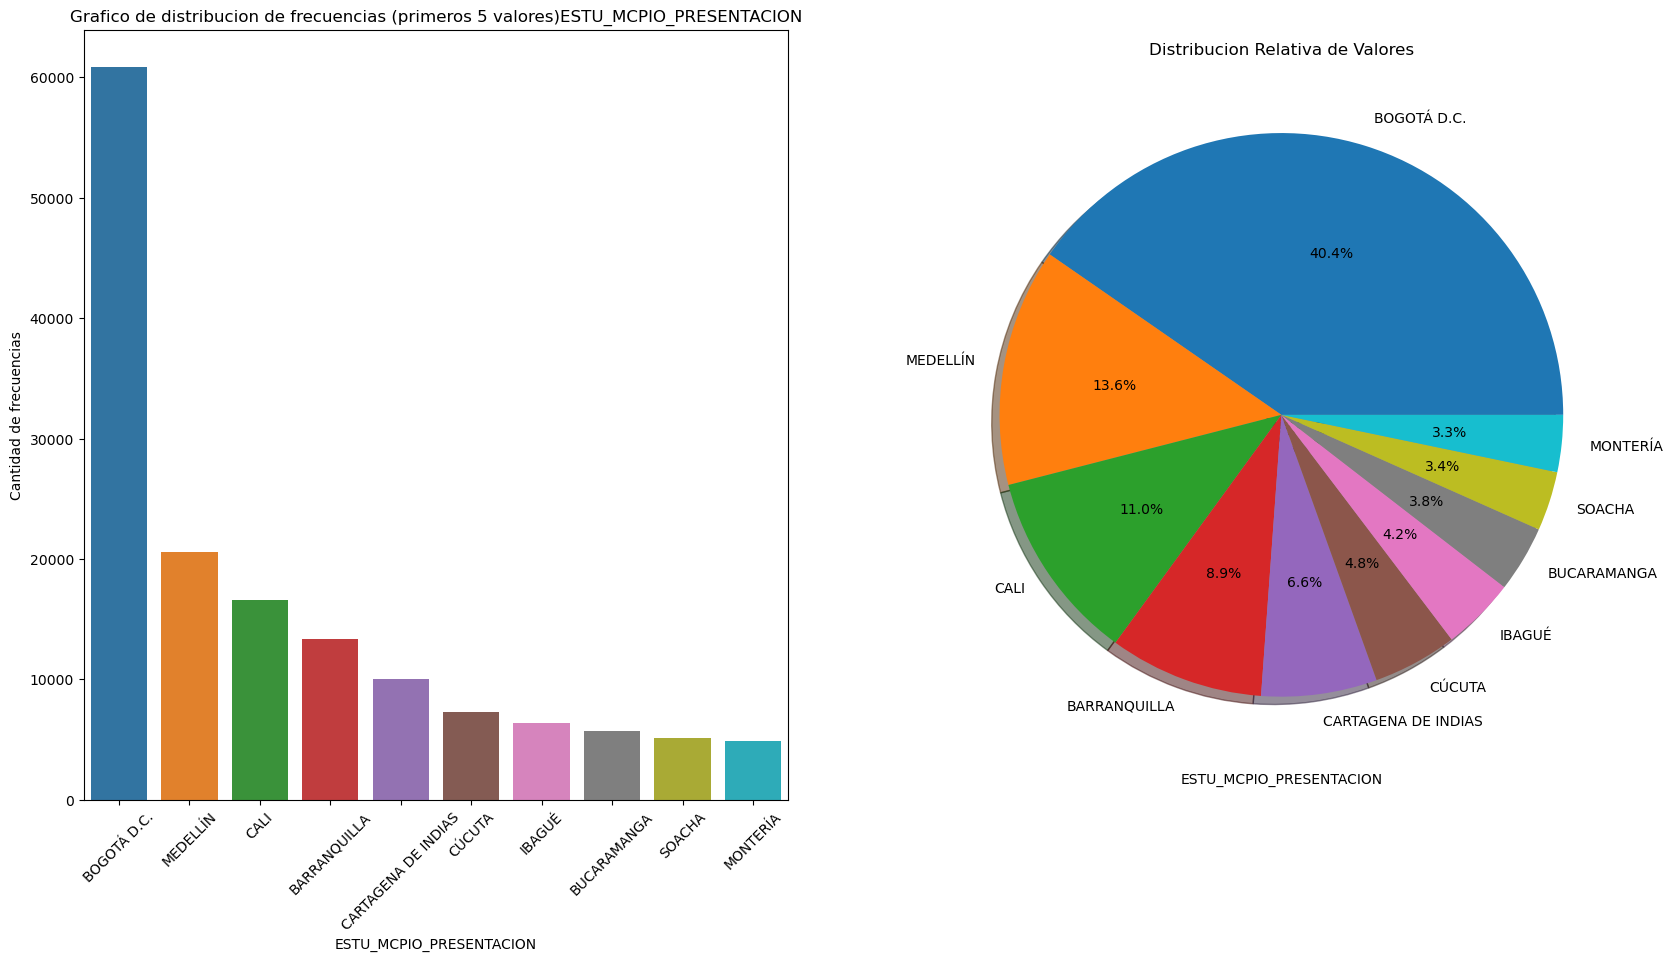



Estadisticas Basicas


count          405869
unique            503
top       BOGOTÁ D.C.
freq            60902
Name: ESTU_MCPIO_PRESENTACION, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




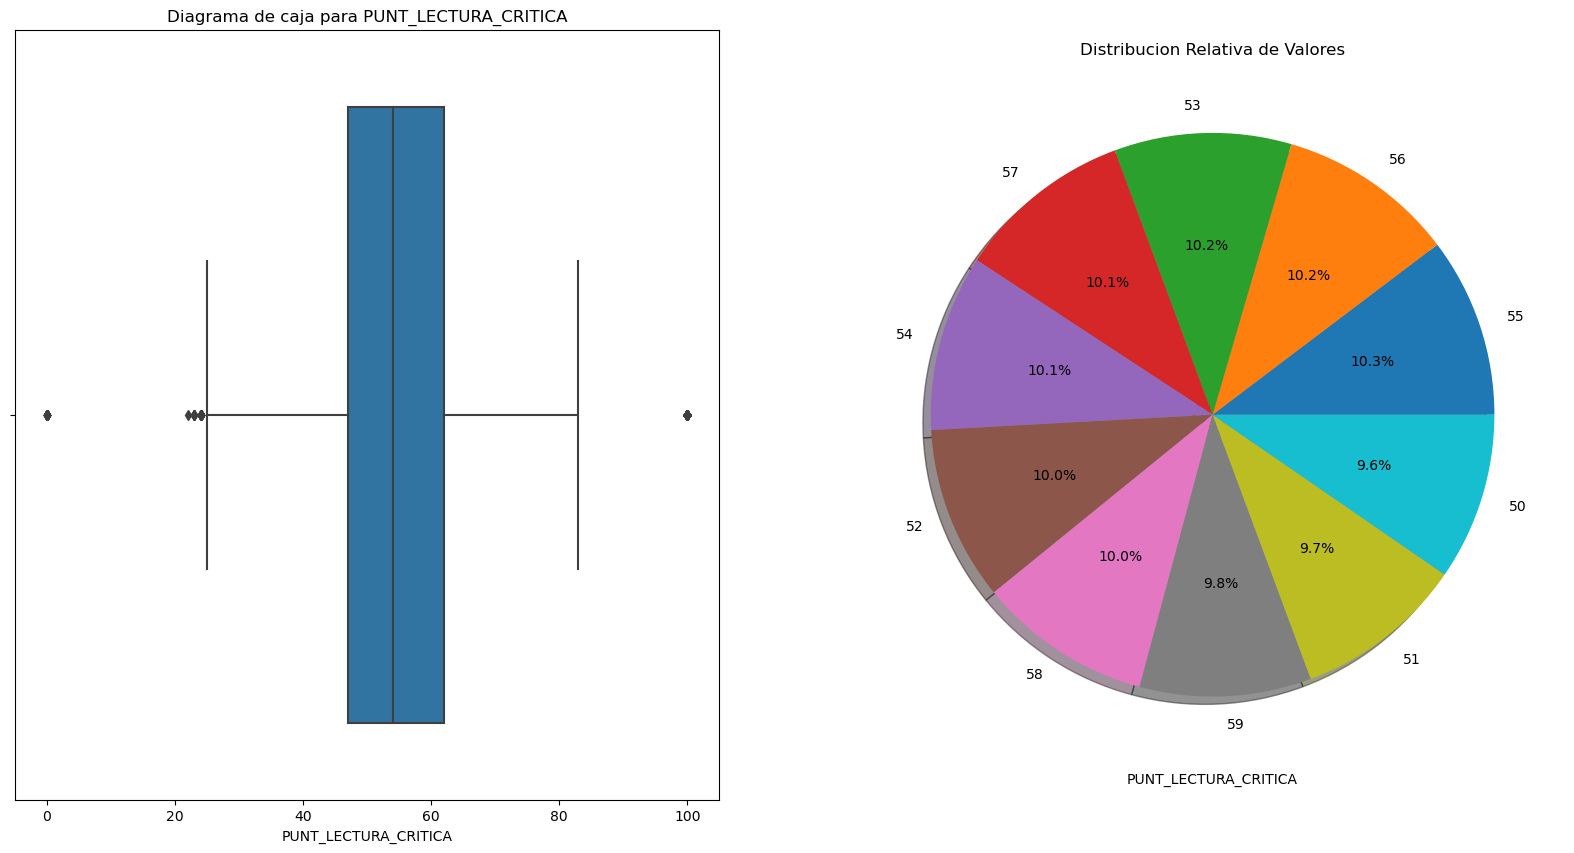



Estadisticas Basicas


count    405869.000000
mean         54.068586
std          10.427905
min           0.000000
25%          47.000000
50%          54.000000
75%          62.000000
max         100.000000
Name: PUNT_LECTURA_CRITICA, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




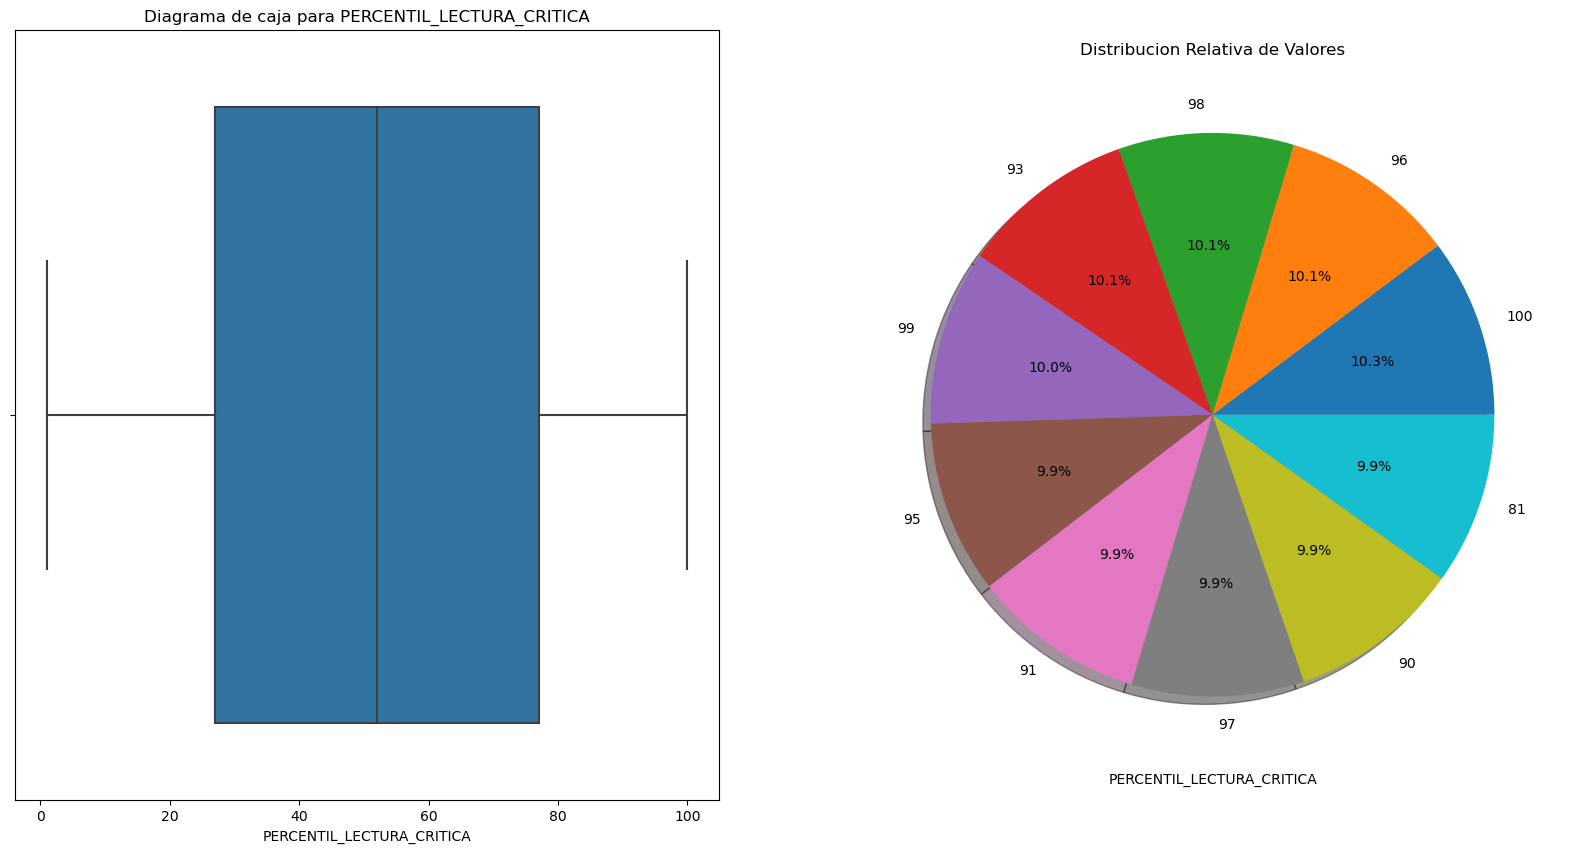



Estadisticas Basicas


count    405869.000000
mean         51.705644
std          28.769378
min           1.000000
25%          27.000000
50%          52.000000
75%          77.000000
max         100.000000
Name: PERCENTIL_LECTURA_CRITICA, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




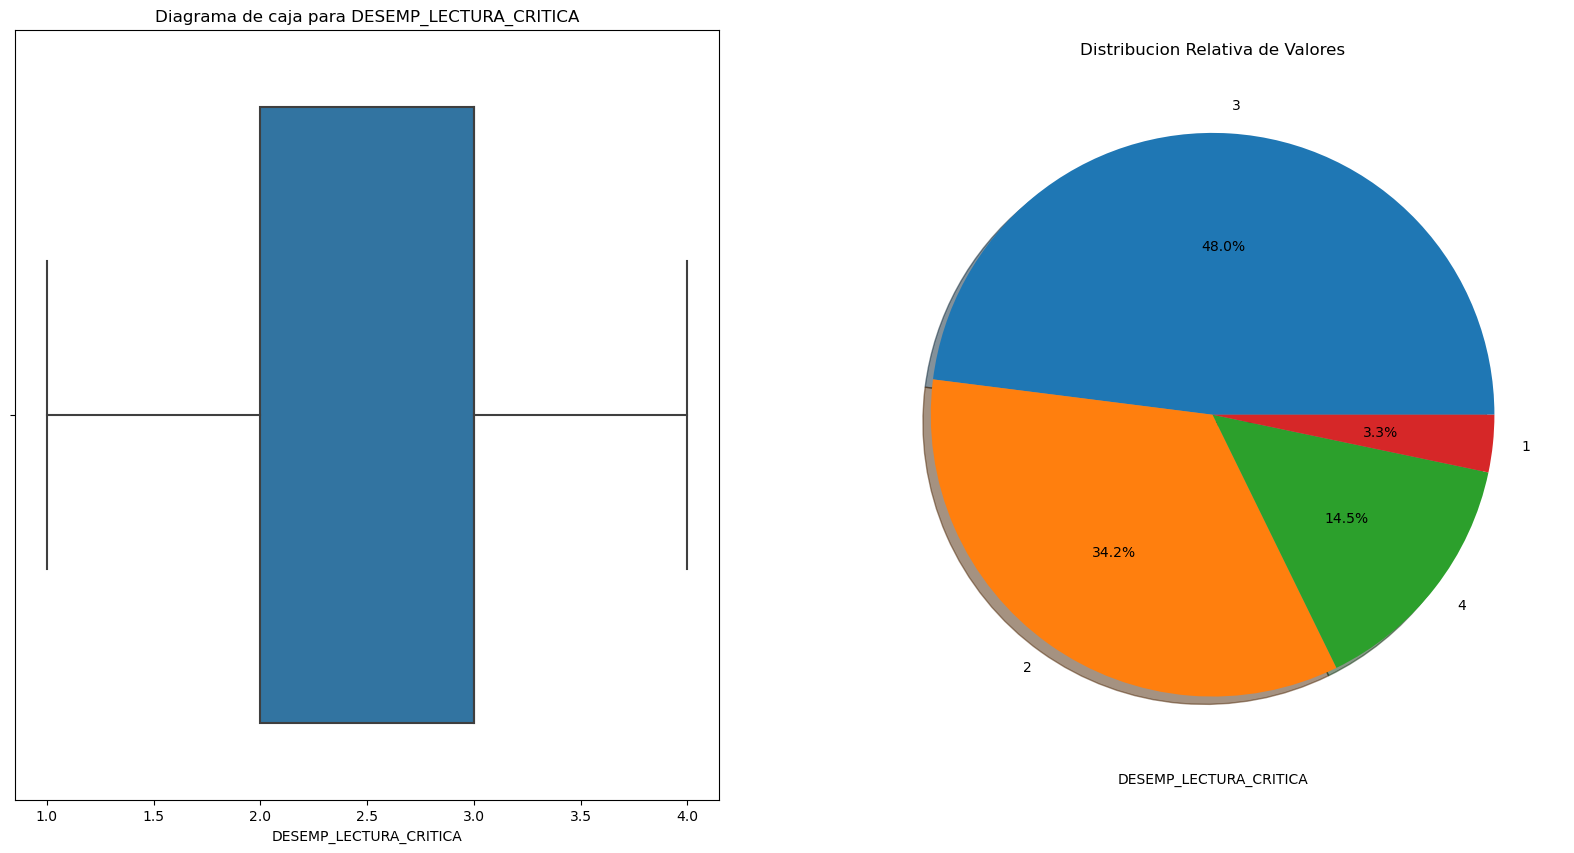



Estadisticas Basicas


count    405869.000000
mean          2.736565
std           0.741048
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: DESEMP_LECTURA_CRITICA, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




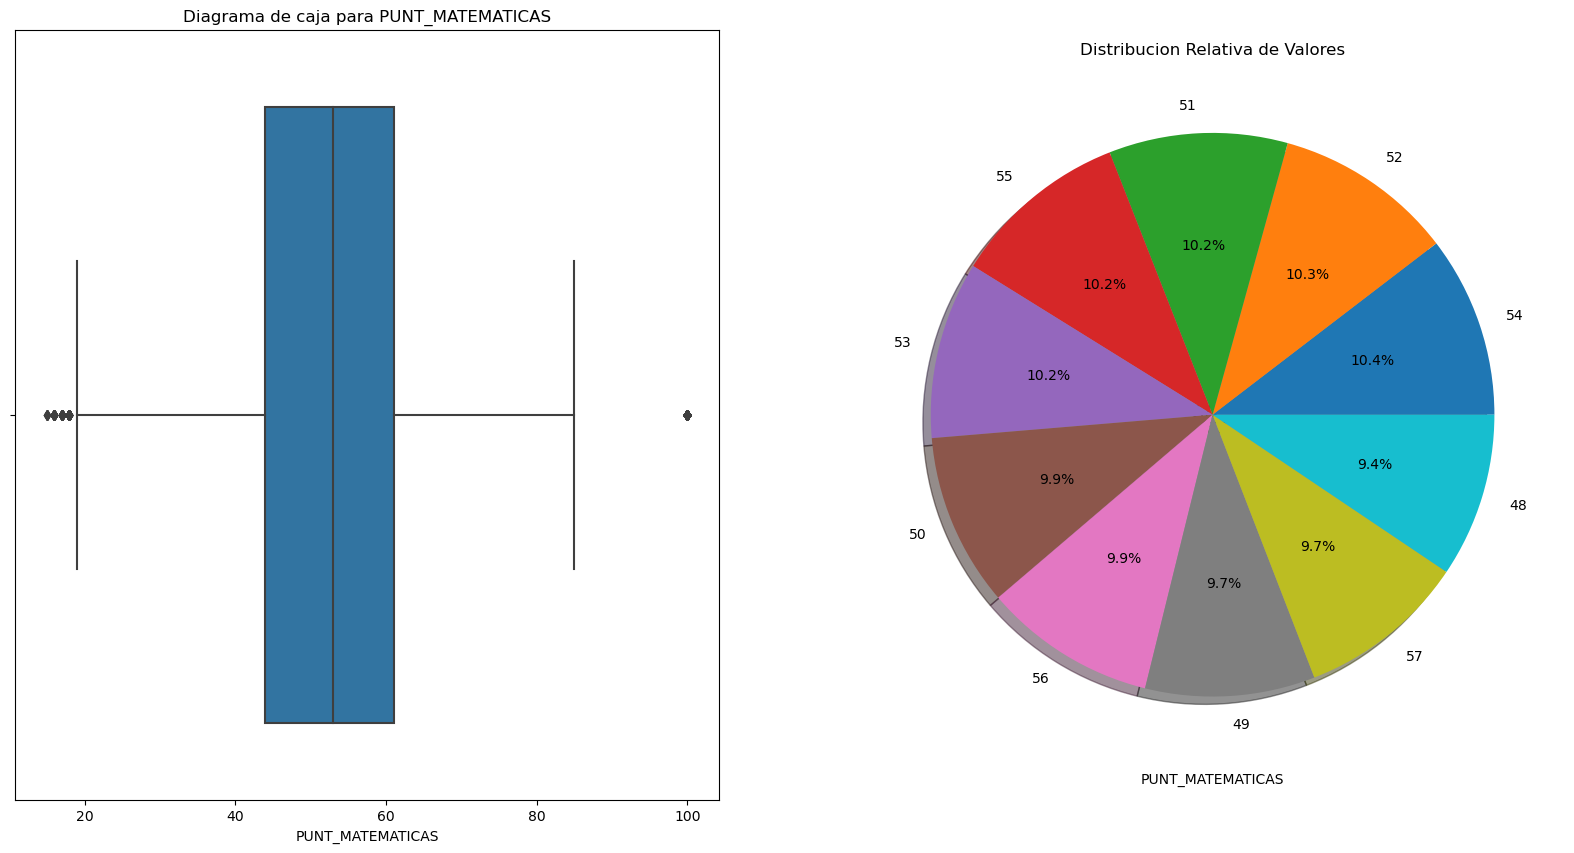



Estadisticas Basicas


count    405869.000000
mean         52.545691
std          12.404004
min          15.000000
25%          44.000000
50%          53.000000
75%          61.000000
max         100.000000
Name: PUNT_MATEMATICAS, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




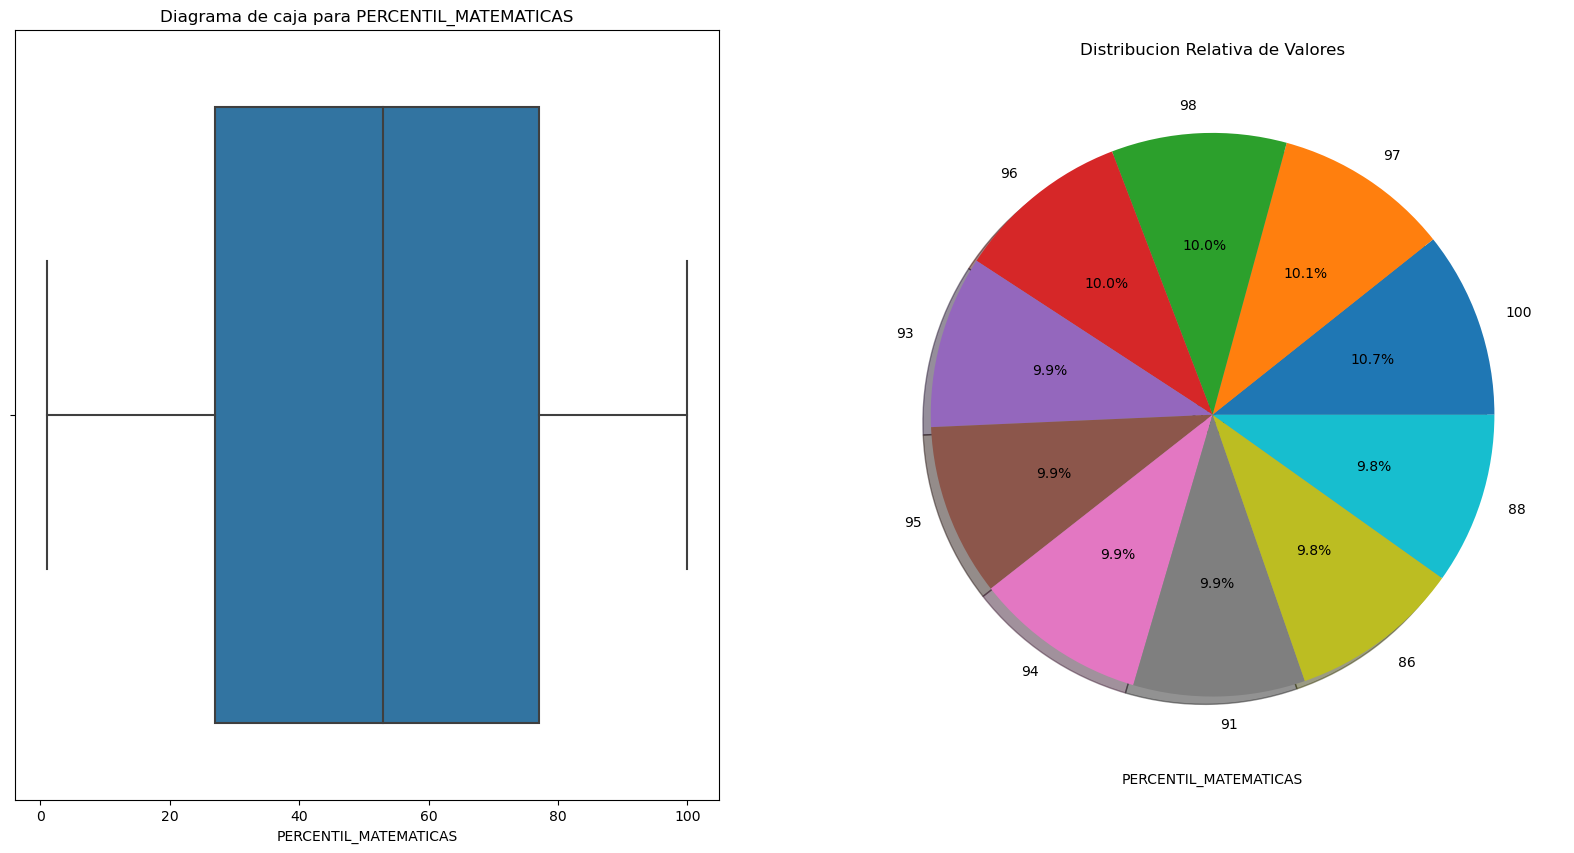



Estadisticas Basicas


count    405869.000000
mean         51.946236
std          28.763115
min           1.000000
25%          27.000000
50%          53.000000
75%          77.000000
max         100.000000
Name: PERCENTIL_MATEMATICAS, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




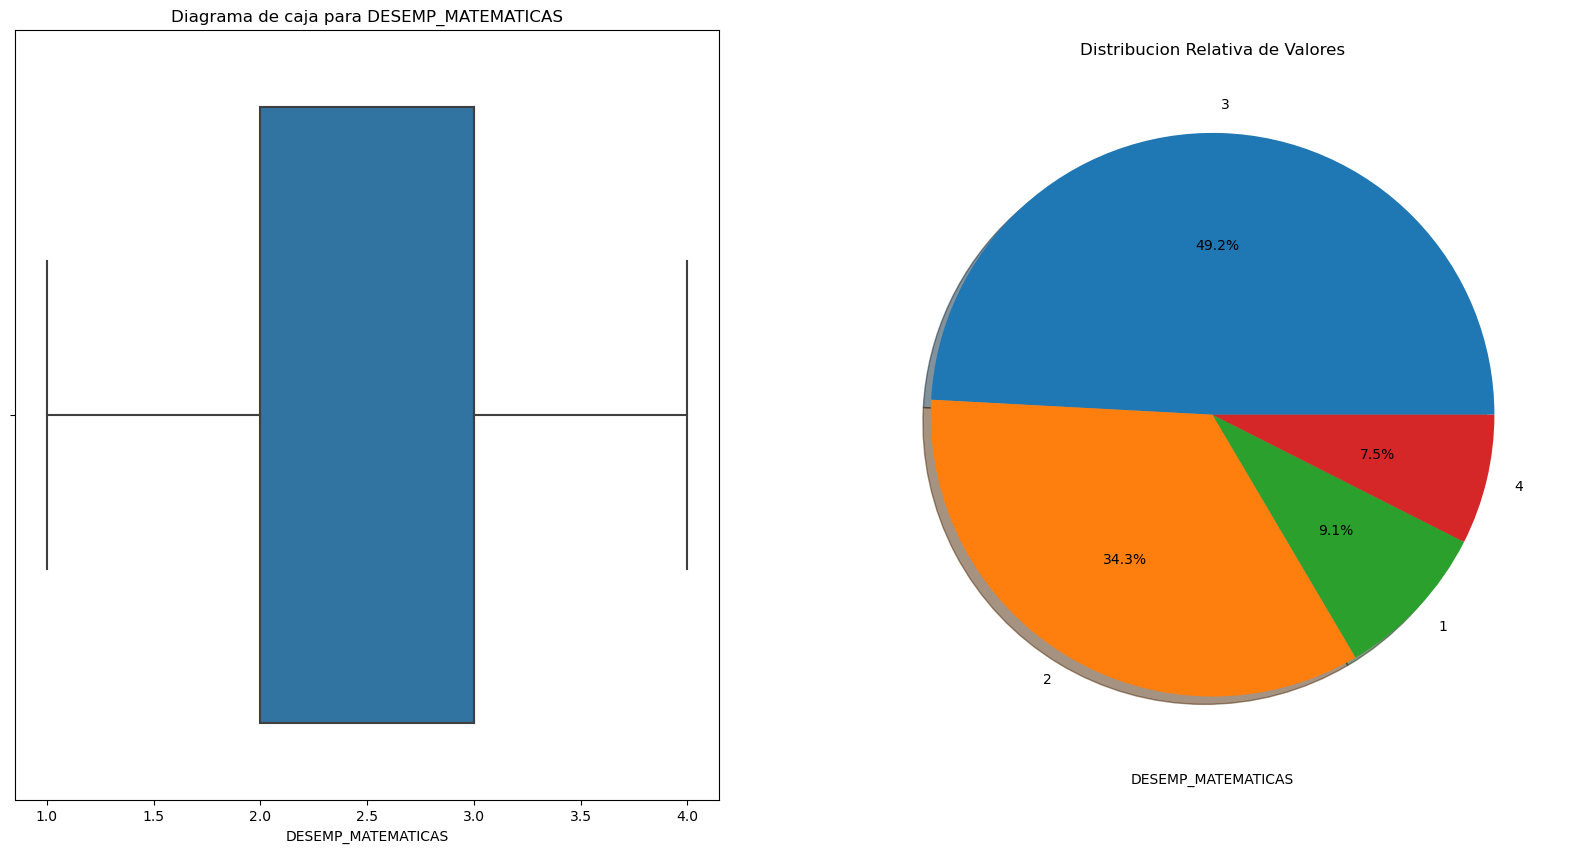



Estadisticas Basicas


count    405869.000000
mean          2.549828
std           0.760302
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: DESEMP_MATEMATICAS, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




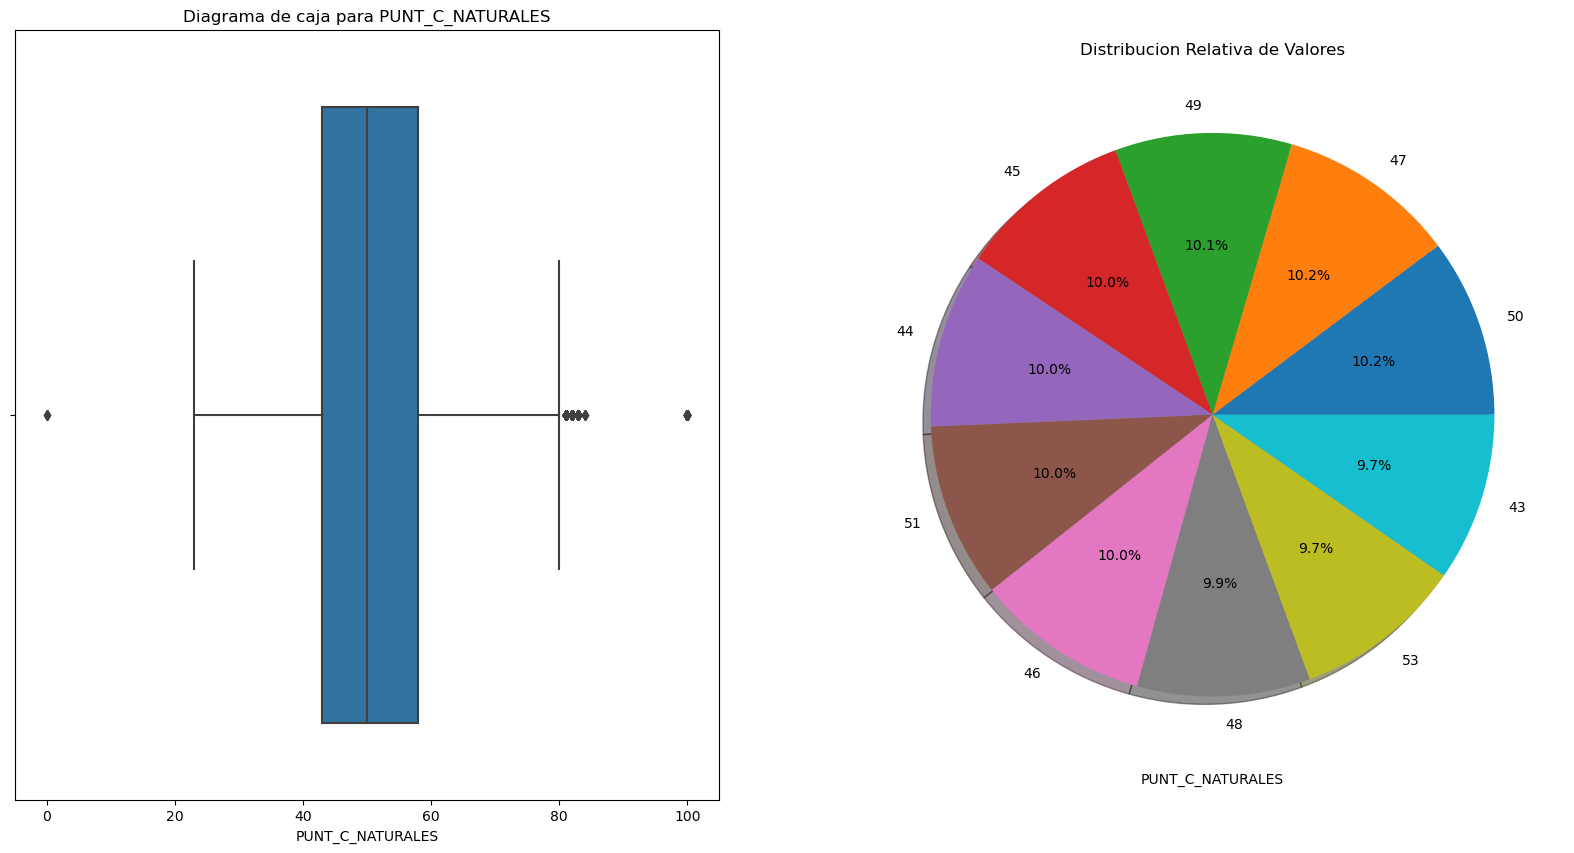



Estadisticas Basicas


count    405869.000000
mean         50.768206
std          10.557262
min           0.000000
25%          43.000000
50%          50.000000
75%          58.000000
max         100.000000
Name: PUNT_C_NATURALES, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




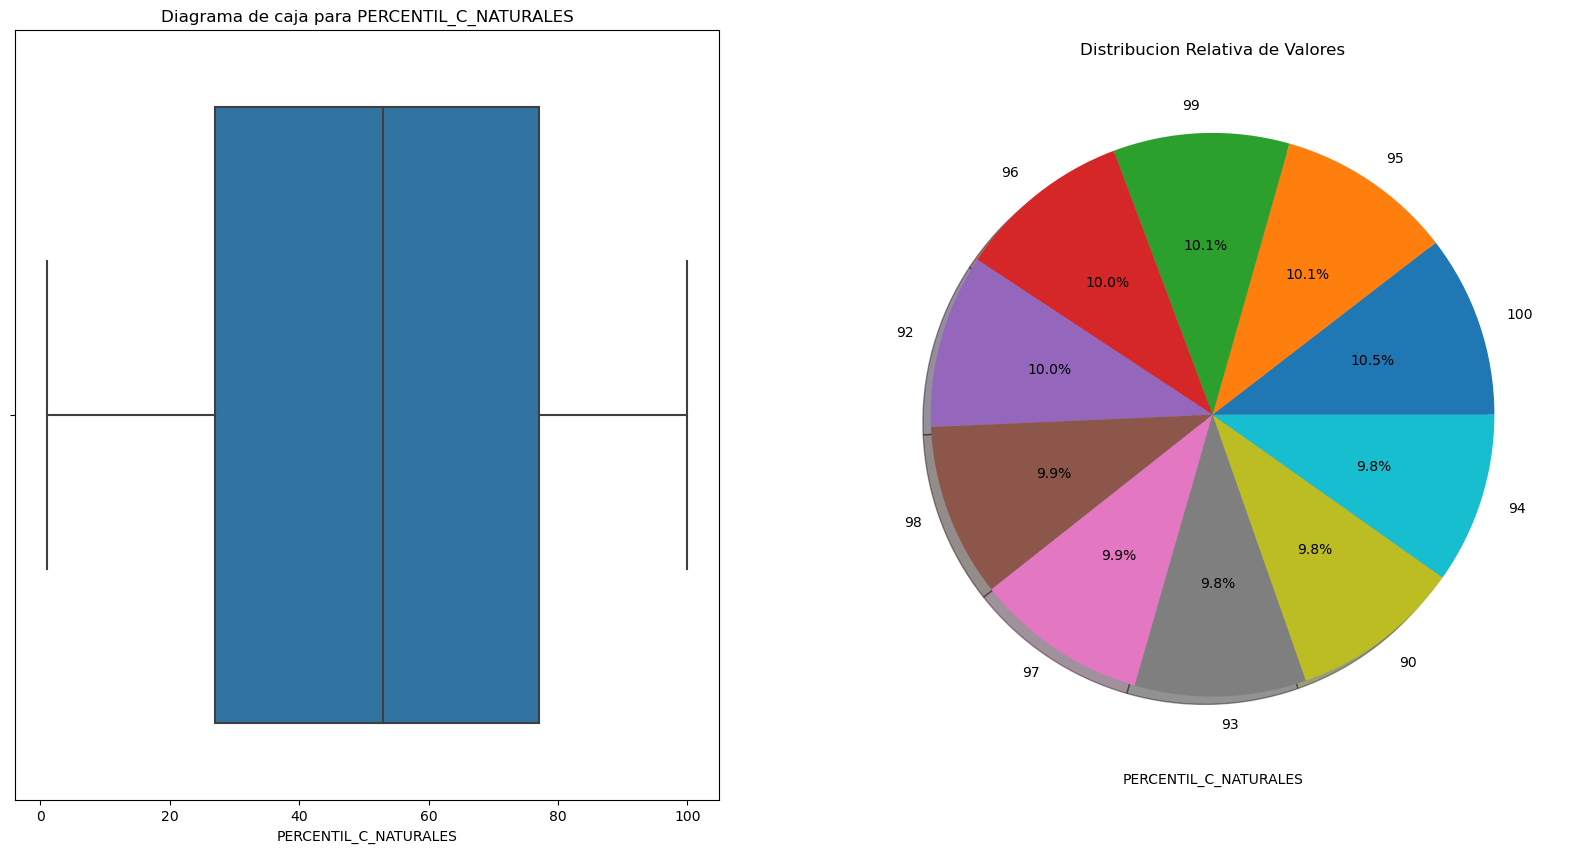



Estadisticas Basicas


count    405869.000000
mean         51.854379
std          28.799393
min           1.000000
25%          27.000000
50%          53.000000
75%          77.000000
max         100.000000
Name: PERCENTIL_C_NATURALES, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




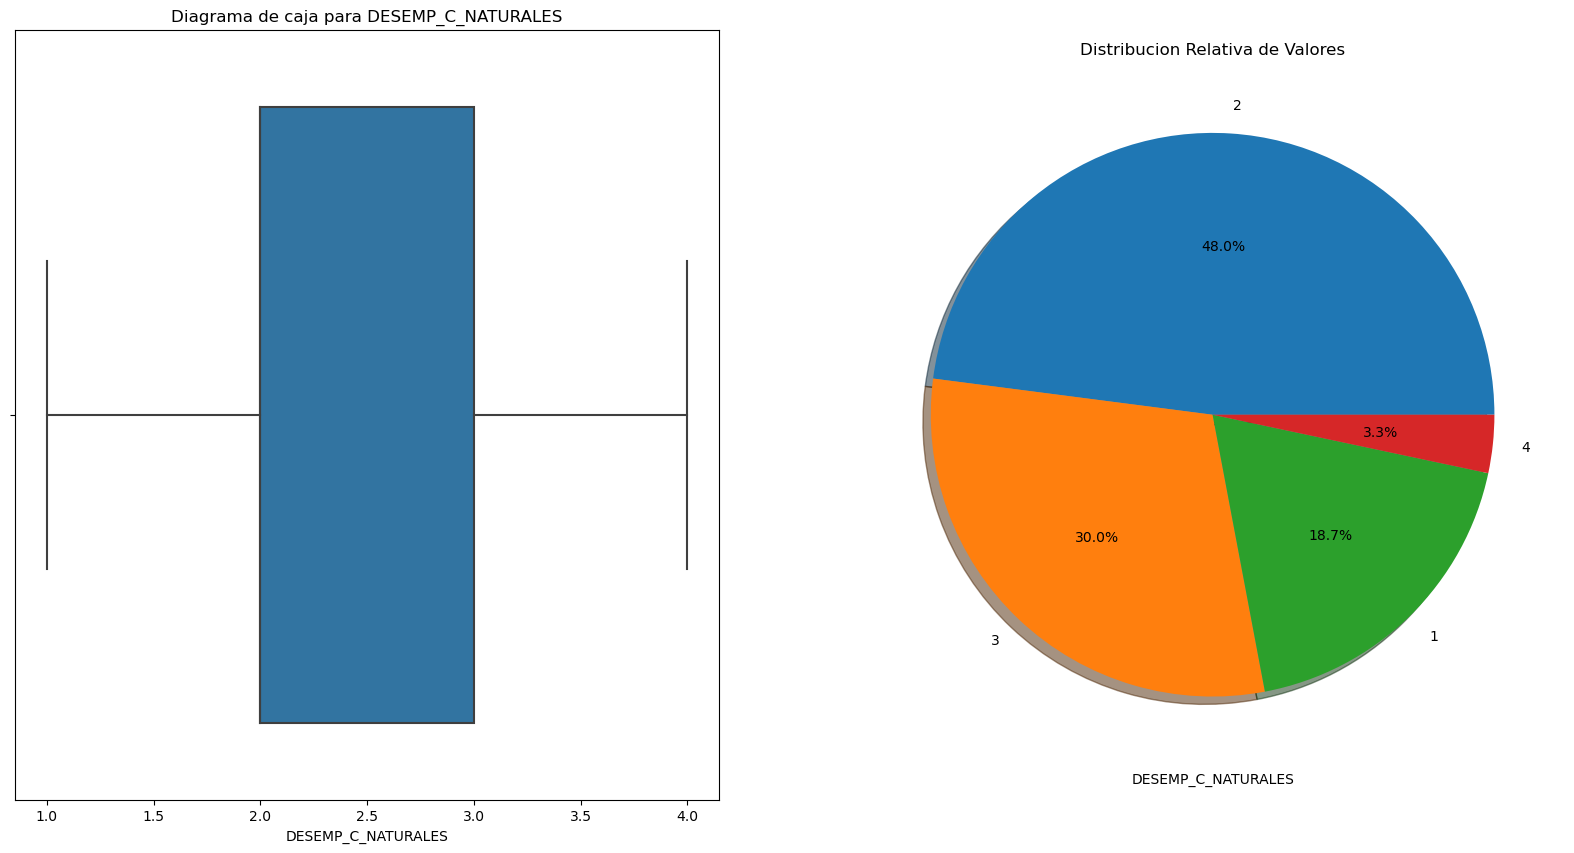



Estadisticas Basicas


count    405869.000000
mean          2.179765
std           0.766806
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: DESEMP_C_NATURALES, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




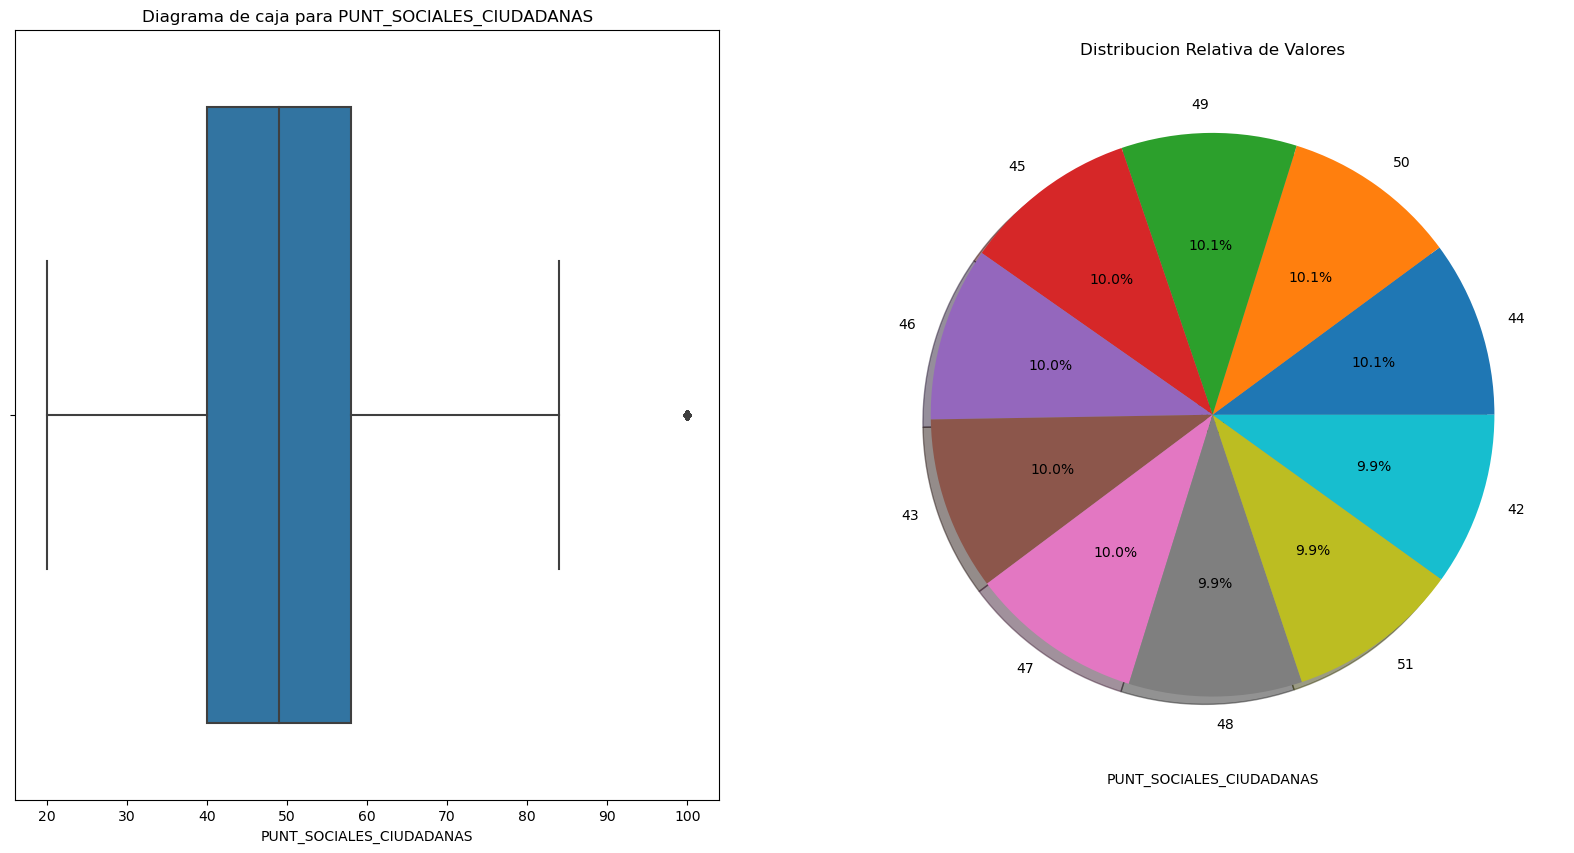



Estadisticas Basicas


count    405869.000000
mean         49.469309
std          11.939110
min          20.000000
25%          40.000000
50%          49.000000
75%          58.000000
max         100.000000
Name: PUNT_SOCIALES_CIUDADANAS, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




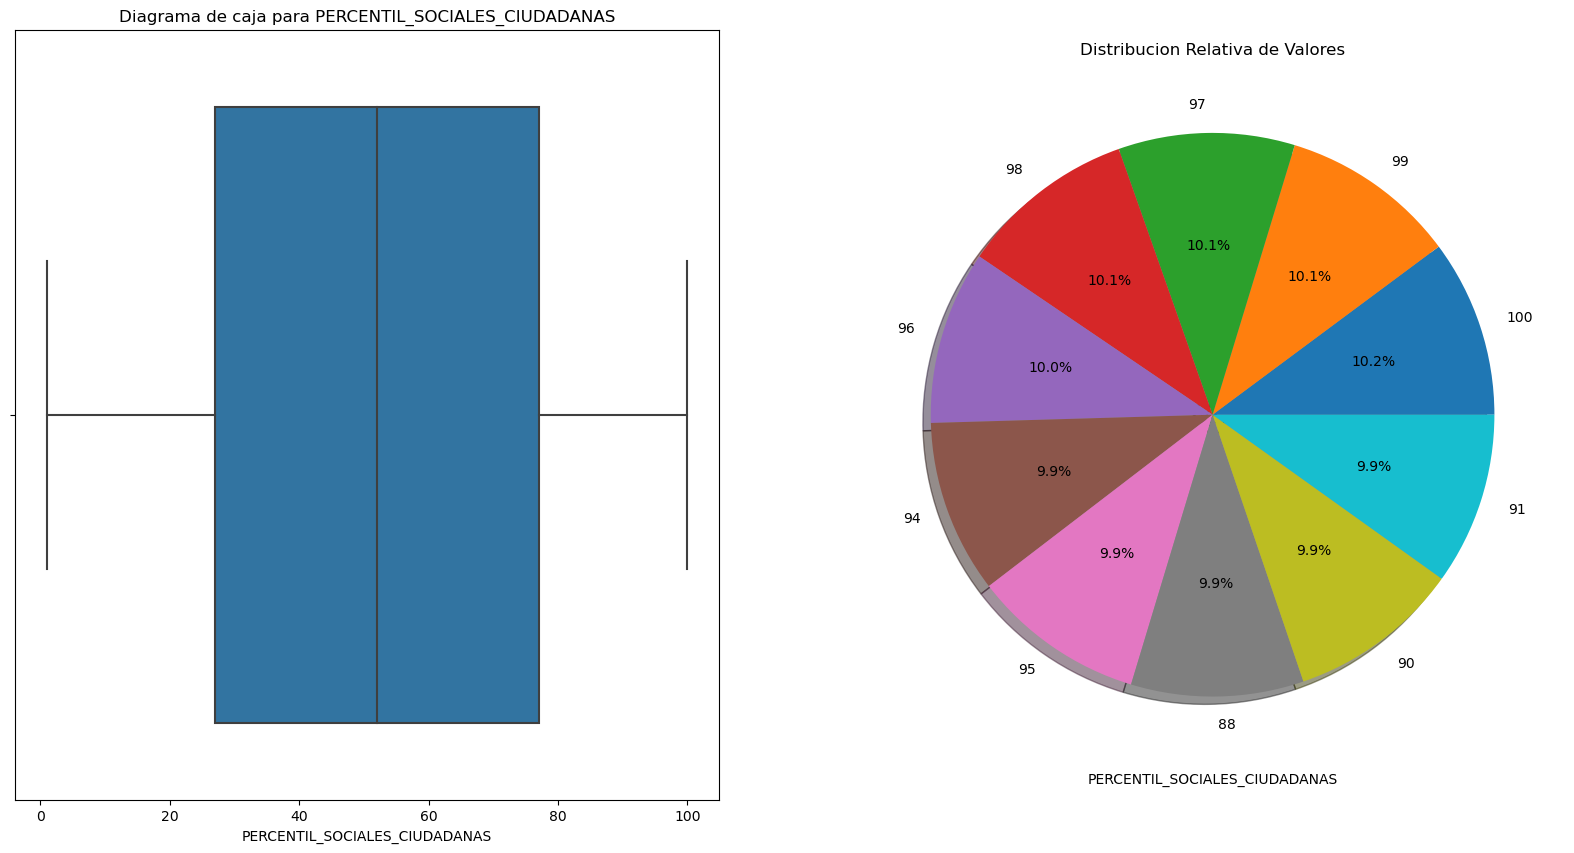



Estadisticas Basicas


count    405869.000000
mean         51.715829
std          28.839141
min           1.000000
25%          27.000000
50%          52.000000
75%          77.000000
max         100.000000
Name: PERCENTIL_SOCIALES_CIUDADANAS, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




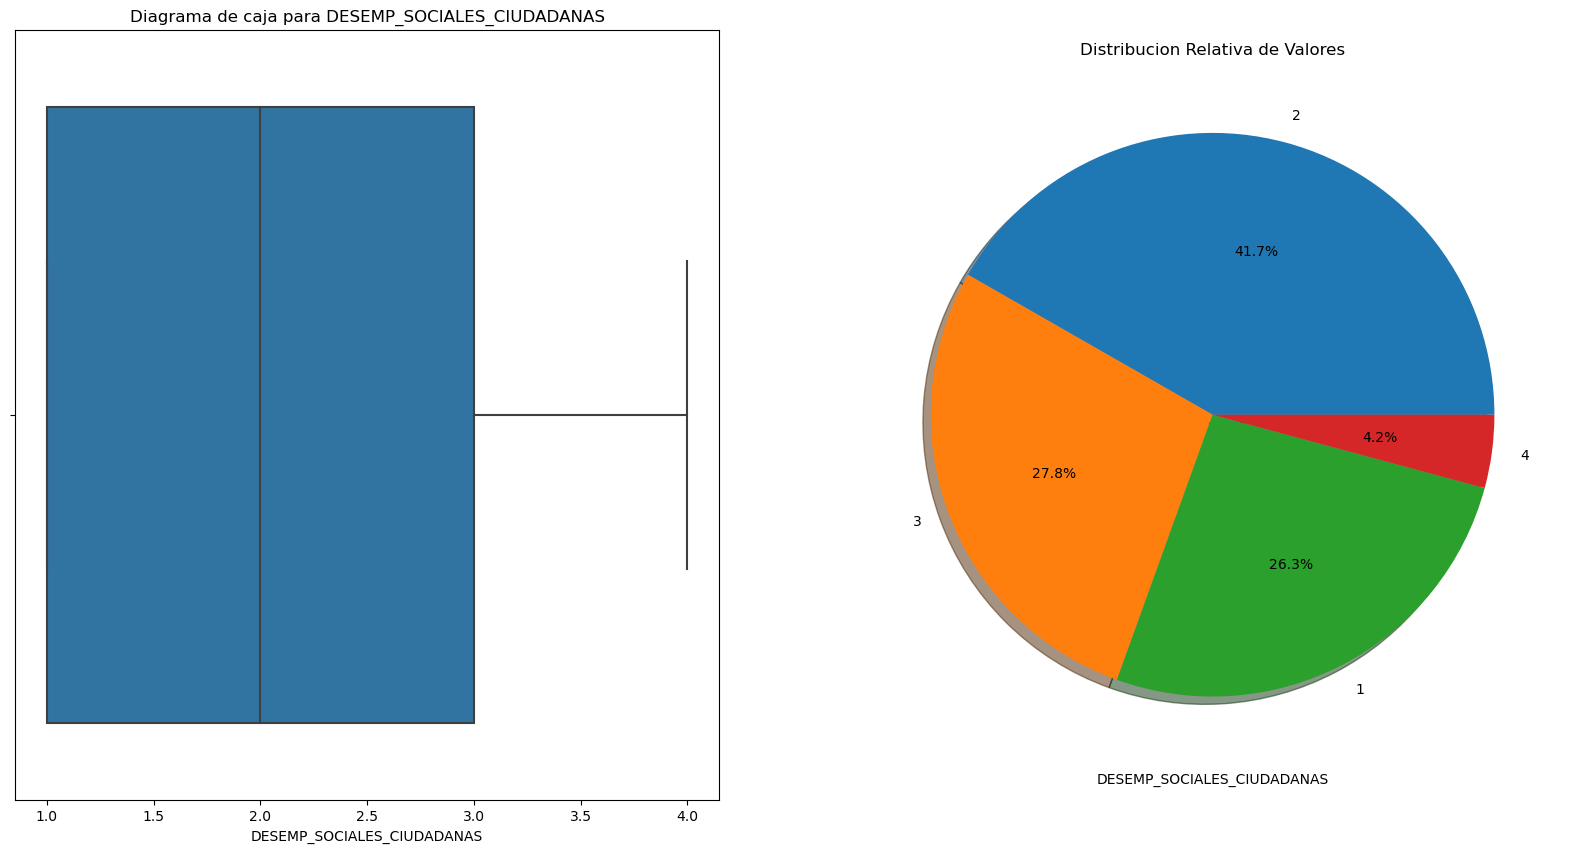



Estadisticas Basicas


count    405869.000000
mean          2.098167
std           0.835927
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: DESEMP_SOCIALES_CIUDADANAS, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




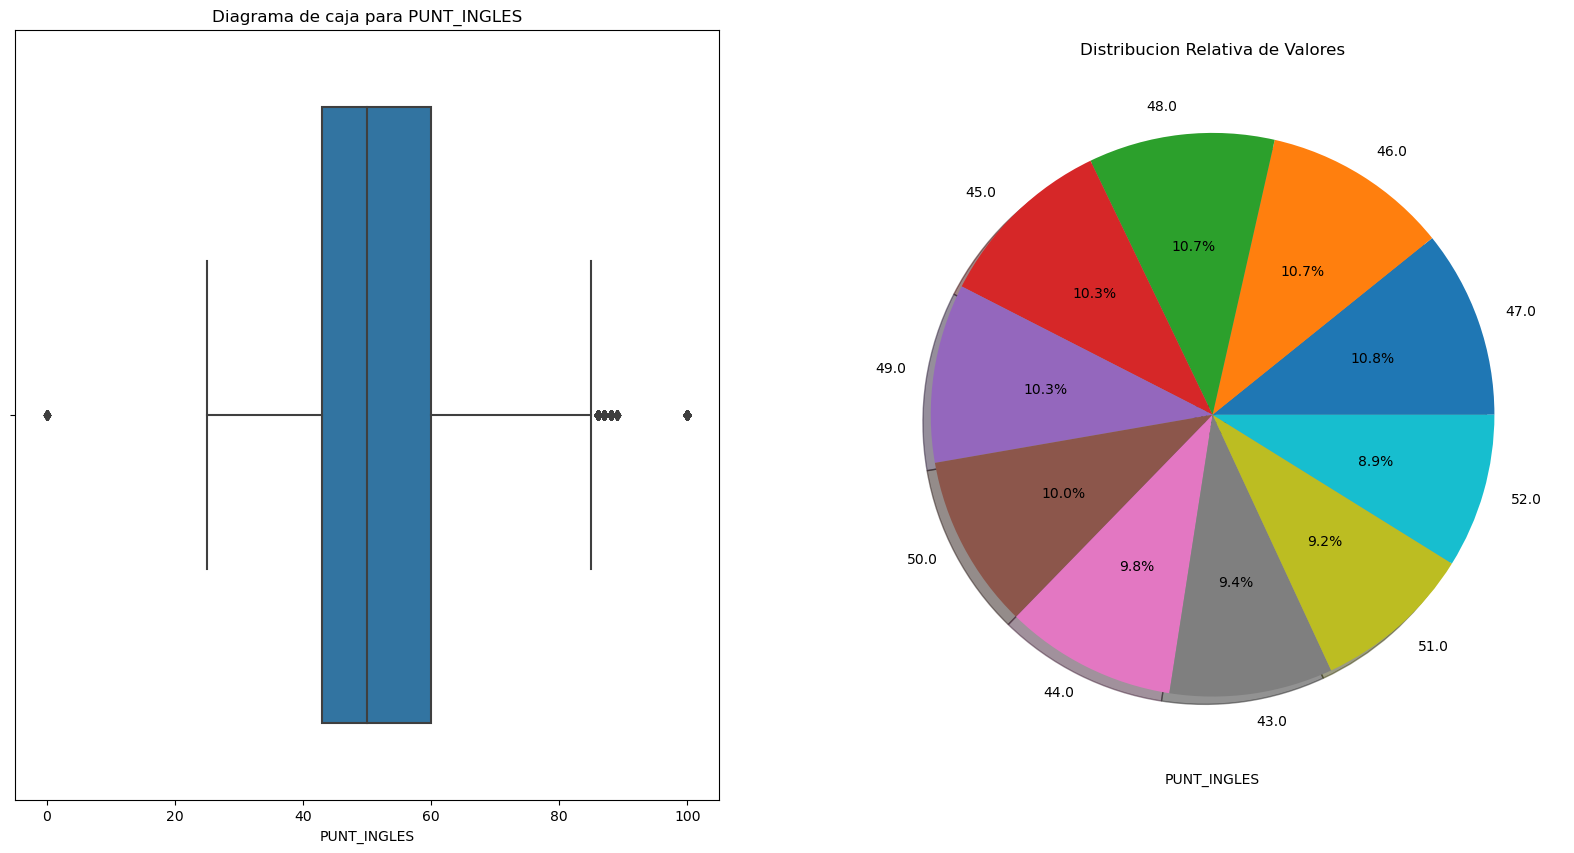



Estadisticas Basicas


count    405869.000000
mean         52.251234
std          12.912011
min           0.000000
25%          43.000000
50%          50.000000
75%          60.000000
max         100.000000
Name: PUNT_INGLES, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




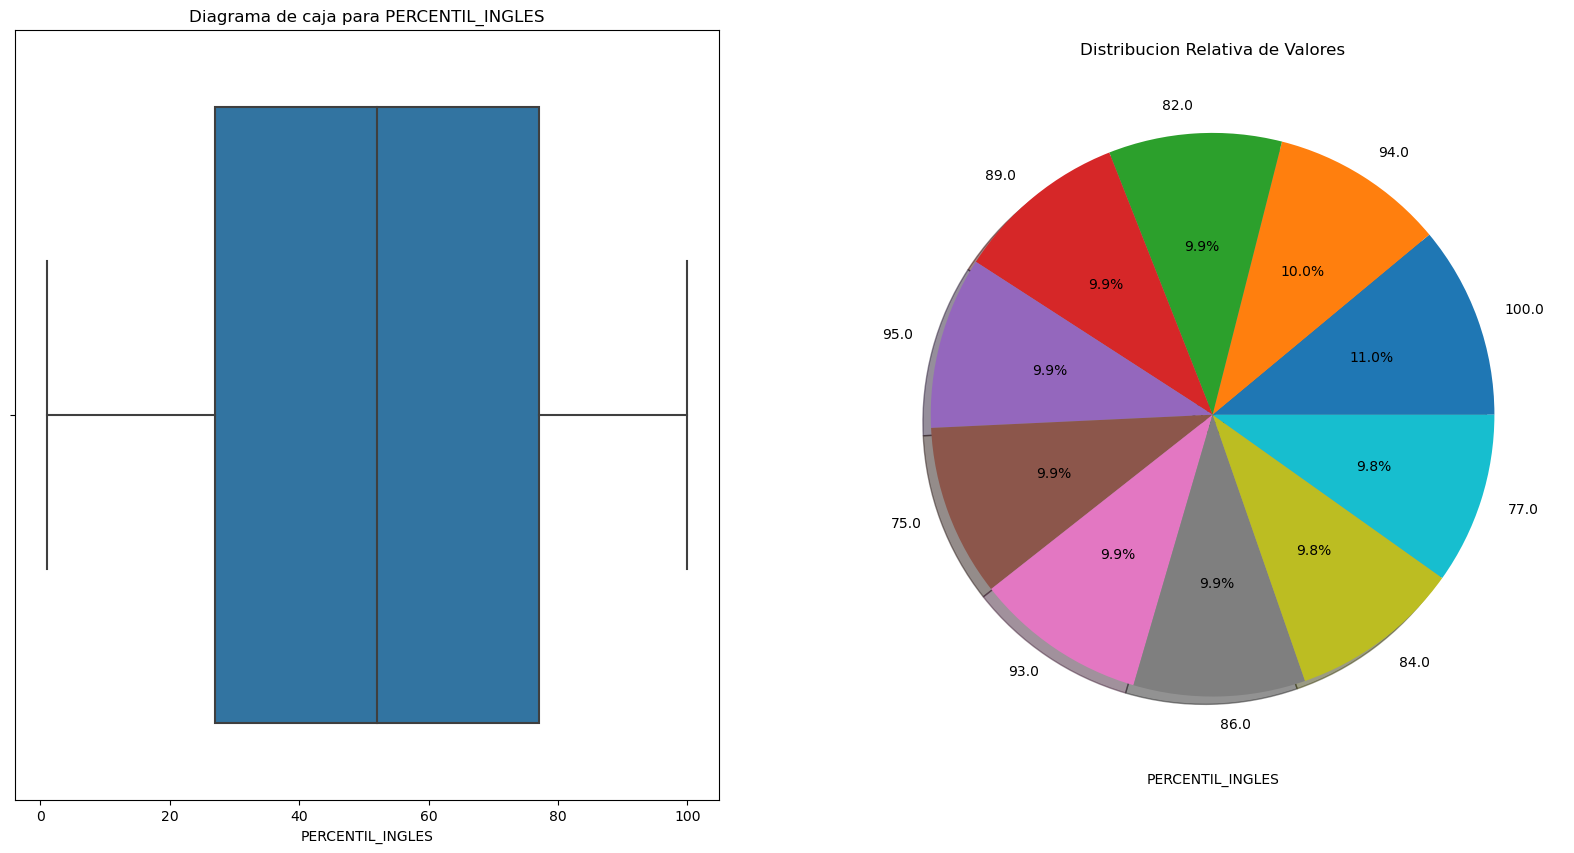



Estadisticas Basicas


count    405869.000000
mean         51.714970
std          28.701859
min           1.000000
25%          27.000000
50%          52.000000
75%          77.000000
max         100.000000
Name: PERCENTIL_INGLES, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




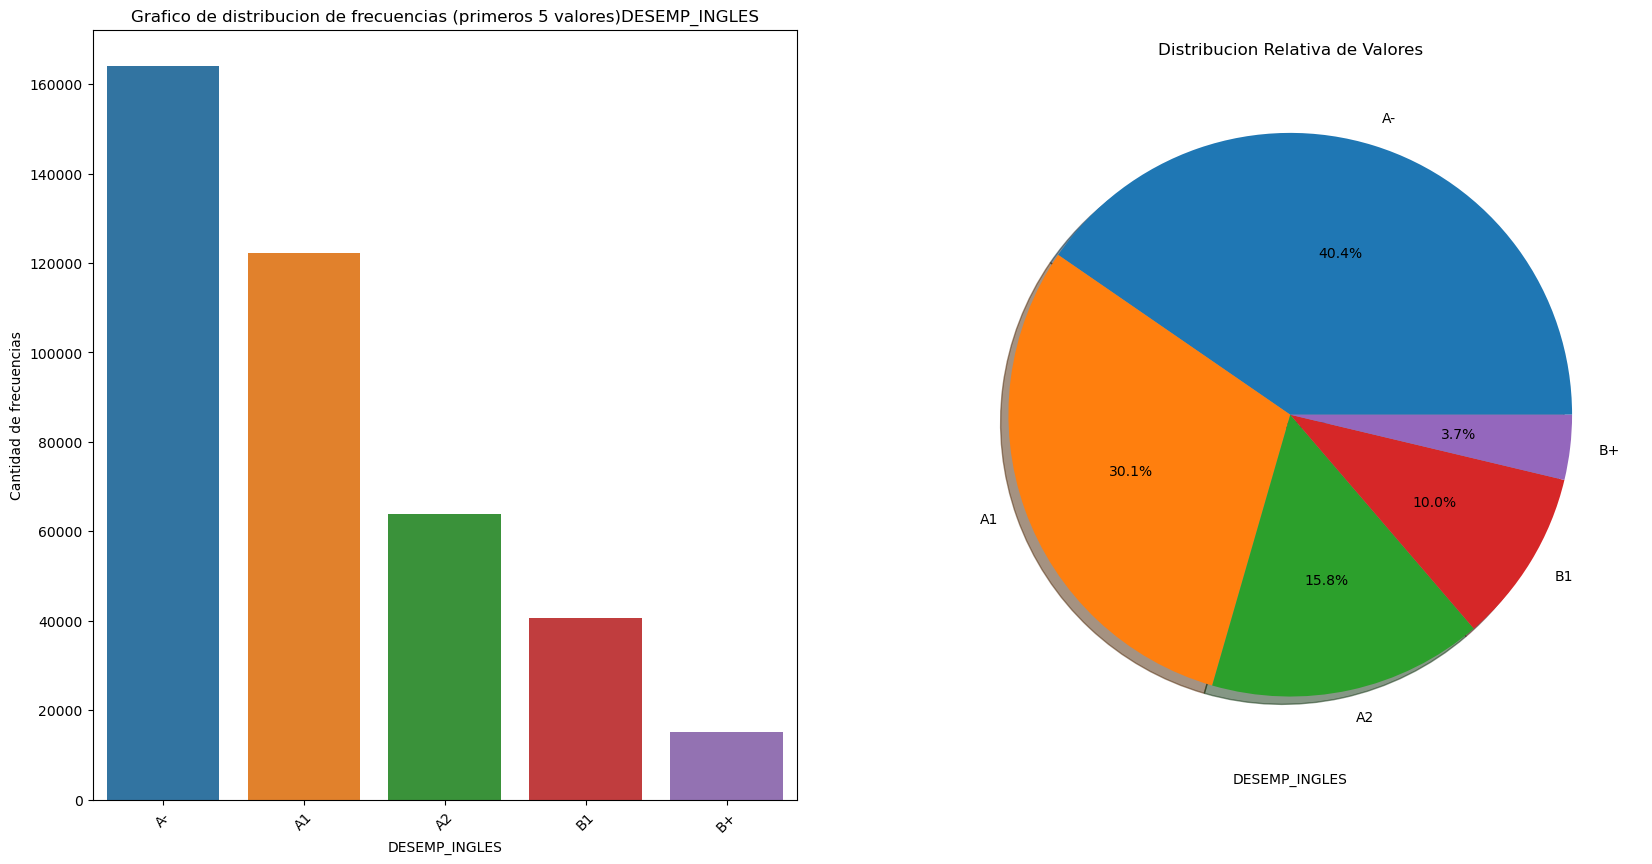



Estadisticas Basicas


count     405869
unique         5
top           A-
freq      163975
Name: DESEMP_INGLES, dtype: object
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




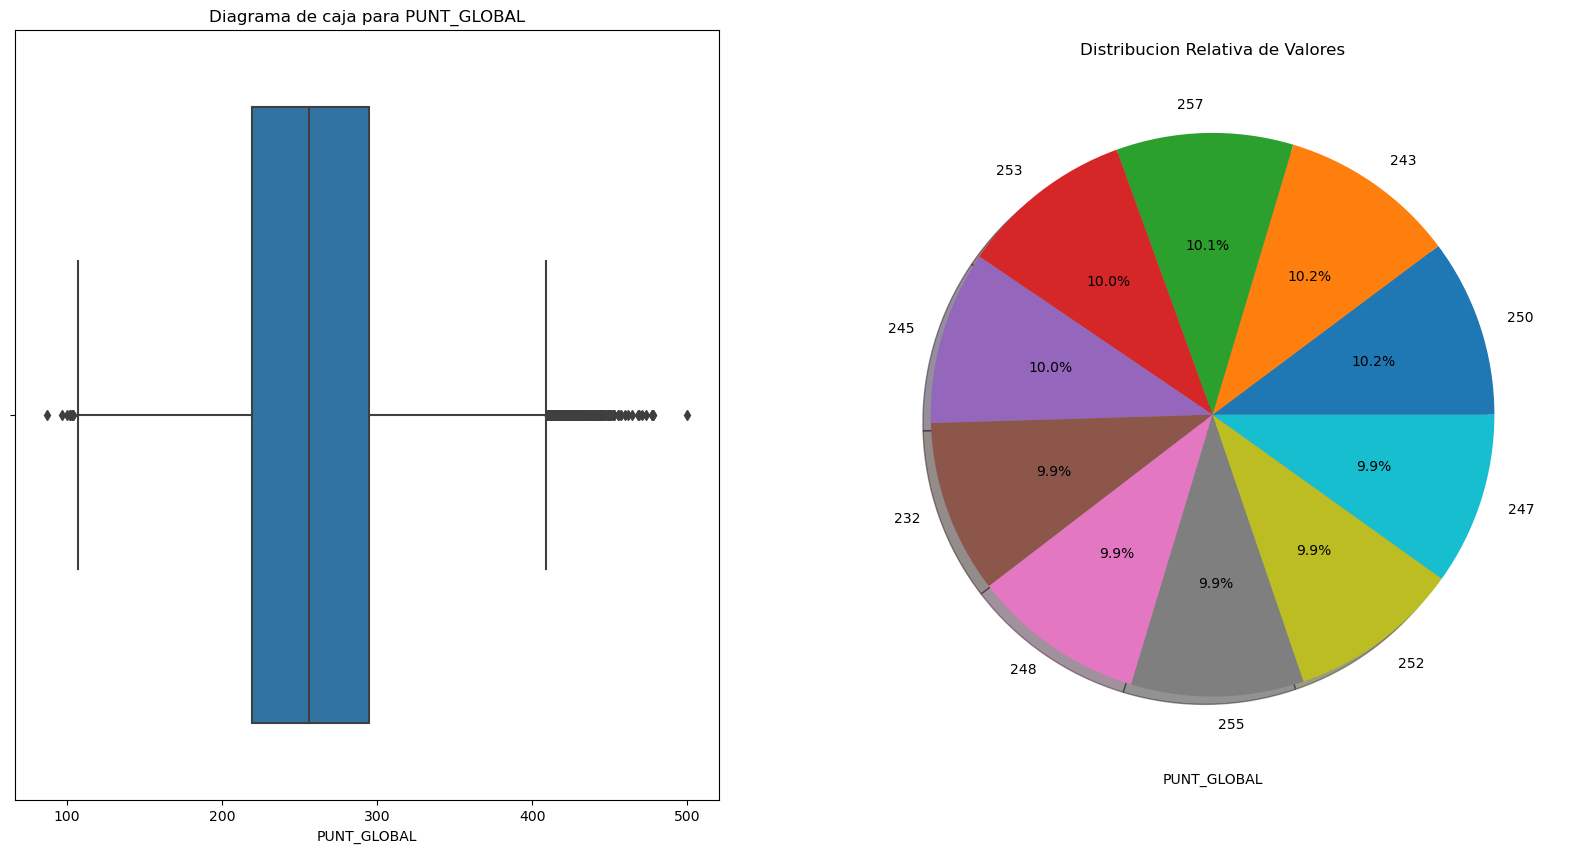



Estadisticas Basicas


count    405869.000000
mean        258.771273
std          51.720142
min          87.000000
25%         219.000000
50%         256.000000
75%         295.000000
max         500.000000
Name: PUNT_GLOBAL, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




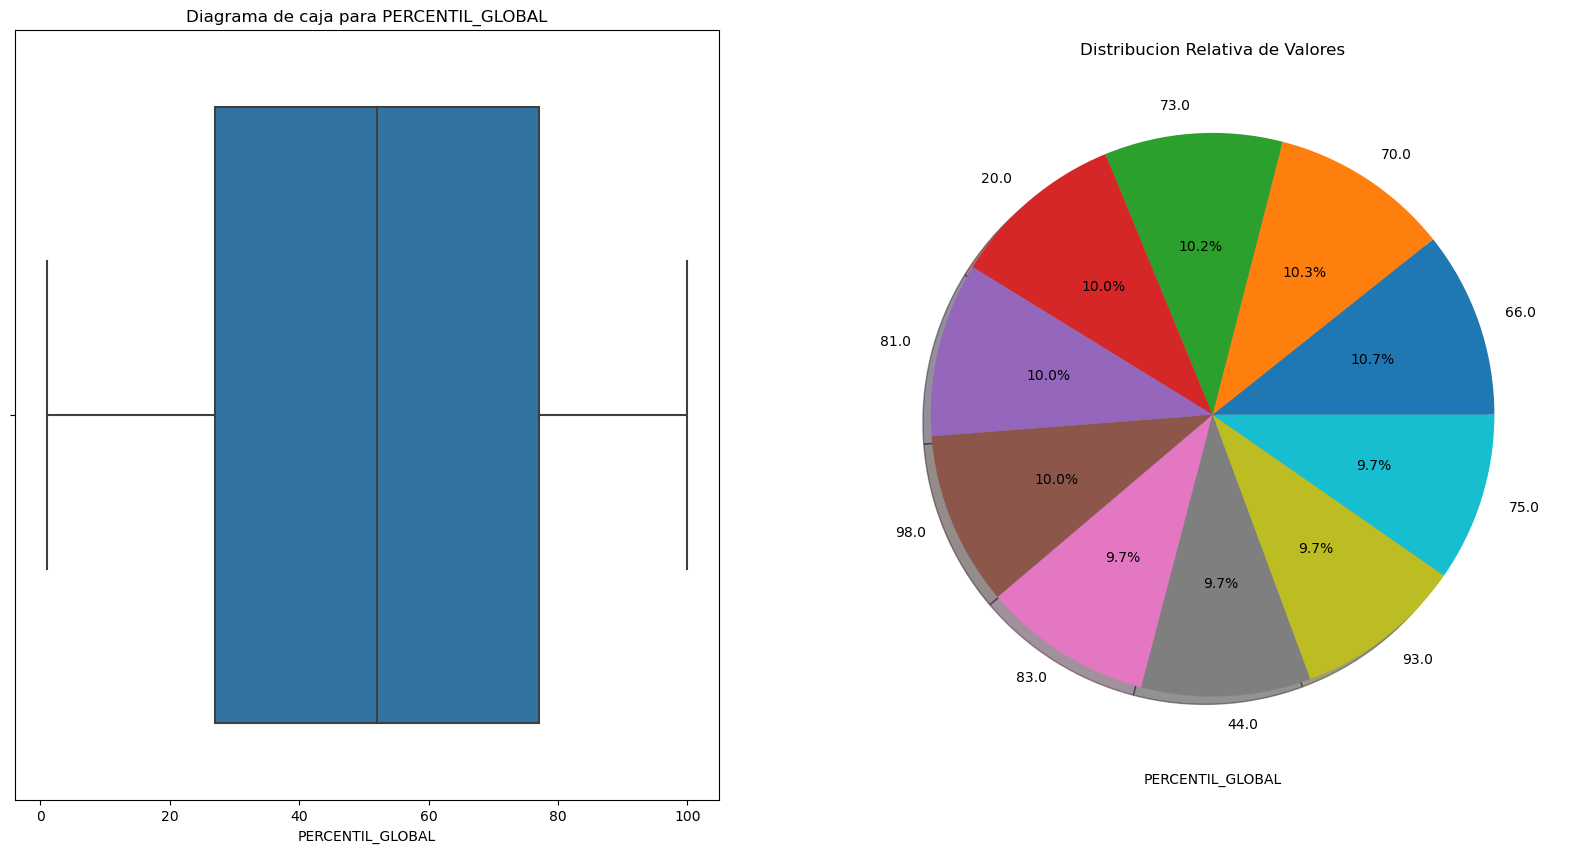



Estadisticas Basicas


count    405869.000000
mean         51.817796
std          28.760980
min           1.000000
25%          27.000000
50%          52.000000
75%          77.000000
max         100.000000
Name: PERCENTIL_GLOBAL, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




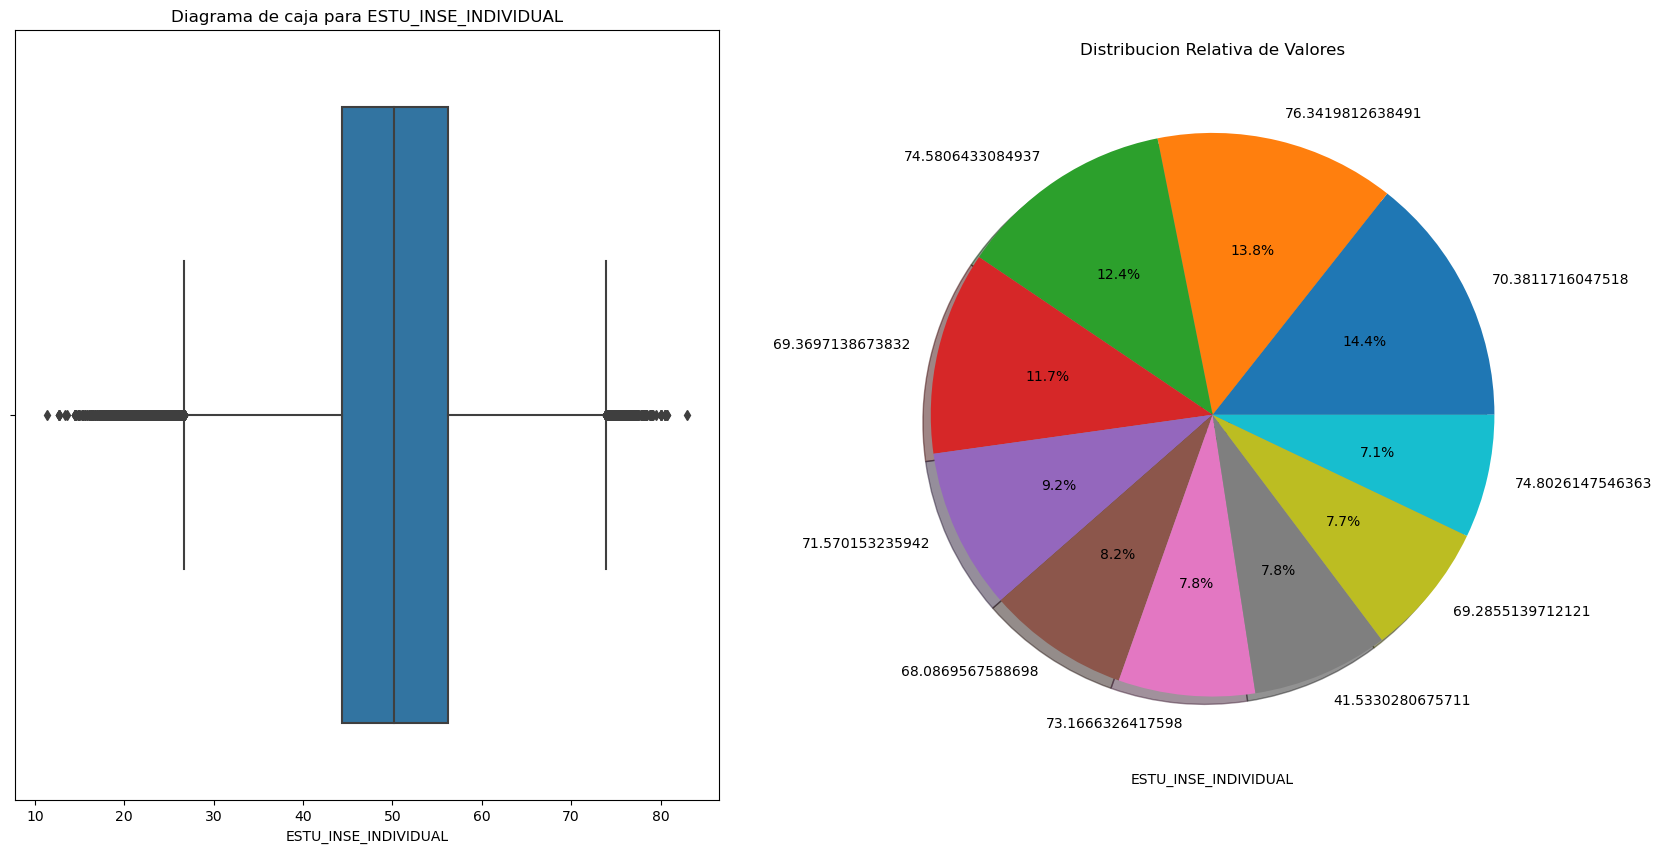



Estadisticas Basicas


count    405869.000000
mean         50.322277
std           8.804060
min          11.347243
25%          44.405296
50%          50.206417
75%          56.197166
max          83.007321
Name: ESTU_INSE_INDIVIDUAL, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




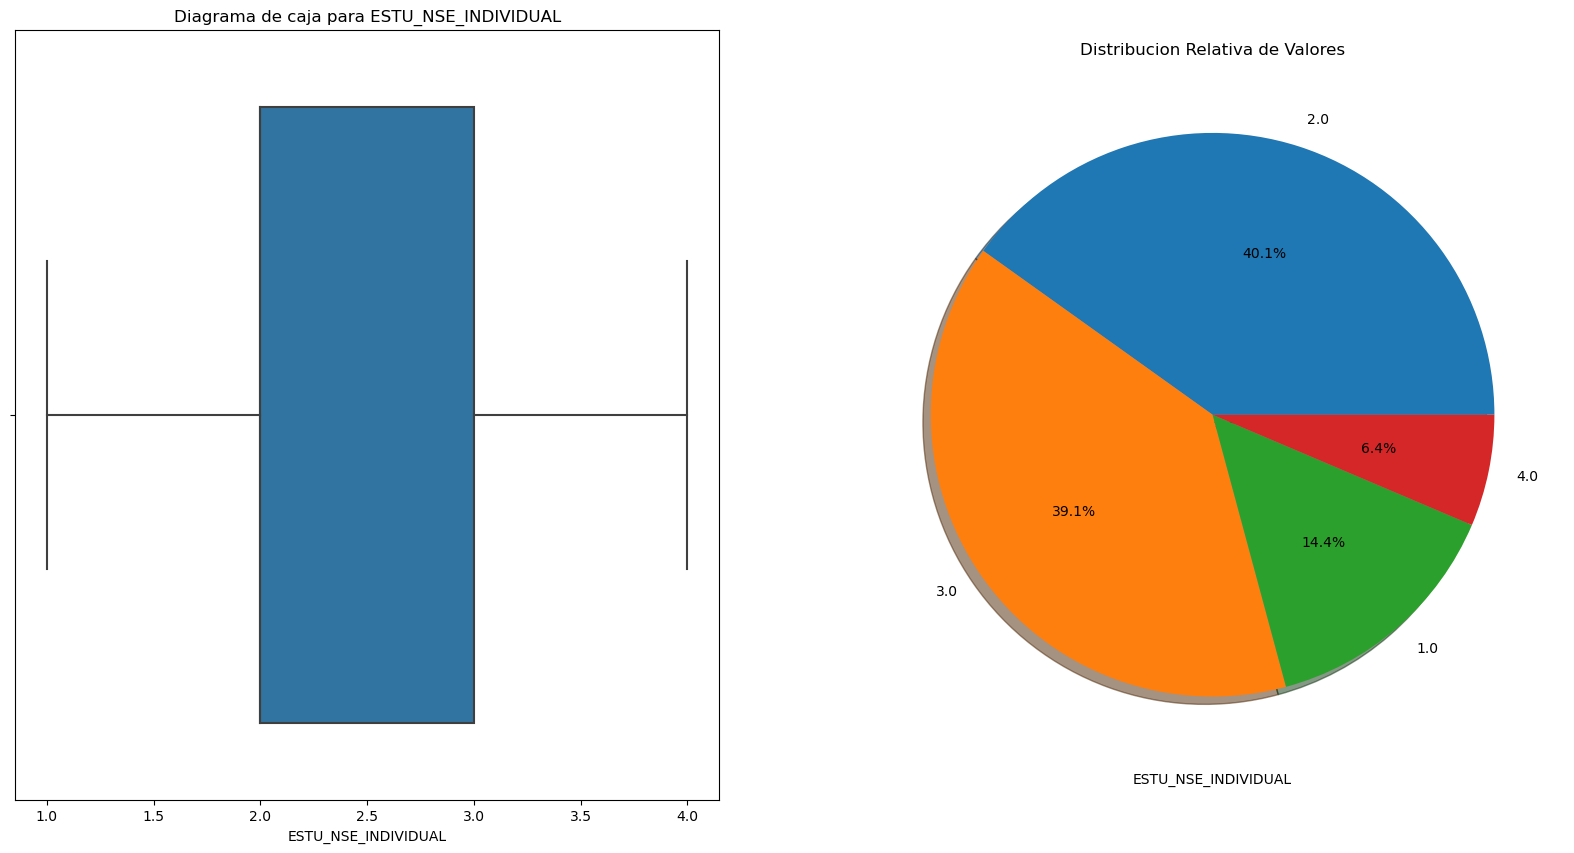



Estadisticas Basicas


count    405869.000000
mean          2.374695
std           0.806455
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: ESTU_NSE_INDIVIDUAL, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




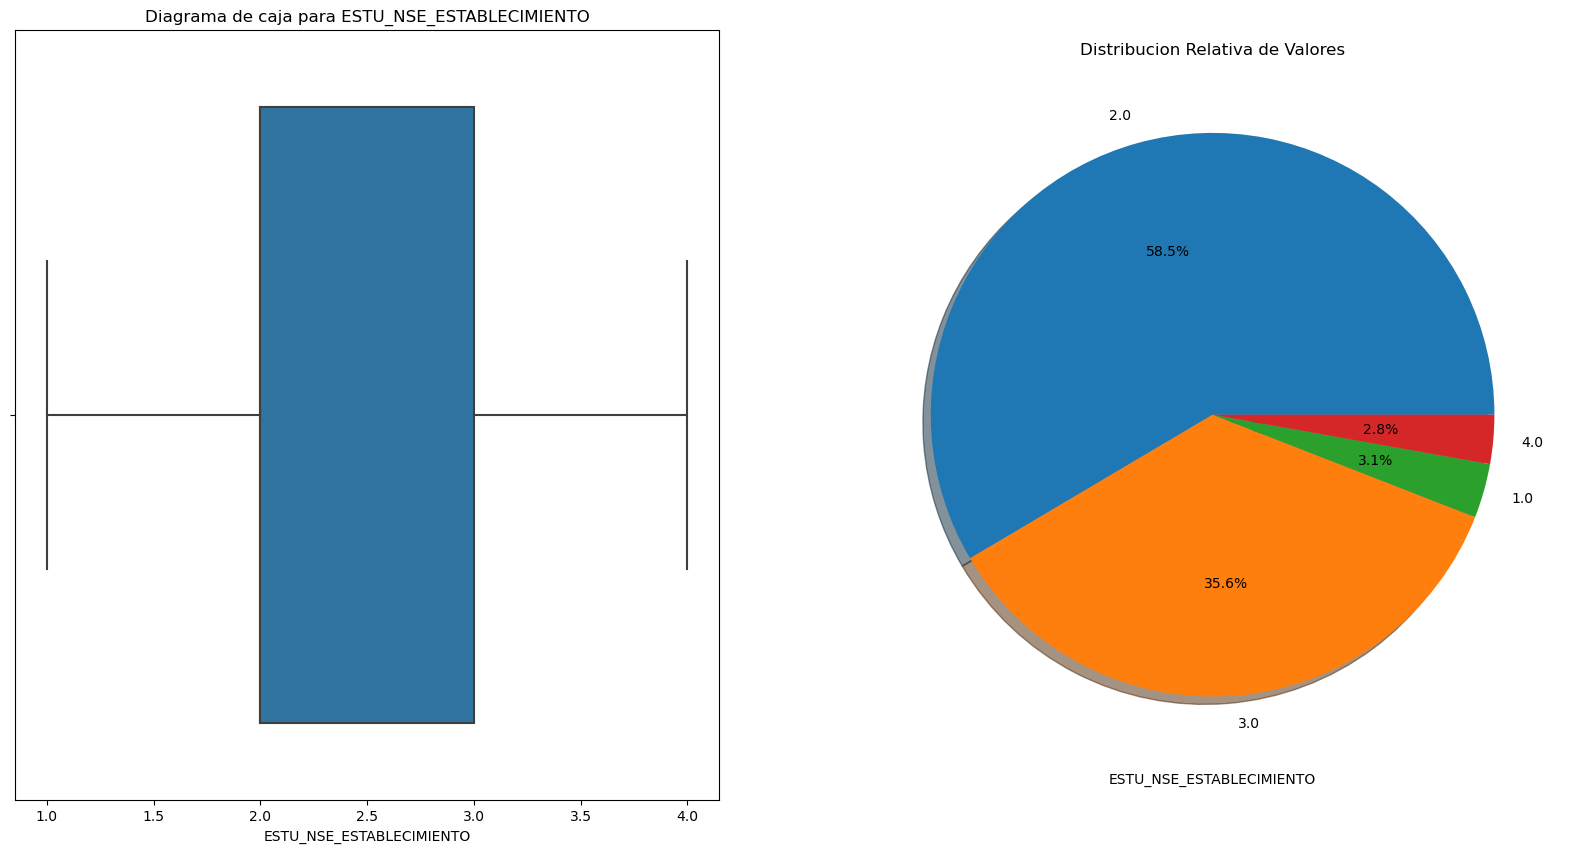



Estadisticas Basicas


count    405869.000000
mean          2.380827
std           0.595103
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: ESTU_NSE_ESTABLECIMIENTO, dtype: float64
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------




In [ ]:
cantidad_por_dia_semana(df)

## <h2 align= 'center'><u>Análisis General</u></h2>

# <h1 align= 'center'><u>**Conclusiones**</u></h1>

# Diccionario de Datos